In [82]:
from collections import Counter



In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
col = ['target','F1R','F1S','F2R','F2S','F3R','F3S','F4R','F4S','F5R','F5S','F6R','F6S','F7R','F7S','F8R','F8S','F9R','F9S','F10R','F10S',
      'F11R','F11S','F12R','F12S','F13R','F13S','F14R','F14S','F15R','F15S','F16R','F16S','F17R','F17S','F18R','F18S',
      'F19R','F19S','F20R','F20S','F21R','F21S','F22R','F22S']

train = pd.read_csv('data/SPECTF_train.csv', header=None, low_memory=False,names = col,)
train.head()
test = pd.read_csv('data/SPECTF_test.csv', header=None, low_memory=False,names = col)

import numpy as np
scaler = StandardScaler()
y_train = train['target'].values.reshape(-1,1)
X = train.drop('target',axis = 1).values
test_y = test['target'].values.reshape(-1,1)
test_x = test.drop('target',axis = 1).values
X_std = scaler.fit_transform(X)


/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/marcowang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [117]:
# Activation Function
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    z = Z[:]
    z[z<0] = 0
    return z

def sigmoid_backward(sig):
    return (sig * (1 - sig))

def relu_backward(Z):
    dZ = Z.copy()
    dZ[dZ > 0] = 1
    return dZ;

def step(Z):
    Z[Z>=0] = 1
    Z[Z<0] = 0
    return Z

def bina(Z):
    dZ = Z.copy()
    dZ[dZ > 0.5] = 1
    dZ[dZ <= 0.5] = 0
    return dZ
    
def tanh(Z):
    return (np.exp(2*Z) -1)/(np.exp(2*Z) +1)

def tanh_backward(tan):
    return (1 - tan**2)



In [124]:
def weight_initial(m,n): # xiviar initial
    weights= np.random.randn(m, n) / np.sqrt(m)
    bias = np.random.randn(1, n) / np.sqrt(m)
    return weights,bias
        
class MN(object):
    def __init__(self,n_feature, n_input,n_hidden, n_output,activation = 'sigmoid'): # 3 matrix
        np.random.seed(224)
        self.input_weights,self.input_bias = weight_initial(n_feature, n_input) #m x l1
        self.hidden_weights,self.hidden_bias = weight_initial(n_input,n_hidden) # l1 x l2
        self.output_weights,self.output_bias = weight_initial(n_hidden, n_output) # l2 x l3
        self.activation = activation
        
    def forward(self,inputx):
        if self.activation == 'sigmoid':
            self.out1 = sigmoid(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = sigmoid(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = sigmoid(np.dot(self.out2,self.output_weights) + self.output_bias)
            #print(self.out3)
        
        if self.activation == 'step':
            self.out1 = step(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = step(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = step(np.dot(self.out2,self.output_weights) + self.output_bias)
            
        if self.activation == 'tanh':
            self.out1 = tanh(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = tanh(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = tanh(np.dot(self.out2,self.output_weights) + self.output_bias)
            
        if self.activation == 'relu':
            self.out1 = relu(np.dot(inputx,self.input_weights) + self.input_bias)
            self.out2 = relu(np.dot(self.out1,self.hidden_weights) + self.hidden_bias)
            self.out3 = relu(np.dot(self.out2,self.output_weights) + self.output_bias)
    
    def loss(self,X_train,y_train):
        self.forward(X_train)
        self.error3 = y_train - self.out3
        self.error2 = np.mean(self.error3 * self.output_weights.T,axis = 0).reshape(1,-1)
        self.error1 = self.error2.dot(self.hidden_weights.T)
        return np.mean(self.error3**2)
            
    def backward(self,inputx, y_train,learnrate):
        if self.activation == 'sigmoid':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(sigmoid_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * sigmoid_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(sigmoid_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (sigmoid_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(sigmoid_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * sigmoid_backward(self.out1),axis = 0)
            
            
        if self.activation == 'tanh':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(tanh_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * tanh_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(tanh_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (tanh_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(tanh_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * tanh_backward(self.out1),axis = 0)
            
        
        if self.activation == 'relu':
            error3_ = np.mean(self.error3,axis=0)
            self.output_weights += learnrate * error3_ * self.out2.T.dot(relu_backward(self.out3))
            self.output_bias += np.sum(learnrate * error3_ * relu_backward(self.out3))
            
            self.hidden_weights += learnrate * (self.error2 * self.out1.T.dot(relu_backward(self.out2)))
            self.hidden_bias += np.sum(learnrate * self.error2 * (relu_backward(self.out2)),axis =0)
            
            self.input_weights += learnrate * self.error1 * inputx.T.dot(relu_backward(self.out1))
            self.input_bias += np.sum(learnrate * self.error1 * relu_backward(self.out1),axis = 0)
      
            
    def train(self,X_train,y_train,learnrate, iteration = 100):
        self.losses = []
        for i in range(iteration):
            self.loss(X_train,y_train)
            self.backward(X_train,y_train,learnrate)
            
            
            if i % 100 ==0:
                self.losses.append(self.loss(X_train,y_train))
                print('Epoch: ', str(i) +'| ' +str(iteration), '| train loss: %.4f' % self.losses[-1])
            
    def predict(self,X,y):
        self.forward(X)
        self.prob =self.out3
        self.pre = bina(self.prob)
        fpr,tpr,thresholds = roc_curve(y, self.pre)
        acc = list(y-self.pre).count(0)/len(self.pre)
        
        print('Acc: {}'.format(acc))
        print(classification_report(y,self.pre))
        print(confusion_matrix(y,self.pre))
        print("AUC: {}".format(roc_auc_score(y, self.pre)))
        sns.set_style()
        plt.figure(figsize=(8,6),dpi = 300)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
  

Epoch:  0| 3000 | train loss: 0.2370
Epoch:  100| 3000 | train loss: 0.2337
Epoch:  200| 3000 | train loss: 0.2338
Epoch:  300| 3000 | train loss: 0.2338
Epoch:  400| 3000 | train loss: 0.2338
Epoch:  500| 3000 | train loss: 0.2338
Epoch:  600| 3000 | train loss: 0.2338
Epoch:  700| 3000 | train loss: 0.2338
Epoch:  800| 3000 | train loss: 0.2338
Epoch:  900| 3000 | train loss: 0.2338
Epoch:  1000| 3000 | train loss: 0.2338
Epoch:  1100| 3000 | train loss: 0.2338
Epoch:  1200| 3000 | train loss: 0.2338
Epoch:  1300| 3000 | train loss: 0.2338
Epoch:  1400| 3000 | train loss: 0.2338
Epoch:  1500| 3000 | train loss: 0.2338
Epoch:  1600| 3000 | train loss: 0.2338
Epoch:  1700| 3000 | train loss: 0.2338
Epoch:  1800| 3000 | train loss: 0.2338
Epoch:  1900| 3000 | train loss: 0.2338
Epoch:  2000| 3000 | train loss: 0.2338
Epoch:  2100| 3000 | train loss: 0.2338
Epoch:  2200| 3000 | train loss: 0.2338
Epoch:  2300| 3000 | train loss: 0.2338
Epoch:  2400| 3000 | train loss: 0.2338
Epoch:  2500

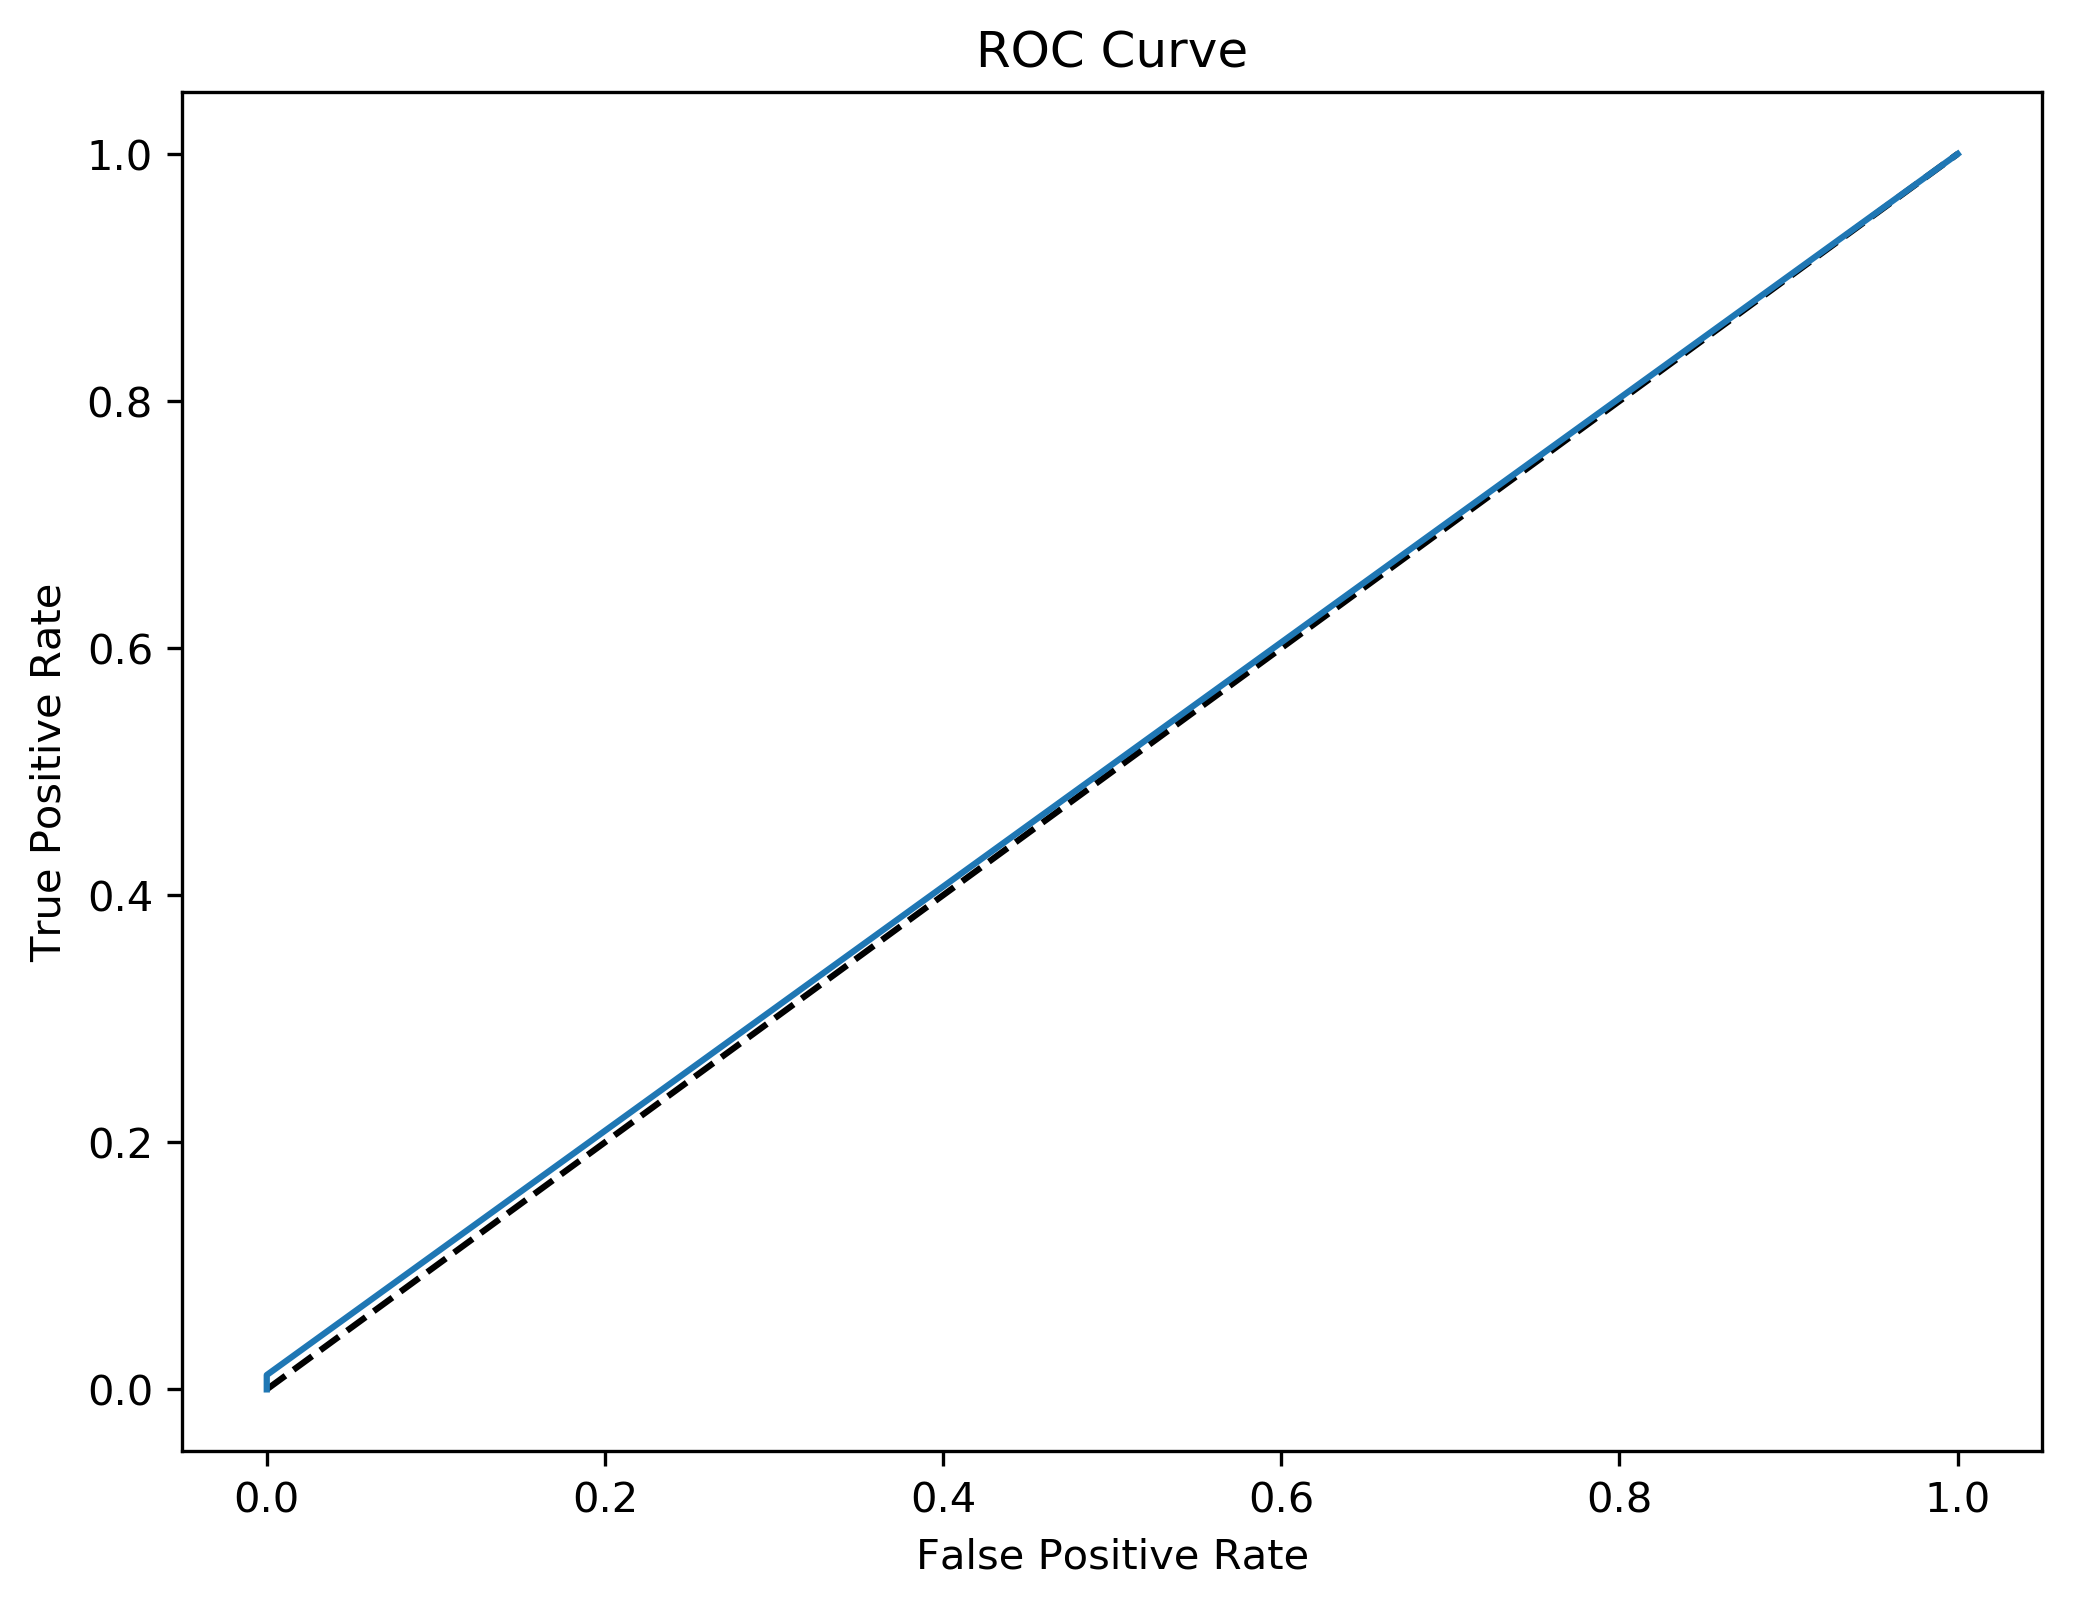

In [146]:
import datetime
starttime = datetime.datetime.now()
mm = MN(44,22,5,1,activation='sigmoid')
mm.train(X_std,y_train,0.001,iteration = 3000)
endtime = datetime.datetime.now()
print('Runing time : ', (endtime - starttime))
mm.predict(test_x,test_y)


In [69]:
def getNumbernode(nodeList= [100,100,1],act = 'sigmoid',lr = 0.001,iteration = 1500):
    loss_list = []
    for i in range(nodeList[0]):
        
        for j in range(nodeList[1]):
            mm = MN(44,i+1,j+1,1,activation = act)
            mm.train(X_std,y_train,lr,iteration)
            loss_list.append([i+1,j+1,mm.losses[-1]])
    
    mse = [x[2] for x in loss_list]
    minmse =  min(mse)
    _ = mse.index(minmse)
    print('first nodes : ',loss_list[_][0],'  second nodes : ',loss_list[_][1])
    return loss_list[_]  

## Stucture

In [70]:
test = getNumbernode()

Epoch:  0| 1500 | train loss: 0.2665
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2863
Epoch:  100| 1500 | train loss: 0.2531
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | tra

Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.3075
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2658
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2646
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 |

Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2490
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2553
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | tr

Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2987
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2666
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500

Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2652
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2707
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 |

Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.3158
Epoch:  100| 1500 | train loss: 0.2785
Epoch:  200| 1500 | train loss: 0.2604
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.3775
Epoch:  100| 1500 | train loss: 0.2667
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | tra

Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2878
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2727
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2718
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 |

Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2710
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2841
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2826
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2573
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2698
Epoch:  100| 1500 | train loss: 0.2564
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2901
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2617
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2770
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2529
Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2577
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2828
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2898
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500 | train loss: 0.2482
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 

Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2970
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2743
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 | train loss: 0.2535
Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2886
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2545
Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | train loss: 0.2545
Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.3006
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2675
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2693
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2509
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2470
Epoch:  600| 1500 | train loss: 0.2470
Epoch:  700| 1500 | train loss: 0.2470
Epoch:  800| 1500 | train loss: 0.2470
Epoch:  900| 1500 | train loss: 0.2470
Epoch:  1000| 1500 | train loss: 0.2470
Epoch:  1100| 1500 | train loss: 0.2470
Epoch:  1200| 1500 | train loss: 0.2470
Epoch:  1300| 1500 | train loss: 0.2470
Epoch:  1400| 1500 | train loss: 0.2470
Epoch:  0| 1500 | train loss: 0.2455
Epoch:  100| 1500 | train loss: 0.2446
Epoch:  200| 1500 | train loss: 0.2446
Epoch:  300| 1500 | train loss: 0.2446
Epoch:  400| 1500 | train loss: 0.2446
Epoch:  500| 1500 | train loss: 0.2446
Epoch:  600| 1500 | train loss: 0.2446
Epoch:  700| 1500 | train loss: 0.2446
Epoch:  800| 1500 | train loss: 0.2446
Epoch:  900| 1500 | train loss: 0.2446
Epoch:  1000| 1500 | train loss: 0.2446
Epoch:  1100| 1500 | train loss: 0.2446
Epoch:  1200| 1500 | train loss: 0.2446
Epoch:  1300| 1500 | train loss: 0.2446
Epoch:  1400| 1500 | train loss: 0.2446
Epoch:  0| 1500 |

Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2554
Epoch:  100| 1500 | train loss: 0.2549
Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2606
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2957
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | 

Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 | train loss: 0.2463
Epoch:  1300| 1500 | train loss: 0.2463
Epoch:  1400| 1500 | train loss: 0.2463
Epoch:  0| 1500 | train loss: 0.2642
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2618
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2547
Epoch:  300| 1500 | train loss: 0.2547
Epoch:  400| 1500 | train loss: 0.2547
Epoch:  500| 1500 | train loss: 0.2547
Epoch:  600| 1500 | train loss: 0.2547
Epoch:  700| 1500 | train loss: 0.2547
Epoch:  800| 1500 | train loss: 0.2547
Epoch:  900| 1500 | train loss: 0.2547
Epoch:  1000| 1500 | train loss: 0.2547
Epoch:  1100| 1500 | train loss: 0.2547
Epoch:  1200| 1500 | train loss: 0.2547
Epoch:  1300| 1500 | train loss: 0.2547
Epoch:  1400| 1500 | train loss: 0.2547
Epoch:  0| 1500 | train loss: 0.2590
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 |

Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2804
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 | train loss: 0.2554
Epoch:  500| 1500 | train loss: 0.2554
Epoch:  600| 1500 | train loss: 0.2554
Epoch:  700| 1500 | train loss: 0.2554
Epoch:  800| 1500 | train loss: 0.2554
Epoch:  900| 1500 | train loss: 0.2554
Epoch:  1000| 1500 | train loss: 0.2554
Epoch:  1100| 1500 | train loss: 0.2554
Epoch:  1200| 1500 | train loss: 0.2554
Epoch:  1300| 1500 | train loss: 0.2554
Epoch:  1400| 1500 | train loss: 0.2554
Epoch:  0| 1500 | train loss: 0.2614
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2551
Epoch:  100| 1500 | train loss: 0.2455
Epoch:  200| 1500 | train loss: 0.2455
Epoch:  300| 1500 | train loss: 0.2455
Epoch:  400| 1500 | train loss: 0.2455
Epoch:  500| 1500 | train loss: 0.2455
Epoch:  600| 1500 | train loss: 0.2455
Epoch:  700| 1500 | train loss: 0.2455
Epoch:  800| 1500 | train loss: 0.2455
Epoch:  900| 1500 | train loss: 0.2455
Epoch:  1000| 1500 | train loss: 0.2455
Epoch:  1100| 1500 | train loss: 0.2455
Epoch:  1200| 1500 | train loss: 0.2455
Epoch:  1300| 1500 | train loss: 0.2455
Epoch:  1400| 1500 | train loss: 0.2455
Epoch:  0| 1500 | train loss: 0.2721
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | tr

Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2497
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2752
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | 

Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2541
Epoch:  800| 1500 | train loss: 0.2541
Epoch:  900| 1500 | train loss: 0.2541
Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 |

Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.3013
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.3026
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2450
Epoch:  1300| 1500 | train loss: 0.2450
Epoch:  1400| 1500 | train loss: 0.2450
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | t

Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2634
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2589
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | t

Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2516
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2524
Epoch:  100| 1500 |

Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.3140
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 |

Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2498
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2823
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | tr

Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2493
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2659
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2483
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | 

Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2545
Epoch:  200| 1500 | train loss: 0.2545
Epoch:  300| 1500 | train loss: 0.2545
Epoch:  400| 1500 | train loss: 0.2545
Epoch:  500| 1500 | train loss: 0.2545
Epoch:  600| 1500 | train loss: 0.2545
Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | train loss: 0.2545
Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2596
Epoch:  100| 1500 | train loss: 0.2588
Epoch:  200| 1500 | train loss: 0.2588
Epoch:  300| 1500 | train loss: 0.2588
Epoch:  400| 1500 | train loss: 0.2588
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2443
Epoch:  1100| 1500 | train loss: 0.2443
Epoch:  1200| 1500 | train loss: 0.2443
Epoch:  1300| 1500 | train loss: 0.2443
Epoch:  1400| 1500 | train loss: 0.2443
Epoch:  0| 1500 | train loss: 0.2639
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2759
Epoch:  100| 1500 | train loss: 0.2380
Epoch:  200| 1500 | train loss: 0.2380
Epoch:  300| 1500 | train loss: 0.2380
Epoch:  400| 1500 | train loss: 0.2380
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2535
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2535
Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | t

Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2765
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | train loss: 0.2540
Epoch:  1100| 1500 | train loss: 0.2540
Epoch:  1200| 1500 | train loss: 0.2540
Epoch:  1300| 1500 | train loss: 0.2540
Epoch:  1400| 1500 | train loss: 0.2540
Epoch:  0| 1500 | train loss: 0.2753
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | tr

Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2458
Epoch:  100| 1500 | train loss: 0.2448
Epoch:  200| 1500 | train loss: 0.2448
Epoch:  300| 1500 | train loss: 0.2448
Epoch:  400| 1500 | train loss: 0.2448
Epoch:  500| 1500 | train loss: 0.2448
Epoch:  600| 1500 | train loss: 0.2448
Epoch:  700| 1500 | train loss: 0.2448
Epoch:  800| 1500 | train loss: 0.2448
Epoch:  900| 1500 | train loss: 0.2448
Epoch:  1000| 1500 | train loss: 0.2448
Epoch:  1100| 1500 | train loss: 0.2448
Epoch:  1200| 1500 | train loss: 0.2448
Epoch:  1300| 1500 

Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2887
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.3072
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2577
Epoch:  100| 1500 | train loss: 0.2575
Epoch:  200| 1500 | train loss: 0.2575
Epoch:  300| 1500 | train loss: 0.2575
Epoch:  400| 1500 | train loss: 0.2575
Epoch:  500| 1500 | train loss: 0.2575
Epoch:  600| 1500 | train loss: 0.2575
Epoch:  700| 1500 | train loss: 0.2575
Epoch:  800| 1500 | train loss: 0.2575
Epoch:  900| 1500 | train loss: 0.2575
Epoch:  1000| 1500 | train loss: 0.2575
Epoch:  1100| 1500 | train loss: 0.2575
Epoch:  1200| 1500 | train loss: 0.2575
Epoch:  1300| 1500 | train loss: 0.2575
Epoch:  1400| 1500 | train loss: 0.2575
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2569
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500 | train loss: 0.2464
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2510
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2498
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2587
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2612
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2644
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2640
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2797
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2684
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2823
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2607
Epoch:  100| 1500 |

Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2551
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2810
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | tr

Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2589
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2534
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.3177
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 | train loss: 0.2463
Epoch:  1300| 1500 | train loss: 0.2463
Epoch:  1400| 1500 | train loss: 0.2463
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2817
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | train loss: 0.2539
Epoch:  700| 1500 | train loss: 0.2539
Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2776
Epoch:  100| 1500 | train loss: 0.2563
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 |

Epoch:  1200| 1500 | train loss: 0.2547
Epoch:  1300| 1500 | train loss: 0.2547
Epoch:  1400| 1500 | train loss: 0.2547
Epoch:  0| 1500 | train loss: 0.2658
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | t

Epoch:  200| 1500 | train loss: 0.2544
Epoch:  300| 1500 | train loss: 0.2544
Epoch:  400| 1500 | train loss: 0.2544
Epoch:  500| 1500 | train loss: 0.2544
Epoch:  600| 1500 | train loss: 0.2544
Epoch:  700| 1500 | train loss: 0.2544
Epoch:  800| 1500 | train loss: 0.2544
Epoch:  900| 1500 | train loss: 0.2544
Epoch:  1000| 1500 | train loss: 0.2544
Epoch:  1100| 1500 | train loss: 0.2544
Epoch:  1200| 1500 | train loss: 0.2544
Epoch:  1300| 1500 | train loss: 0.2544
Epoch:  1400| 1500 | train loss: 0.2544
Epoch:  0| 1500 | train loss: 0.2584
Epoch:  100| 1500 | train loss: 0.2549
Epoch:  200| 1500 | train loss: 0.2550
Epoch:  300| 1500 | train loss: 0.2550
Epoch:  400| 1500 | train loss: 0.2550
Epoch:  500| 1500 | train loss: 0.2550
Epoch:  600| 1500 | train loss: 0.2550
Epoch:  700| 1500 | train loss: 0.2550
Epoch:  800| 1500 | train loss: 0.2550
Epoch:  900| 1500 | train loss: 0.2550
Epoch:  1000| 1500 | train loss: 0.2550
Epoch:  1100| 1500 | train loss: 0.2550
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2750
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 | train loss: 0.2554
Epoch:  500| 1500 | train loss: 0.2554
Epoch:  600| 1500 | train loss: 0.2554
Epoch:  700| 1500 | train loss: 0.2554
Epoch:  800| 1500 | train loss: 0.2554
Epoch:  900| 1500 | train loss: 0.2554
Epoch:  1000| 1500 | train loss: 0.2554
Epoch:  1100| 1500 | train loss: 0.2554
Epoch:  1200| 1500 | train loss: 0.2554
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2708
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 

Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.3496
Epoch:  100| 1500 | train loss: 0.2866
Epoch:  200| 1500 | train loss: 0.2595
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2551
Epoch:  300| 1500 | train loss: 0.2551
Epoch:  400| 1500 | train loss: 0.2551
Epoch:  500| 1500 | train loss: 0.2551
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2480
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | t

Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2750
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.3012
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2670
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 

Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.3149
Epoch:  100| 1500 | train loss: 0.2623
Epoch:  200| 1500 | train loss: 0.2587
Epoch:  300| 1500 | train loss: 0.2583
Epoch:  400| 1500 | train loss: 0.2583
Epoch:  500| 1500 | train loss: 0.2583
Epoch:  600| 1500 | train loss: 0.2583
Epoch:  700| 1500 | train loss: 0.2583
Epoch:  800| 1500 | train loss: 0.2583
Epoch:  900| 1500 | train loss: 0.2583
Epoch:  1000| 1500 | train loss: 0.2583
Epoch:  1100| 1500 | train loss: 0.2583
Epoch:  1200| 1500 | train loss: 0.2583
Epoch:  1300| 1500 | train loss: 0.2583
Epoch:  1400| 1500 | train loss: 0.2583
Epoch:  0| 1500 | train loss: 0.2485
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.3091
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 |

Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2569
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2966
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | t

Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | 

Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2509
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2555
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2982
Epoch:  100| 1500 | train loss: 0.2691
Epoch:  200| 1500 | train loss: 0.2573
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.3166
Epoch:  100| 1500 | train loss: 0.2677
Epoch:  200| 1500 | train loss: 0.2576
Epoch:  300| 1500 | train loss: 0.2551
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2624
Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2587
Epoch:  100| 1500 | train loss: 0.2579
Epoch:  200| 1500 | train loss: 0.2579
Epoch:  300| 1500 | train loss: 0.2579
Epoch:  400| 1500 | train loss: 0.2579
Epoch:  500| 1500 | train loss: 0.2579
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2592
Epoch:  100| 1500 | train loss: 0.2553
Epoch:  200| 1500 | train loss: 0.2553
Epoch:  300| 1500 | train loss: 0.2553
Epoch:  400| 1500 | train loss: 0.2553
Epoch:  500| 1500 | train loss: 0.2553
Epoch:  600| 1500 | train loss: 0.2553
Epoch:  700| 1500 | train loss: 0.2553
Epoch:  800| 1500 | train loss: 0.2553
Epoch:  900| 1500 | train loss: 0.2553
Epoch:  1000| 1500 | train loss: 0.2553
Epoch:  1100| 1500 | train loss: 0.2553
Epoch:  1200| 1500 | train loss: 0.2553
Epoch:  1300| 1500 | train loss: 0.2553
Epoch:  1400| 1500 | train loss: 0.2553
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | tra

Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2812
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2710
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 | train loss: 0.2554
Epoch:  500| 1500 | train loss: 0.2554
Epoch:  600| 1500 | train loss: 0.2554
Epoch:  700| 1500 | train loss: 0.2554
Epoch:  800| 1500 | train loss: 0.2554
Epoch:  900| 1500 | train loss: 0.2554
Epoch:  1000| 1500 | train loss: 0.2554
Epoch:  1100| 1500 | train loss: 0.2554
Epoch:  1200| 1500 | train loss: 0.2554
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2455
Epoch:  500| 1500 | train loss: 0.2455
Epoch:  600| 1500 | train loss: 0.2455
Epoch:  700| 1500 | train loss: 0.2455
Epoch:  800| 1500 | train loss: 0.2455
Epoch:  900| 1500 | train loss: 0.2455
Epoch:  1000| 1500 | train loss: 0.2455
Epoch:  1100| 1500 | train loss: 0.2455
Epoch:  1200| 1500 | train loss: 0.2455
Epoch:  1300| 1500 | train loss: 0.2455
Epoch:  1400| 1500 | train loss: 0.2455
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2565
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2532
Epoch:  600| 1500 | train loss: 0.2532
Epoch:  700| 1500 | train loss: 0.2532
Epoch:  800| 1500 | train loss: 0.2532
Epoch:  900| 1500 | train loss: 0.2532
Epoch:  1000| 1500 | train loss: 0.2532
Epoch:  1100| 1500 | train loss: 0.2532
Epoch:  1200| 1500 | train loss: 0.2532
Epoch:  1300| 1500 | train loss: 0.2532
Epoch:  1400| 1500 | train loss: 0.2532
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 | train loss: 0.2552
Epoch:  300| 1500 | train loss: 0.2552
Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2820
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2649
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2497
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.3421
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.3243
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2820
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2645
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2449
Epoch:  1100| 1500 | train loss: 0.2449
Epoch:  1200| 1500 | train loss: 0.2449
Epoch:  1300| 1500 | train loss: 0.2449
Epoch:  1400| 1500 | train loss: 0.2449
Epoch:  0| 1500 | train loss: 0.2626
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2740
Epoch:  100| 1500 | train loss: 0.2558
Epoch:  200| 1500 | train loss: 0.2558
Epoch:  300| 1500 | train loss: 0.2558
Epoch:  400| 1500 | train loss: 0.2558
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2619
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2667
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2592
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2714
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2454
Epoch:  400| 1500 | train loss: 0.2454
Epoch:  500| 1500 | train loss: 0.2454
Epoch:  600| 1500 | train loss: 0.2454
Epoch:  700| 1500 | train loss: 0.2454
Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | tra

Epoch:  500| 1500 | train loss: 0.2467
Epoch:  600| 1500 | train loss: 0.2467
Epoch:  700| 1500 | train loss: 0.2467
Epoch:  800| 1500 | train loss: 0.2467
Epoch:  900| 1500 | train loss: 0.2467
Epoch:  1000| 1500 | train loss: 0.2467
Epoch:  1100| 1500 | train loss: 0.2467
Epoch:  1200| 1500 | train loss: 0.2467
Epoch:  1300| 1500 | train loss: 0.2467
Epoch:  1400| 1500 | train loss: 0.2467
Epoch:  0| 1500 | train loss: 0.2651
Epoch:  100| 1500 | train loss: 0.2603
Epoch:  200| 1500 | train loss: 0.2603
Epoch:  300| 1500 | train loss: 0.2603
Epoch:  400| 1500 | train loss: 0.2603
Epoch:  500| 1500 | train loss: 0.2603
Epoch:  600| 1500 | train loss: 0.2603
Epoch:  700| 1500 | train loss: 0.2603
Epoch:  800| 1500 | train loss: 0.2603
Epoch:  900| 1500 | train loss: 0.2603
Epoch:  1000| 1500 | train loss: 0.2603
Epoch:  1100| 1500 | train loss: 0.2603
Epoch:  1200| 1500 | train loss: 0.2603
Epoch:  1300| 1500 | train loss: 0.2603
Epoch:  1400| 1500 | train loss: 0.2603
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2542
Epoch:  900| 1500 | train loss: 0.2542
Epoch:  1000| 1500 | train loss: 0.2542
Epoch:  1100| 1500 | train loss: 0.2542
Epoch:  1200| 1500 | train loss: 0.2542
Epoch:  1300| 1500 | train loss: 0.2542
Epoch:  1400| 1500 | train loss: 0.2542
Epoch:  0| 1500 | train loss: 0.2560
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2799
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2636
Epoch:  100| 1500 | train loss: 0.2542
Epoch:  200| 1500 | train loss: 0.2542
Epoch:  300| 1500 | train loss: 0.2542
Epoch:  400| 1500 | train loss: 0.2542
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2587
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2458
Epoch:  100| 1500 | train loss: 0.2446
Epoch:  200| 1500 | train loss: 0.2446
Epoch:  300| 1500 | train loss: 0.2446
Epoch:  400| 1500 | train loss: 0.2446
Epoch:  500| 1500 | train loss: 0.2446
Epoch:  600| 1500 | train loss: 0.2446
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2833
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2753
Epoch:  100| 1500 | train loss: 0.2558
Epoch:  200| 1500 | train loss: 0.2557
Epoch:  300| 1500 | train loss: 0.2558
Epoch:  400| 1500 | train loss: 0.2558
Epoch:  500| 1500 | train loss: 0.2558
Epoch:  600| 1500 | train loss: 0.2558
Epoch:  700| 1500 | train loss: 0.2558
Epoch:  800| 1500 | train loss: 0.2558
Epoch:  900| 1500 | train loss: 0.2558
Epoch:  1000| 1500 | train loss: 0.2558
Epoch:  1100| 1500 | train loss: 0.2558
Epoch:  1200| 1500 | train loss: 0.2558
Epoch:  1300| 1500 | train loss: 0.2558
Epoch:  1400| 1500 | train loss: 0.2558
Epoch:  0| 1500 | train loss: 0.2911
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2451
Epoch:  300| 1500 | train loss: 0.2451
Epoch:  400| 1500 | train loss: 0.2451
Epoch:  500| 1500 | train loss: 0.2451
Epoch:  600| 1500 | train loss: 0.2451
Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | tra

Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2573
Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | train loss: 0.2540
Epoch:  1100| 1500 | train loss: 0.2540
Epoch:  1200| 1500 | train loss: 0.2540
Epoch:  1300| 1500 | train loss: 0.2540
Epoch:  1400| 1500 | train loss: 0.2540
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2737
Epoch:  100| 1500 | train loss: 0.2568
Epoch:  200| 1500 | train loss: 0.2568
Epoch:  300| 1500 | train loss: 0.2568
Epoch:  400| 1500 | train loss: 0.2568
Epoch:  500| 1500 | train loss: 0.2568
Epoch:  600| 1500 | train loss: 0.2568
Epoch:  700| 1500 | train loss: 0.2568
Epoch:  800| 1500 | train loss: 0.2568
Epoch:  900| 1500 | train loss: 0.2568
Epoch:  1000| 1500 | train loss: 0.2568
Epoch:  1100| 1500 | train loss: 0.2568
Epoch:  1200| 1500 | train loss: 0.2568
Epoch:  1300| 1500 | train loss: 0.2568
Epoch:  1400| 1500

Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2468
Epoch:  100| 1500 | train loss: 0.2422
Epoch:  200| 1500 | train loss: 0.2422
Epoch:  300| 1500 | train loss: 0.2422
Epoch:  400| 1500 | train loss: 0.2422
Epoch:  500| 1500 | train loss: 0.2422
Epoch:  600| 1500 | train loss: 0.2422
Epoch:  700| 1500 | train loss: 0.2422
Epoch:  800| 1500 | train loss: 0.2422
Epoch:  900| 1500 | train loss: 0.2422
Epoch:  1000| 1500 | train loss: 0.2422
Epoch:  1100| 1500 | train loss: 0.2422
Epoch:  1200| 1500 | train loss: 0.2422
Epoch:  1300| 1500 | train loss: 0.2422
Epoch:  1400| 1500 | train loss: 0.2422
Epoch:  0| 1500 | train loss: 0.2587
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2620
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2845
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2878
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.3000
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2585
Epoch:  1100| 1500 | train loss: 0.2585
Epoch:  1200| 1500 | train loss: 0.2585
Epoch:  1300| 1500 | train loss: 0.2585
Epoch:  1400| 1500 | train loss: 0.2585
Epoch:  0| 1500 | train loss: 0.2642
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2945
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2873
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.3059
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2777
Epoch:  100| 1500 | train loss: 0.2470
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 | train loss: 0.2470
Epoch:  400| 1500 | train loss: 0.2470
Epoch:  500| 1500 | train loss: 0.2470
Epoch:  600| 1500 | train loss: 0.2470
Epoch:  700| 1500 | train loss: 0.2470
Epoch:  800| 1500 | train loss: 0.2470
Epoch:  900| 1500 | train loss: 0.2470
Epoch:  1000| 1500 | train loss: 0.2470
Epoch:  1100| 1500 | train loss: 0.2470
Epoch:  1200| 1500 | train loss: 0.2470
Epoch:  1300| 1500 | train loss: 0.2470
Epoch:  1400| 1500 | train loss: 0.2470
Epoch:  0| 1500 | train loss: 0.2627
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 |

Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2693
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2611
Epoch:  100| 1500 | train loss: 0.2545
Epoch:  200| 1500 | train loss: 0.2545
Epoch:  300| 1500 | train loss: 0.2545
Epoch:  400| 1500 | train loss: 0.2545
Epoch:  500| 1500 | train loss: 0.2545
Epoch:  600| 1500 | train loss: 0.2545
Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | train loss: 0.2545
Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2441
Epoch:  100| 1500 | train loss: 0.2440
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2505
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2711
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2534
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2584
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2791
Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 | train loss: 0.2456
Epoch:  300| 1500 | train loss: 0.2456
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 | train loss: 0.2463
Epoch:  1300| 1500 | train loss: 0.2463
Epoch:  1400| 1500 | train loss: 0.2463
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2505
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2784
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2549
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2475
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2823
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 

Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2817
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2641
Epoch:  100| 1500 | train loss: 0.2435
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2550
Epoch:  100| 1500 | train loss: 0.2531
Epoch:  200| 1500 | train loss: 0.2531
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500 | train loss: 0.2482
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2965
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 |

Epoch:  1200| 1500 | train loss: 0.2338
Epoch:  1300| 1500 | train loss: 0.2338
Epoch:  1400| 1500 | train loss: 0.2338
Epoch:  0| 1500 | train loss: 0.2591
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2549
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.3370
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2652
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500 | train loss: 0.2482
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2564
Epoch:  200| 1500 | train loss: 0.2564
Epoch:  300| 1500 | train loss: 0.2564
Epoch:  400| 1500 | train loss: 0.2564
Epoch:  500| 1500 | train loss: 0.2564
Epoch:  600| 1500 | train loss: 0.2564
Epoch:  700| 1500 | train loss: 0.2564
Epoch:  800| 1500 | train loss: 0.2564
Epoch:  900| 1500 | tra

Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2644
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | train loss: 0.2539
Epoch:  700| 1500 | train loss: 0.2539
Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2639
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.3004
Epoch:  100| 1500 | train loss: 0.2532
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2672
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2492
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2822
Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 | train loss: 0.2456
Epoch:  300| 1500 | train loss: 0.2456
Epoch:  400| 1500 | train loss: 0.2456
Epoch:  500| 1500 | train loss: 0.2456
Epoch:  600| 1500 | train loss: 0.2456
Epoch:  700| 1500 | train loss: 0.2456
Epoch:  800| 1500 | train loss: 0.2456
Epoch:  900| 1500 | train loss: 0.2456
Epoch:  1000| 1500 | train loss: 0.2456
Epoch:  1100| 1500 | train loss: 0.2456
Epoch:  1200| 1500 | train loss: 0.2456
Epoch:  1300| 1500 | train loss: 0.2456
Epoch:  1400| 1500 | train loss: 0.2456
Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2545
Epoch:  200| 1500 | train loss: 0.2545
Epoch:  300| 1500 | train loss: 0.2545
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2489
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2560
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2543
Epoch:  1000| 1500 | train loss: 0.2543
Epoch:  1100| 1500 | train loss: 0.2543
Epoch:  1200| 1500 | train loss: 0.2543
Epoch:  1300| 1500 | train loss: 0.2543
Epoch:  1400| 1500 | train loss: 0.2543
Epoch:  0| 1500 | train loss: 0.2479
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2601
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2595
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2711
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2705
Epoch:  100| 1500 | train loss: 0.2570
Epoch:  200| 1500 | train loss: 0.2569
Epoch:  300| 1500 | train loss: 0.2569
Epoch:  400| 1500 | train loss: 0.2569
Epoch:  500| 1500 | train loss: 0.2569
Epoch:  600| 1500 | 

Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2486
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2869
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2467
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2476
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2449
Epoch:  500| 1500 | train loss: 0.2449
Epoch:  600| 1500 | train loss: 0.2449
Epoch:  700| 1500 | train loss: 0.2449
Epoch:  800| 1500 | train loss: 0.2449
Epoch:  900| 1500 | train loss: 0.2449
Epoch:  1000| 1500 | train loss: 0.2449
Epoch:  1100| 1500 | train loss: 0.2449
Epoch:  1200| 1500 | train loss: 0.2449
Epoch:  1300| 1500 | train loss: 0.2449
Epoch:  1400| 1500 | train loss: 0.2449
Epoch:  0| 1500 | train loss: 0.2567
Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 | train loss: 0.2552
Epoch:  300| 1500 | train loss: 0.2552
Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2449
Epoch:  700| 1500 | train loss: 0.2449
Epoch:  800| 1500 | train loss: 0.2449
Epoch:  900| 1500 | train loss: 0.2449
Epoch:  1000| 1500 | train loss: 0.2449
Epoch:  1100| 1500 | train loss: 0.2449
Epoch:  1200| 1500 | train loss: 0.2449
Epoch:  1300| 1500 | train loss: 0.2449
Epoch:  1400| 1500 | train loss: 0.2449
Epoch:  0| 1500 | train loss: 0.2552
Epoch:  100| 1500 | train loss: 0.2543
Epoch:  200| 1500 | train loss: 0.2543
Epoch:  300| 1500 | train loss: 0.2543
Epoch:  400| 1500 | train loss: 0.2543
Epoch:  500| 1500 | train loss: 0.2543
Epoch:  600| 1500 | train loss: 0.2543
Epoch:  700| 1500 | train loss: 0.2543
Epoch:  800| 1500 | train loss: 0.2543
Epoch:  900| 1500 | train loss: 0.2543
Epoch:  1000| 1500 | train loss: 0.2543
Epoch:  1100| 1500 | train loss: 0.2543
Epoch:  1200| 1500 | train loss: 0.2543
Epoch:  1300| 1500 | train loss: 0.2543
Epoch:  1400| 1500 | train loss: 0.2543
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 | train loss: 0.2574
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2485
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2497
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2851
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2749
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2673
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 | train loss: 0.2546
Epoch:  500| 1500 | train loss: 0.2546
Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.3457
Epoch:  100| 1500 | train loss: 0.3049
Epoch:  200| 1500 |

Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2463
Epoch:  100| 1500 | train loss: 0.2452
Epoch:  200| 1500 | train loss: 0.2452
Epoch:  300| 1500 | train loss: 0.2452
Epoch:  400| 1500 | train loss: 0.2452
Epoch:  500| 1500 | train loss: 0.2452
Epoch:  600| 1500 | train loss: 0.2452
Epoch:  700| 1500 | train loss: 0.2452
Epoch:  800| 1500 | train loss: 0.2452
Epoch:  900| 1500 | train loss: 0.2452
Epoch:  1000| 1500 | train loss: 0.2452
Epoch:  1100| 1500 | train loss: 0.2452
Epoch:  1200| 1500 | train loss: 0.2452
Epoch:  1300| 1500 | train loss: 0.2452
Epoch:  1400| 1500 | train loss: 0.2452
Epoch:  0| 1500 | train loss: 0.2815
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | 

Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2550
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2451
Epoch:  600| 1500 | train loss: 0.2451
Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | train loss: 0.2451
Epoch:  1100| 1500 | train loss: 0.2451
Epoch:  1200| 1500 | train loss: 0.2451
Epoch:  1300| 1500 | train loss: 0.2451
Epoch:  1400| 1500 | train loss: 0.2451
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 | train loss: 0.2549
Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 | train loss: 0.2463
Epoch:  1300| 1500 | train loss: 0.2463
Epoch:  1400| 1500 | train loss: 0.2463
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2538
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2599
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2489
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2526
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2833
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 | train loss: 0.2546
Epoch:  500| 1500 | train loss: 0.2546
Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2813
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2624
Epoch:  100| 1500 | train loss: 0.2464
Epoch:  200| 1500 | train loss: 0.2464
Epoch:  300| 1500 | train loss: 0.2464
Epoch:  400| 1500 | train loss: 0.2464
Epoch:  500| 1500 | train loss: 0.2464
Epoch:  600| 1500 | train loss: 0.2464
Epoch:  700| 1500 | train loss: 0.2464
Epoch:  800| 1500 | train loss: 0.2464
Epoch:  900| 1500 | train loss: 0.2464
Epoch:  1000| 1500 | train loss: 0.2464
Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2488
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.3326
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2714
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2603
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2611
Epoch:  100| 1500 | train loss: 0.2570
Epoch:  200| 1500 | train loss: 0.2570
Epoch:  300| 1500 | train loss: 0.2570
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2557
Epoch:  1100| 1500 | train loss: 0.2557
Epoch:  1200| 1500 | train loss: 0.2557
Epoch:  1300| 1500 | train loss: 0.2557
Epoch:  1400| 1500 | train loss: 0.2557
Epoch:  0| 1500 | train loss: 0.3211
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2544
Epoch:  300| 1500 | train loss: 0.2544
Epoch:  400| 1500 | train loss: 0.2544
Epoch:  500| 1500 | train loss: 0.2544
Epoch:  600| 1500 | train loss: 0.2544
Epoch:  700| 1500 | train loss: 0.2544
Epoch:  800| 1500 | train loss: 0.2544
Epoch:  900| 1500 | train loss: 0.2544
Epoch:  1000| 1500 | train loss: 0.2544
Epoch:  1100| 1500 | train loss: 0.2544
Epoch:  1200| 1500 | train loss: 0.2544
Epoch:  1300| 1500 | train loss: 0.2544
Epoch:  1400| 1500 | train loss: 0.2544
Epoch:  0| 1500 | train loss: 0.2625
Epoch:  100| 1500 | train loss: 0.2560
Epoch:  200| 1500 | train loss: 0.2560
Epoch:  300| 1500 | train loss: 0.2560
Epoch:  400| 1500 | train loss: 0.2560
Epoch:  500| 1500 |

Epoch:  1400| 1500 | train loss: 0.2572
Epoch:  0| 1500 | train loss: 0.2468
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2824
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.3384
Epoch:  100| 1500 | train loss: 0.2567
Epoch:  200| 1500 | train loss: 0.2567
Epoch:  300| 1500 | train loss: 0.2567
Epoch:  400| 1500 | train loss: 0.2567
Epoch:  500| 1500 | train loss: 0.2567
Epoch:  600| 1500 | train loss: 0.2567
Epoch:  700| 1500 | train loss: 0.2567
Epoch:  800| 1500 | train loss: 0.2567
Epoch:  900| 1500 | train loss: 0.2567
Epoch:  1000| 1500 | train loss: 0.2567
Epoch:  1100| 1500 | train loss: 0.2567
Epoch:  1200| 1500 | train loss: 0.2567
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2723
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2534
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2575
Epoch:  1300| 1500 | train loss: 0.2575
Epoch:  1400| 1500 | train loss: 0.2575
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | t

Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2555
Epoch:  200| 1500 | train loss: 0.2555
Epoch:  300| 1500 | train loss: 0.2555
Epoch:  400| 1500 | train loss: 0.2555
Epoch:  500| 1500 | train loss: 0.2555
Epoch:  600| 1500 | train loss: 0.2555
Epoch:  700| 1500 | train loss: 0.2555
Epoch:  800| 1500 | train loss: 0.2555
Epoch:  900| 1500 | train loss: 0.2555
Epoch:  1000| 1500 | train loss: 0.2555
Epoch:  1100| 1500 | train loss: 0.2555
Epoch:  1200| 1500 | train loss: 0.2555
Epoch:  1300| 1500 | train loss: 0.2555
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2470
Epoch:  800| 1500 | train loss: 0.2470
Epoch:  900| 1500 | train loss: 0.2470
Epoch:  1000| 1500 | train loss: 0.2470
Epoch:  1100| 1500 | train loss: 0.2470
Epoch:  1200| 1500 | train loss: 0.2470
Epoch:  1300| 1500 | train loss: 0.2470
Epoch:  1400| 1500 | train loss: 0.2470
Epoch:  0| 1500 | train loss: 0.2778
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2580
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.3012
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2603
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2526
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2577
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2595
Epoch:  100| 1500 | train loss: 0.2453
Epoch:  200| 1500 | train loss: 0.2453
Epoch:  300| 1500 | train loss: 0.2453
Epoch:  400| 1500 | train loss: 0.2453
Epoch:  500| 1500 | train loss: 0.2453
Epoch:  600| 1500 | train loss: 0.2453
Epoch:  700| 1500 | train loss: 0.2453
Epoch:  800| 1500 | train loss: 0.2453
Epoch:  900| 1500 | train loss: 0.2453
Epoch:  1000| 1500 | train loss: 0.2453
Epoch:  1100| 1500 | train loss: 0.2453
Epoch:  1200| 1500 | train loss: 0.2453
Epoch:  1300| 1500 | train loss: 0.2453
Epoch:  1400| 1500 | train loss: 0.2453
Epoch:  0| 1500 | train loss: 0.2591
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2489
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2532
Epoch:  1400| 1500 | train loss: 0.2532
Epoch:  0| 1500 | train loss: 0.2868
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.3007
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2545
Epoch:  300| 1500 | train loss: 0.2545
Epoch:  400| 1500 | train loss: 0.2545
Epoch:  500| 1500 | train loss: 0.2545
Epoch:  600| 1500 | train loss: 0.2545
Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2792
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2596
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | tra

Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2785
Epoch:  100| 1500 | train loss: 0.2467
Epoch:  200| 1500 | train loss: 0.2467
Epoch:  300| 1500 | train loss: 0.2467
Epoch:  400| 1500 | train loss: 0.2467
Epoch:  500| 1500 | train loss: 0.2467
Epoch:  600| 1500 | train loss: 0.2467
Epoch:  700| 1500 | train loss: 0.2467
Epoch:  800| 1500 | train loss: 0.2467
Epoch:  900| 1500 | train loss: 0.2467
Epoch:  1000| 1500 | train loss: 0.2467
Epoch:  1100| 1500 | train loss: 0.2467
Epoch:  1200| 1500 | train loss: 0.2467
Epoch:  1300| 1500 | train loss: 0.2467
Epoch:  1400| 1500 | train loss: 0.2467
Epoch:  0| 1500 | train loss: 0.2463
Epoch:  100| 1500 | train loss: 0.2461
Epoch:  200| 1500 | train loss: 0.2461
Epoch:  300| 1500 | train loss: 0.2461
Epoch:  400| 1500 | train loss: 0.2461
Epoch:  500| 1500 | train loss: 0.2461
Epoch:  600| 1500 | train loss: 0.2461
Epoch:  700| 1500 | train loss: 0.2461
Epoch:  800| 1500 | train loss: 0.2461
Epoch:  900| 1500 | tra

Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | train loss: 0.2548
Epoch:  700| 1500 | train loss: 0.2548
Epoch:  800| 1500 | train loss: 0.2548
Epoch:  900| 1500 | train loss: 0.2548
Epoch:  1000| 1500 | train loss: 0.2548
Epoch:  1100| 1500 | train loss: 0.2548
Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2551
Epoch:  800| 1500 | train loss: 0.2551
Epoch:  900| 1500 | train loss: 0.2551
Epoch:  1000| 1500 | train loss: 0.2551
Epoch:  1100| 1500 | train loss: 0.2551
Epoch:  1200| 1500 | train loss: 0.2551
Epoch:  1300| 1500 | train loss: 0.2551
Epoch:  1400| 1500 | train loss: 0.2551
Epoch:  0| 1500 | train loss: 0.2430
Epoch:  100| 1500 | train loss: 0.2429
Epoch:  200| 1500 | train loss: 0.2429
Epoch:  300| 1500 | train loss: 0.2429
Epoch:  400| 1500 | train loss: 0.2429
Epoch:  500| 1500 | train loss: 0.2429
Epoch:  600| 1500 | train loss: 0.2429
Epoch:  700| 1500 | train loss: 0.2429
Epoch:  800| 1500 | train loss: 0.2429
Epoch:  900| 1500 | train loss: 0.2429
Epoch:  1000| 1500 | train loss: 0.2429
Epoch:  1100| 1500 | train loss: 0.2429
Epoch:  1200| 1500 | train loss: 0.2429
Epoch:  1300| 1500 | train loss: 0.2429
Epoch:  1400| 1500 | train loss: 0.2429
Epoch:  0| 1500 | train loss: 0.3196
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2586
Epoch:  700| 1500 | train loss: 0.2586
Epoch:  800| 1500 | train loss: 0.2586
Epoch:  900| 1500 | train loss: 0.2586
Epoch:  1000| 1500 | train loss: 0.2586
Epoch:  1100| 1500 | train loss: 0.2586
Epoch:  1200| 1500 | train loss: 0.2586
Epoch:  1300| 1500 | train loss: 0.2586
Epoch:  1400| 1500 | train loss: 0.2586
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2464
Epoch:  200| 1500 | train loss: 0.2464
Epoch:  300| 1500 | train loss: 0.2464
Epoch:  400| 1500 | train loss: 0.2464
Epoch:  500| 1500 | train loss: 0.2464
Epoch:  600| 1500 | train loss: 0.2464
Epoch:  700| 1500 | train loss: 0.2464
Epoch:  800| 1500 | train loss: 0.2464
Epoch:  900| 1500 | train loss: 0.2464
Epoch:  1000| 1500 | train loss: 0.2464
Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500 | train loss: 0.2464
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2680
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2598
Epoch:  100| 1500 |

Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2490
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2722
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2580
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2580
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2806
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2569
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | t

Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2621
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500 | train loss: 0.2482
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | tra

Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2444
Epoch:  100| 1500 | train loss: 0.2434
Epoch:  200| 1500 | train loss: 0.2434
Epoch:  300| 1500 | train loss: 0.2434
Epoch:  400| 1500 | train loss: 0.2434
Epoch:  500| 1500 | train loss: 0.2434
Epoch:  600| 1500 | train loss: 0.2434
Epoch:  700| 1500 | train loss: 0.2434
Epoch:  800| 1500 | train loss: 0.2434
Epoch:  900| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2786
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 

Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 |

Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2851
Epoch:  100| 1500 | train loss: 0.2548
Epoch:  200| 1500 | train loss: 0.2548
Epoch:  300| 1500 | train loss: 0.2548
Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | train loss: 0.2548
Epoch:  700| 1500 | train loss: 0.2548
Epoch:  800| 1500 | train loss: 0.2548
Epoch:  900| 1500 | train loss: 0.2548
Epoch:  1000| 1500 | train loss: 0.2548
Epoch:  1100| 1500 | train loss: 0.2548
Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 |

Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2706
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2454
Epoch:  400| 1500 | train loss: 0.2454
Epoch:  500| 1500 | train loss: 0.2454
Epoch:  600| 1500 | train loss: 0.2454
Epoch:  700| 1500 | train loss: 0.2454
Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.3535
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 

Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2590
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2551
Epoch:  300| 1500 | train loss: 0.2551
Epoch:  400| 1500 | train loss: 0.2551
Epoch:  500| 1500 | train loss: 0.2551
Epoch:  600| 1500 | train loss: 0.2551
Epoch:  700| 1500 | train loss: 0.2551
Epoch:  800| 1500 | train loss: 0.2551
Epoch:  900| 1500 | train loss: 0.2551
Epoch:  1000| 1500 | train loss: 0.2551
Epoch:  1100| 1500 | train loss: 0.2551
Epoch:  1200| 1500 | train loss: 0.2551
Epoch:  1300| 1500 | train loss: 0.2551
Epoch:  1400| 1500 | train loss: 0.2551
Epoch:  0| 1500 | train loss: 0.2969
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2557
Epoch:  100| 1500 | train loss: 0.2455
Epoch:  200| 1500 | train loss: 0.2455
Epoch:  300| 1500 | train loss: 0.2455
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2480
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 |

Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2668
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2454
Epoch:  400| 1500 | train loss: 0.2454
Epoch:  500| 1500 | train loss: 0.2454
Epoch:  600| 1500 | train loss: 0.2454
Epoch:  700| 1500 | train loss: 0.2454
Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2586
Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | 

Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2737
Epoch:  100| 1500 | train loss: 0.2531
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2987
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2630
Epoch:  100| 1500 | train loss: 0.2470
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2434
Epoch:  900| 1500 | train loss: 0.2434
Epoch:  1000| 1500 | train loss: 0.2434
Epoch:  1100| 1500 | train loss: 0.2434
Epoch:  1200| 1500 | train loss: 0.2434
Epoch:  1300| 1500 | train loss: 0.2434
Epoch:  1400| 1500 | train loss: 0.2434
Epoch:  0| 1500 | train loss: 0.2540
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2550
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2637
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2462
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 | train loss: 0.2462
Epoch:  600| 1500 | train loss: 0.2462
Epoch:  700| 1500 | train loss: 0.2462
Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | train loss: 0.2462
Epoch:  1100| 1500 | train loss: 0.2462
Epoch:  1200| 1500 | train loss: 0.2462
Epoch:  1300| 1500 | train loss: 0.2462
Epoch:  1400| 1500 | train loss: 0.2462
Epoch:  0| 1500 | train loss: 0.2474
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 |

Epoch:  1000| 1500 | train loss: 0.2434
Epoch:  1100| 1500 | train loss: 0.2434
Epoch:  1200| 1500 | train loss: 0.2434
Epoch:  1300| 1500 | train loss: 0.2434
Epoch:  1400| 1500 | train loss: 0.2434
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2735
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.3214
Epoch:  100| 1500 | train loss: 0.2553
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2538
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2567
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500 | train loss: 0.2482
Epoch:  0| 1500 | train loss: 0.2497
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 

Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2457
Epoch:  200| 1500 | train loss: 0.2457
Epoch:  300| 1500 | train loss: 0.2457
Epoch:  400| 1500 | train loss: 0.2457
Epoch:  500| 1500 | train loss: 0.2457
Epoch:  600| 1500 | train loss: 0.2457
Epoch:  700| 1500 | train loss: 0.2457
Epoch:  800| 1500 | train loss: 0.2457
Epoch:  900| 1500 | train loss: 0.2457
Epoch:  1000| 1500 | train loss: 0.2457
Epoch:  1100| 1500 | train loss: 0.2457
Epoch:  1200| 1500 | train loss: 0.2457
Epoch:  1300| 1500 | train loss: 0.2457
Epoch:  1400| 1500 | train loss: 0.2457
Epoch:  0| 1500 | train loss: 0.2584
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2696
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2547
Epoch:  100| 1500 | train loss: 0.2529
Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2553
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2751
Epoch:  100| 1500 | train loss: 0.2532
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.3038
Epoch:  100| 1500 | train loss: 0.2565
Epoch:  200| 1500 |

Epoch:  1000| 1500 | train loss: 0.2571
Epoch:  1100| 1500 | train loss: 0.2571
Epoch:  1200| 1500 | train loss: 0.2571
Epoch:  1300| 1500 | train loss: 0.2571
Epoch:  1400| 1500 | train loss: 0.2571
Epoch:  0| 1500 | train loss: 0.2913
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2428
Epoch:  1000| 1500 | train loss: 0.2428
Epoch:  1100| 1500 | train loss: 0.2428
Epoch:  1200| 1500 | train loss: 0.2428
Epoch:  1300| 1500 | train loss: 0.2428
Epoch:  1400| 1500 | train loss: 0.2428
Epoch:  0| 1500 | train loss: 0.2628
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2720
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500 | train loss: 0.2460
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2467
Epoch:  200| 1500 | train loss: 0.2467
Epoch:  300| 1500 | train loss: 0.2467
Epoch:  400| 1500 | train loss: 0.2467
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2531
Epoch:  1000| 1500 | train loss: 0.2531
Epoch:  1100| 1500 | train loss: 0.2531
Epoch:  1200| 1500 | train loss: 0.2531
Epoch:  1300| 1500 | train loss: 0.2531
Epoch:  1400| 1500 | train loss: 0.2531
Epoch:  0| 1500 | train loss: 0.2492
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2768
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2745
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.3146
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.3001
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | tr

Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2648
Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 | train loss: 0.2553
Epoch:  300| 1500 | train loss: 0.2553
Epoch:  400| 1500 | train loss: 0.2553
Epoch:  500| 1500 | train loss: 0.2553
Epoch:  600| 1500 | train loss: 0.2553
Epoch:  700| 1500 | train loss: 0.2553
Epoch:  800| 1500 | train loss: 0.2553
Epoch:  900| 1500 | train loss: 0.2553
Epoch:  1000| 1500 | train loss: 0.2553
Epoch:  1100| 1500 | train loss: 0.2553
Epoch:  1200| 1500 | train loss: 0.2553
Epoch:  1300| 1500 | train loss: 0.2553
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2563
Epoch:  100| 1500 | train loss: 0.2558
Epoch:  200| 1500 | train loss: 0.2558
Epoch:  300| 1500 | train loss: 0.2558
Epoch:  400| 1500 | train loss: 0.2558
Epoch:  500| 1500 | train loss: 0.2558
Epoch:  600| 1500 | train loss: 0.2558
Epoch:  700| 1500 | train loss: 0.2558
Epoch:  800| 1500 | train loss: 0.2558
Epoch:  900| 1500 | train loss: 0.2558
Epoch:  1000| 1500 | train loss: 0.2558
Epoch:  1100| 1500 | train loss: 0.2558
Epoch:  1200| 1500 | train loss: 0.2558
Epoch:  1300| 1500 | train loss: 0.2558
Epoch:  1400| 1500 | train loss: 0.2558
Epoch:  0| 1500 | train loss: 0.2792
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 |

Epoch:  1100| 1500 | train loss: 0.2447
Epoch:  1200| 1500 | train loss: 0.2447
Epoch:  1300| 1500 | train loss: 0.2447
Epoch:  1400| 1500 | train loss: 0.2447
Epoch:  0| 1500 | train loss: 0.2594
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2464
Epoch:  200| 1500 | train loss: 0.2464
Epoch:  300| 1500 | train loss: 0.2464
Epoch:  400| 1500 | train loss: 0.2464
Epoch:  500| 1500 | train loss: 0.2464
Epoch:  600| 1500 | 

Epoch:  0| 1500 | train loss: 0.2788
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2780
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2852
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2443
Epoch:  100| 1500 | train loss: 0.2433
Epoch:  200| 1500 | train loss: 0.2433
Epoch:  300| 1500 | train loss: 0.2433
Epoch:  400| 1500 | train loss: 0.2433
Epoch:  500| 1500 | train loss: 0.2433
Epoch:  600| 1500 | train loss: 0.2433
Epoch:  700| 1500 | train loss: 0.2433
Epoch:  800| 1500 | train loss: 0.2433
Epoch:  900| 1500 | train loss: 0.2433
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2577
Epoch:  100| 1500 | train loss: 0.2445
Epoch:  200| 1500 | train loss: 0.2445
Epoch:  300| 1500 | train loss: 0.2445
Epoch:  400| 1500 | train loss: 0.2445
Epoch:  500| 1500 | train loss: 0.2445
Epoch:  600| 1500 | train loss: 0.2445
Epoch:  700| 1500 | train loss: 0.2445
Epoch:  800| 1500 | train loss: 0.2445
Epoch:  900| 1500 | train loss: 0.2445
Epoch:  1000| 1500 | train loss: 0.2445
Epoch:  1100| 1500 | train loss: 0.2445
Epoch:  1200| 1500 | train loss: 0.2445
Epoch:  1300| 1500 

Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2772
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2580
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2533
Epoch:  100| 1500 |

Epoch:  900| 1500 | train loss: 0.2572
Epoch:  1000| 1500 | train loss: 0.2572
Epoch:  1100| 1500 | train loss: 0.2572
Epoch:  1200| 1500 | train loss: 0.2572
Epoch:  1300| 1500 | train loss: 0.2572
Epoch:  1400| 1500 | train loss: 0.2572
Epoch:  0| 1500 | train loss: 0.2692
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2581
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2471
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2466
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 | train loss: 0.2474
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2464
Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500 | train loss: 0.2464
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2480
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2482
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.3050
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.3064
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2535
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2535
Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2591
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2551
Epoch:  300| 1500 | train loss: 0.2551
Epoch:  400| 1500 | train loss: 0.2551
Epoch:  500| 1500 | train loss: 0.2551
Epoch:  600| 1500 | train loss: 0.2551
Epoch:  700| 1500 | train loss: 0.2551
Epoch:  800| 1500 | train loss: 0.2551
Epoch:  900| 1500 | train loss: 0.2551
Epoch:  1000| 1500 | train loss: 0.2551
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2533
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2557
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2657
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | tra

Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2983
Epoch:  100| 1500 | train loss: 0.2562
Epoch:  200| 1500 | train loss: 0.2559
Epoch:  300| 1500 | train loss: 0.2559
Epoch:  400| 1500 | train loss: 0.2559
Epoch:  500| 1500 | train loss: 0.2559
Epoch:  600| 1500 | train loss: 0.2559
Epoch:  700| 1500 | train loss: 0.2559
Epoch:  800| 1500 | train loss: 0.2559
Epoch:  900| 1500 | train loss: 0.2559
Epoch:  1000| 1500 | train loss: 0.2559
Epoch:  1100| 1500 | train loss: 0.2559
Epoch:  1200| 1500 | train loss: 0.2559
Epoch:  1300| 1500 | train loss: 0.2559
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2662
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2586
Epoch:  700| 1500 | train loss: 0.2586
Epoch:  800| 1500 | train loss: 0.2586
Epoch:  900| 1500 | train loss: 0.2586
Epoch:  1000| 1500 | train loss: 0.2586
Epoch:  1100| 1500 | train loss: 0.2586
Epoch:  1200| 1500 | train loss: 0.2586
Epoch:  1300| 1500 | train loss: 0.2586
Epoch:  1400| 1500 | train loss: 0.2586
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2625
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2660
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2688
Epoch:  100| 1500 |

Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2729
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2561
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2615
Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | train loss: 0.2540
Epoch:  1100| 1500 | train loss: 0.2540
Epoch:  1200| 1500 | train loss: 0.2540
Epoch:  1300| 1500 | train loss: 0.2540
Epoch:  1400| 1500 | train loss: 0.2540
Epoch:  0| 1500 | train loss: 0.2553
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2544
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2603
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 |

Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2546
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2553
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2648
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2675
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | t

Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2603
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2554
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2614
Epoch:  100| 1500 | train loss: 0.2550
Epoch:  200| 1500 | train loss: 0.2550
Epoch:  300| 1500 | train loss: 0.2550
Epoch:  400| 1500 | train loss: 0.2550
Epoch:  500| 1500 | train loss: 0.2550
Epoch:  600| 1500 | train loss: 0.2550
Epoch:  700| 1500 | train loss: 0.2550
Epoch:  800| 1500 | train loss: 0.2550
Epoch:  900| 1500 | train loss: 0.2550
Epoch:  1000| 1500 | train loss: 0.2550
Epoch:  1100| 1500 | train loss: 0.2550
Epoch:  1200| 1500 | train loss: 0.2550
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2692
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2689
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2714
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2414
Epoch:  700| 1500 | train loss: 0.2414
Epoch:  800| 1500 | train loss: 0.2414
Epoch:  900| 1500 | train loss: 0.2414
Epoch:  1000| 1500 | train loss: 0.2414
Epoch:  1100| 1500 | train loss: 0.2414
Epoch:  1200| 1500 | train loss: 0.2414
Epoch:  1300| 1500 | train loss: 0.2414
Epoch:  1400| 1500 | train loss: 0.2414
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 | train loss: 0.2442
Epoch:  200| 1500 | train loss: 0.2442
Epoch:  300| 1500 | train loss: 0.2442
Epoch:  400| 1500 | train loss: 0.2442
Epoch:  500| 1500 | train loss: 0.2442
Epoch:  600| 1500 | train loss: 0.2442
Epoch:  700| 1500 | train loss: 0.2442
Epoch:  800| 1500 | train loss: 0.2442
Epoch:  900| 1500 | train loss: 0.2442
Epoch:  1000| 1500 | train loss: 0.2442
Epoch:  1100| 1500 | train loss: 0.2442
Epoch:  1200| 1500 | train loss: 0.2442
Epoch:  1300| 1500 | train loss: 0.2442
Epoch:  1400| 1500 | train loss: 0.2442
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2524
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2653
Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 | train loss: 0.2456
Epoch:  300| 1500 | train loss: 0.2456
Epoch:  400| 1500 | train loss: 0.2456
Epoch:  500| 1500 | train loss: 0.2456
Epoch:  600| 1500 | train loss: 0.2456
Epoch:  700| 1500 | train loss: 0.2456
Epoch:  800| 1500 | train loss: 0.2456
Epoch:  900| 1500 | train loss: 0.2456
Epoch:  1000| 1500 | train loss: 0.2456
Epoch:  1100| 1500 | train loss: 0.2456
Epoch:  1200| 1500 | train loss: 0.2456
Epoch:  1300| 1500 | train loss: 0.2456
Epoch:  1400| 1500 | train loss: 0.2456
Epoch:  0| 1500 | train loss: 0.2533
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2577
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | train loss: 0.2539
Epoch:  700| 1500 | train loss: 0.2539
Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2648
Epoch:  100| 1500 | train loss: 0.2542
Epoch:  200| 1500 | train loss: 0.2542
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.3357
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2599
Epoch:  100| 1500 | train loss: 0.2562
Epoch:  200| 1500 | train loss: 0.2562
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2574
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 | train loss: 0.2554
Epoch:  500| 1500 | train loss: 0.2554
Epoch:  600| 1500 | train loss: 0.2554
Epoch:  700| 1500 | train loss: 0.2554
Epoch:  800| 1500 | train loss: 0.2554
Epoch:  900| 1500 | train loss: 0.2554
Epoch:  1000| 1500 | train loss: 0.2554
Epoch:  1100| 1500 | train loss: 0.2554
Epoch:  1200| 1500 | train loss: 0.2554
Epoch:  1300| 1500 | train loss: 0.2554
Epoch:  1400| 1500 | train loss: 0.2554
Epoch:  0| 1500 | train loss: 0.2595
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2662
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2698
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 |

Epoch:  1300| 1500 | train loss: 0.2371
Epoch:  1400| 1500 | train loss: 0.2371
Epoch:  0| 1500 | train loss: 0.2463
Epoch:  100| 1500 | train loss: 0.2461
Epoch:  200| 1500 | train loss: 0.2461
Epoch:  300| 1500 | train loss: 0.2461
Epoch:  400| 1500 | train loss: 0.2461
Epoch:  500| 1500 | train loss: 0.2461
Epoch:  600| 1500 | train loss: 0.2461
Epoch:  700| 1500 | train loss: 0.2461
Epoch:  800| 1500 | train loss: 0.2461
Epoch:  900| 1500 | train loss: 0.2461
Epoch:  1000| 1500 | train loss: 0.2461
Epoch:  1100| 1500 | train loss: 0.2461
Epoch:  1200| 1500 | train loss: 0.2461
Epoch:  1300| 1500 | train loss: 0.2461
Epoch:  1400| 1500 | train loss: 0.2461
Epoch:  0| 1500 | train loss: 0.2771
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | tr

Epoch:  1300| 1500 | train loss: 0.2457
Epoch:  1400| 1500 | train loss: 0.2457
Epoch:  0| 1500 | train loss: 0.2617
Epoch:  100| 1500 | train loss: 0.2579
Epoch:  200| 1500 | train loss: 0.2579
Epoch:  300| 1500 | train loss: 0.2579
Epoch:  400| 1500 | train loss: 0.2579
Epoch:  500| 1500 | train loss: 0.2579
Epoch:  600| 1500 | train loss: 0.2579
Epoch:  700| 1500 | train loss: 0.2579
Epoch:  800| 1500 | train loss: 0.2579
Epoch:  900| 1500 | train loss: 0.2579
Epoch:  1000| 1500 | train loss: 0.2579
Epoch:  1100| 1500 | train loss: 0.2579
Epoch:  1200| 1500 | train loss: 0.2579
Epoch:  1300| 1500 | train loss: 0.2579
Epoch:  1400| 1500 | train loss: 0.2579
Epoch:  0| 1500 | train loss: 0.2885
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2560
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2541
Epoch:  800| 1500 | train loss: 0.2541
Epoch:  900| 1500 | train loss: 0.2541
Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2725
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2625
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 | train loss: 0.2546
Epoch:  500| 1500 | train loss: 0.2546
Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | 

Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2670
Epoch:  100| 1500 |

Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2460
Epoch:  100| 1500 | train loss: 0.2436
Epoch:  200| 1500 | train loss: 0.2436
Epoch:  300| 1500 | train loss: 0.2436
Epoch:  400| 1500 | train loss: 0.2436
Epoch:  500| 1500 | train loss: 0.2436
Epoch:  600| 1500 | train loss: 0.2436
Epoch:  700| 1500 | train loss: 0.2436
Epoch:  800| 1500 | train loss: 0.2436
Epoch:  900| 1500 | train loss: 0.2436
Epoch:  1000| 1500 | train loss: 0.2436
Epoch:  1100| 1500 | train loss: 0.2436
Epoch:  1200| 1500 | train loss: 0.2436
Epoch:  1300| 1500 | train loss: 0.2436
Epoch:  1400| 1500 | train loss: 0.2436
Epoch:  0| 1500 | train loss: 0.2915
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.3286
Epoch:  100| 1500 | train loss: 0.2536
Epoch:  200| 1500 | train loss: 0.2536
Epoch:  300| 1500 | train loss: 0.2536
Epoch:  400| 1500 | train loss: 0.2536
Epoch:  500| 1500 | train loss: 0.2536
Epoch:  600| 1500 | train loss: 0.2536
Epoch:  700| 1500 | train loss: 0.2536
Epoch:  800| 1500 | train loss: 0.2536
Epoch:  900| 1500 | train loss: 0.2536
Epoch:  1000| 1500 | train loss: 0.2536
Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.3277
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2967
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.3038
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2615
Epoch:  100| 1500 | train loss: 0.2470
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 | train loss: 0.2470
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2461
Epoch:  900| 1500 | train loss: 0.2461
Epoch:  1000| 1500 | train loss: 0.2461
Epoch:  1100| 1500 | train loss: 0.2461
Epoch:  1200| 1500 | train loss: 0.2461
Epoch:  1300| 1500 | train loss: 0.2461
Epoch:  1400| 1500 | train loss: 0.2461
Epoch:  0| 1500 | train loss: 0.2726
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2555
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2756
Epoch:  100| 1500 | train loss: 0.2555
Epoch:  200| 1500 | train loss: 0.2555
Epoch:  300| 1500 | train loss: 0.2555
Epoch:  400| 1500 | train loss: 0.2555
Epoch:  500| 1500 | train loss: 0.2555
Epoch:  600| 1500 | train loss: 0.2555
Epoch:  700| 1500 | train loss: 0.2555
Epoch:  800| 1500 | train loss: 0.2555
Epoch:  900| 1500 | train loss: 0.2555
Epoch:  1000| 1500 | train loss: 0.2555
Epoch:  1100| 1500 | train loss: 0.2555
Epoch:  1200| 1500 | train loss: 0.2555
Epoch:  1300| 1500 | train loss: 0.2555
Epoch:  1400| 1500 | train loss: 0.2555
Epoch:  0| 1500 | train loss: 0.2540
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.3556
Epoch:  100| 1500 | train loss: 0.2571
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2649
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2684
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2680
Epoch:  100| 1500 | train loss: 0.2548
Epoch:  200| 1500 | train loss: 0.2548
Epoch:  300| 1500 | train loss: 0.2548
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2559
Epoch:  1300| 1500 | train loss: 0.2559
Epoch:  1400| 1500 | train loss: 0.2559
Epoch:  0| 1500 | train loss: 0.2925
Epoch:  100| 1500 | train loss: 0.2567
Epoch:  200| 1500 | train loss: 0.2567
Epoch:  300| 1500 | train loss: 0.2567
Epoch:  400| 1500 | train loss: 0.2567
Epoch:  500| 1500 | train loss: 0.2567
Epoch:  600| 1500 | train loss: 0.2567
Epoch:  700| 1500 | train loss: 0.2567
Epoch:  800| 1500 | train loss: 0.2567
Epoch:  900| 1500 | train loss: 0.2567
Epoch:  1000| 1500 | train loss: 0.2567
Epoch:  1100| 1500 | train loss: 0.2567
Epoch:  1200| 1500 | train loss: 0.2567
Epoch:  1300| 1500 | train loss: 0.2567
Epoch:  1400| 1500 | train loss: 0.2567
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2586
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2513
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 | train loss: 0.2462
Epoch:  600| 1500 | train loss: 0.2462
Epoch:  700| 1500 | train loss: 0.2462
Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | train loss: 0.2462
Epoch:  1100| 1500 | train loss: 0.2462
Epoch:  1200| 1500 |

Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2451
Epoch:  600| 1500 | train loss: 0.2451
Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | train loss: 0.2451
Epoch:  1100| 1500 | train loss: 0.2451
Epoch:  1200| 1500 | train loss: 0.2451
Epoch:  1300| 1500 | train loss: 0.2451
Epoch:  1400| 1500 | train loss: 0.2451
Epoch:  0| 1500 | train loss: 0.2549
Epoch:  100| 1500 | train loss: 0.2549
Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2464
Epoch:  900| 1500 | train loss: 0.2464
Epoch:  1000| 1500 | train loss: 0.2464
Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500 | train loss: 0.2464
Epoch:  0| 1500 | train loss: 0.3404
Epoch:  100| 1500 | train loss: 0.2611
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2740
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2704
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2484
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2615
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2752
Epoch:  100| 1500 | train loss: 0.2532
Epoch:  200| 1500 | train loss: 0.2532
Epoch:  300| 1500 | train loss: 0.2532
Epoch:  400| 1500 | train loss: 0.2532
Epoch:  500| 1500 | train loss: 0.2532
Epoch:  600| 1500 | train loss: 0.2532
Epoch:  700| 1500 | train loss: 0.2532
Epoch:  800| 1500 | train loss: 0.2532
Epoch:  900| 1500 | train loss: 0.2532
Epoch:  1000| 1500 | train loss: 0.2532
Epoch:  1100| 1500 | train loss: 0.2532
Epoch:  1200| 1500 | train loss: 0.2532
Epoch:  1300| 1500 | train loss: 0.2532
Epoch:  1400| 1500 | train loss: 0.2532
Epoch:  0| 1500 | train loss: 0.2630
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2809
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2544
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2600
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2547
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2460
Epoch:  100| 1500 | train loss: 0.2419
Epoch:  200| 1500 | train loss: 0.2419
Epoch:  300| 1500 | train loss: 0.2419
Epoch:  400| 1500 | train loss: 0.2419
Epoch:  500| 1500 | train loss: 0.2419
Epoch:  600| 1500 | train loss: 0.2419
Epoch:  700| 1500 | train loss: 0.2419
Epoch:  800| 1500 | train loss: 0.2419
Epoch:  900| 1500 | train loss: 0.2419
Epoch:  1000| 1500 | train loss: 0.2419
Epoch:  1100| 1500 | train loss: 0.2419
Epoch:  1200| 1500 | train loss: 0.2419
Epoch:  1300| 1500 

Epoch:  700| 1500 | train loss: 0.2445
Epoch:  800| 1500 | train loss: 0.2445
Epoch:  900| 1500 | train loss: 0.2445
Epoch:  1000| 1500 | train loss: 0.2445
Epoch:  1100| 1500 | train loss: 0.2445
Epoch:  1200| 1500 | train loss: 0.2445
Epoch:  1300| 1500 | train loss: 0.2445
Epoch:  1400| 1500 | train loss: 0.2445
Epoch:  0| 1500 | train loss: 0.3000
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.3546
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 |

Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2535
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2535
Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 | train loss: 0.2535
Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | 

Epoch:  0| 1500 | train loss: 0.3149
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2651
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2535
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2535
Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2505
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2616
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500

Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2468
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 | train loss: 0.2458
Epoch:  500| 1500 | train loss: 0.2458
Epoch:  600| 1500 | train loss: 0.2458
Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 | train loss: 0.2458
Epoch:  1400| 1500 | train loss: 0.2458
Epoch:  0| 1500 | train loss: 0.2534
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2461
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2671
Epoch:  100| 1500 | train loss: 0.2561
Epoch:  200| 1500 | train loss: 0.2561
Epoch:  300| 1500 | train loss: 0.2561
Epoch:  400| 1500 | train loss: 0.2561
Epoch:  500| 1500 | train loss: 0.2561
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2687
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2634
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2478
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.3004
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.3123
Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 | train loss: 0.2456
Epoch:  300| 1500 | train loss: 0.2456
Epoch:  400| 1500 | train loss: 0.2456
Epoch:  500| 1500 | train loss: 0.2456
Epoch:  600| 1500 | train loss: 0.2456
Epoch:  700| 1500 | train loss: 0.2456
Epoch:  800| 1500 | train loss: 0.2456
Epoch:  900| 1500 | train loss: 0.2456
Epoch:  1000| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2737
Epoch:  100| 1500 | train loss: 0.2450
Epoch:  200| 1500 | train loss: 0.2450
Epoch:  300| 1500 | train loss: 0.2450
Epoch:  400| 1500 | train loss: 0.2450
Epoch:  500| 1500 | train loss: 0.2450
Epoch:  600| 1500 | train loss: 0.2450
Epoch:  700| 1500 | train loss: 0.2450
Epoch:  800| 1500 | train loss: 0.2450
Epoch:  900| 1500 | train loss: 0.2450
Epoch:  1000| 1500 | train loss: 0.2450
Epoch:  1100| 1500 | train loss: 0.2450
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2712
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500 | train loss: 0.2460
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2599
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2592
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2431
Epoch:  200| 1500 | train loss: 0.2431
Epoch:  300| 1500 | train loss: 0.2431
Epoch:  400| 1500 | train loss: 0.2431
Epoch:  500| 1500 | train loss: 0.2431
Epoch:  600| 1500 | train loss: 0.2431
Epoch:  700| 1500 | train loss: 0.2431
Epoch:  800| 1500 | train loss: 0.2431
Epoch:  900| 1500 | train loss: 0.2431
Epoch:  1000| 1500 | train loss: 0.2431
Epoch:  1100| 1500 | train loss: 0.2431
Epoch:  1200| 1500 | train loss: 0.2431
Epoch:  1300| 1500 | train loss: 0.2431
Epoch:  1400| 1500 | train loss: 0.2431
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2559
Epoch:  700| 1500 | train loss: 0.2559
Epoch:  800| 1500 | train loss: 0.2559
Epoch:  900| 1500 | train loss: 0.2559
Epoch:  1000| 1500 | train loss: 0.2559
Epoch:  1100| 1500 | train loss: 0.2559
Epoch:  1200| 1500 | train loss: 0.2559
Epoch:  1300| 1500 | train loss: 0.2559
Epoch:  1400| 1500 | train loss: 0.2559
Epoch:  0| 1500 | train loss: 0.2557
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2759
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2818
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2719
Epoch:  100| 1500 | train loss: 0.2542
Epoch:  200| 1500 | train loss: 0.2542
Epoch:  300| 1500 | train loss: 0.2542
Epoch:  400| 1500 | train loss: 0.2542
Epoch:  500| 1500 | train loss: 0.2542
Epoch:  600| 1500 | train loss: 0.2542
Epoch:  700| 1500 | train loss: 0.2542
Epoch:  800| 1500 | train loss: 0.2542
Epoch:  900| 1500 | train loss: 0.2542
Epoch:  1000| 1500 | train loss: 0.2542
Epoch:  1100| 1500 | train loss: 0.2542
Epoch:  1200| 1500 | train loss: 0.2542
Epoch:  1300| 1500 | train loss: 0.2542
Epoch:  1400| 1500 | train loss: 0.2542
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 | train loss: 0.2458
Epoch:  1400| 1500 | train loss: 0.2458
Epoch:  0| 1500 | train loss: 0.2656
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 |

Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2674
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2536
Epoch:  300| 1500 | train loss: 0.2536
Epoch:  400| 1500 | train loss: 0.2536
Epoch:  500| 1500 | train loss: 0.2536
Epoch:  600| 1500 | train loss: 0.2536
Epoch:  700| 1500 | train loss: 0.2536
Epoch:  800| 1500 | train loss: 0.2536
Epoch:  900| 1500 | train loss: 0.2536
Epoch:  1000| 1500 | train loss: 0.2536
Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2447
Epoch:  200| 1500 | train loss: 0.2447
Epoch:  300| 1500 | train loss: 0.2447
Epoch:  400| 1500 | train loss: 0.2447
Epoch:  500| 1500 | train loss: 0.2447
Epoch:  600| 1500 | train loss: 0.2447
Epoch:  700| 1500 | train loss: 0.2447
Epoch:  800| 1500 | train loss: 0.2447
Epoch:  900| 1500 | train loss: 0.2447
Epoch:  1000| 1500 | train loss: 0.2447
Epoch:  1100| 1500 | train loss: 0.2447
Epoch:  1200| 1500 | train loss: 0.2447
Epoch:  1300| 1500 | train loss: 0.2447
Epoch:  1400| 1500 | train loss: 0.2447
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | tra

Epoch:  1400| 1500 | train loss: 0.2445
Epoch:  0| 1500 | train loss: 0.2656
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2711
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | tra

Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2481
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2597
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 | train loss: 0.2462
Epoch:  600| 1500 | train loss: 0.2462
Epoch:  700| 1500 | train loss: 0.2462
Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2568
Epoch:  200| 1500 | train loss: 0.2568
Epoch:  300| 1500 | train loss: 0.2568
Epoch:  400| 1500 | train loss: 0.2568
Epoch:  500| 1500 | train loss: 0.2568
Epoch:  600| 1500 | train loss: 0.2568
Epoch:  700| 1500 | train loss: 0.2568
Epoch:  800| 1500 | train loss: 0.2568
Epoch:  900| 1500 | train loss: 0.2568
Epoch:  1000| 1500 | train loss: 0.2568
Epoch:  1100| 1500 | train loss: 0.2568
Epoch:  1200| 1500 | train loss: 0.2568
Epoch:  1300| 1500 | train loss: 0.2568
Epoch:  1400| 1500 | train loss: 0.2568
Epoch:  0| 1500 | train loss: 0.2477
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2914
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2452
Epoch:  700| 1500 | train loss: 0.2452
Epoch:  800| 1500 | train loss: 0.2452
Epoch:  900| 1500 | train loss: 0.2452
Epoch:  1000| 1500 | train loss: 0.2452
Epoch:  1100| 1500 | train loss: 0.2452
Epoch:  1200| 1500 | train loss: 0.2452
Epoch:  1300| 1500 | train loss: 0.2452
Epoch:  1400| 1500 | train loss: 0.2452
Epoch:  0| 1500 | train loss: 0.2547
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2685
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2736
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2829
Epoch:  100| 1500 |

Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2440
Epoch:  100| 1500 | train loss: 0.2430
Epoch:  200| 1500 | train loss: 0.2430
Epoch:  300| 1500 | train loss: 0.2430
Epoch:  400| 1500 | train loss: 0.2430
Epoch:  500| 1500 | train loss: 0.2430
Epoch:  600| 1500 | train loss: 0.2430
Epoch:  700| 1500 | train loss: 0.2430
Epoch:  800| 1500 | train loss: 0.2430
Epoch:  900| 1500 | train loss: 0.2430
Epoch:  1000| 1500 | train loss: 0.2430
Epoch:  1100| 1500 | train loss: 0.2430
Epoch:  1200| 1500 | train loss: 0.2430
Epoch:  1300| 1500 | train loss: 0.2430
Epoch:  1400| 1500 | train loss: 0.2430
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2983
Epoch:  100| 1500 | train loss: 0.2571
Epoch:  200| 1500 | train loss: 0.2571
Epoch:  300| 1500 | train loss: 0.2571
Epoch:  400| 1500 | train loss: 0.2571
Epoch:  500| 1500 | train loss: 0.2571
Epoch:  600| 1500 | train loss: 0.2571
Epoch:  700| 1500 | train loss: 0.2571
Epoch:  800| 1500 | train loss: 0.2571
Epoch:  900| 1500 | train loss: 0.2571
Epoch:  1000| 1500 | train loss: 0.2571
Epoch:  1100| 1500 | train loss: 0.2571
Epoch:  1200| 1500 | train loss: 0.2571
Epoch:  1300| 1500 | train loss: 0.2571
Epoch:  1400| 1500 | train loss: 0.2571
Epoch:  0| 1500 | train loss: 0.2729
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | 

Epoch:  0| 1500 | train loss: 0.2498
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2572
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2485
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.3197
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2597
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2633
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.3334
Epoch:  100| 1500 | train loss: 0.2461
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2455
Epoch:  400| 1500 | train loss: 0.2455
Epoch:  500| 1500 | train loss: 0.2455
Epoch:  600| 1500 | train loss: 0.2455
Epoch:  700| 1500 | train loss: 0.2455
Epoch:  800| 1500 | train loss: 0.2455
Epoch:  900| 1500 | train loss: 0.2455
Epoch:  1000| 1500 | train loss: 0.2455
Epoch:  1100| 1500 | train loss: 0.2455
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.3087
Epoch:  100| 1500 | train loss: 0.2535
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2551
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2931
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2477
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2490
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2543
Epoch:  200| 1500 | train loss: 0.2543
Epoch:  300| 1500 | train loss: 0.2543
Epoch:  400| 1500 | train loss: 0.2543
Epoch:  500| 1500 | train loss: 0.2543
Epoch:  600| 1500 | train loss: 0.2543
Epoch:  700| 1500 | train loss: 0.2543
Epoch:  800| 1500 | train loss: 0.2543
Epoch:  900| 1500 | train loss: 0.2543
Epoch:  1000| 1500 | train loss: 0.2543
Epoch:  1100| 1500 | train loss: 0.2543
Epoch:  1200| 1500 |

Epoch:  500| 1500 | train loss: 0.2562
Epoch:  600| 1500 | train loss: 0.2562
Epoch:  700| 1500 | train loss: 0.2562
Epoch:  800| 1500 | train loss: 0.2562
Epoch:  900| 1500 | train loss: 0.2562
Epoch:  1000| 1500 | train loss: 0.2562
Epoch:  1100| 1500 | train loss: 0.2562
Epoch:  1200| 1500 | train loss: 0.2562
Epoch:  1300| 1500 | train loss: 0.2562
Epoch:  1400| 1500 | train loss: 0.2562
Epoch:  0| 1500 | train loss: 0.3301
Epoch:  100| 1500 | train loss: 0.2558
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2690
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.3018
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.3130
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2529
Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2537
Epoch:  200| 1500 |

Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2562
Epoch:  1200| 1500 | train loss: 0.2562
Epoch:  1300| 1500 | train loss: 0.2562
Epoch:  1400| 1500 | train loss: 0.2562
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2790
Epoch:  100| 1500 | train loss: 0.2543
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | 

Epoch:  0| 1500 | train loss: 0.2656
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 | train loss: 0.2529
Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2445
Epoch:  500| 1500 | train loss: 0.2445
Epoch:  600| 1500 | train loss: 0.2445
Epoch:  700| 1500 | train loss: 0.2445
Epoch:  800| 1500 | train loss: 0.2445
Epoch:  900| 1500 | train loss: 0.2445
Epoch:  1000| 1500 | train loss: 0.2445
Epoch:  1100| 1500 | train loss: 0.2445
Epoch:  1200| 1500 | train loss: 0.2445
Epoch:  1300| 1500 | train loss: 0.2445
Epoch:  1400| 1500 | train loss: 0.2445
Epoch:  0| 1500 | train loss: 0.2590
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2452
Epoch:  100| 1500 | train loss: 0.2449
Epoch:  200| 1500 | train loss: 0.2449
Epoch:  300| 1500 | train loss: 0.2449
Epoch:  400| 1500 | train loss: 0.2449
Epoch:  500| 1500 | train loss: 0.2449
Epoch:  600| 1500 | train loss: 0.2449
Epoch:  700| 1500 | train loss: 0.2449
Epoch:  800| 1500 | train loss: 0.2449
Epoch:  900| 1500 | train loss: 0.2449
Epoch:  1000| 1500 | train loss: 0.2449
Epoch:  1100| 1500 | train loss: 0.2449
Epoch:  1200| 1500 | train loss: 0.2449
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2480
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2550
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2611
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2485
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2899
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2622
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 | train loss: 0.2535
Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2627
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2468
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2557
Epoch:  100| 1500 | train loss: 0.2536
Epoch:  200| 1500 | train loss: 0.2536
Epoch:  300| 1500 | train loss: 0.2536
Epoch:  400| 1500 | train loss: 0.2536
Epoch:  500| 1500 | train loss: 0.2536
Epoch:  600| 1500 | train loss: 0.2536
Epoch:  700| 1500 | train loss: 0.2536
Epoch:  800| 1500 | train loss: 0.2536
Epoch:  900| 1500 | train loss: 0.2536
Epoch:  1000| 1500 | train loss: 0.2536
Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2612
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2956
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 |

Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 | train loss: 0.2510
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2741
Epoch:  100| 1500 | train loss: 0.2548
Epoch:  200| 1500 | train loss: 0.2548
Epoch:  300| 1500 | train loss: 0.2548
Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2626
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2539
Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2731
Epoch:  100| 1500 | train loss: 0.2470
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 | train loss: 0.2470
Epoch:  400| 1500 | train loss: 0.2470
Epoch:  500| 1500 | train loss: 0.2470
Epoch:  600| 1500 | train loss: 0.2470
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2557
Epoch:  1400| 1500 | train loss: 0.2557
Epoch:  0| 1500 | train loss: 0.2580
Epoch:  100| 1500 | train loss: 0.2545
Epoch:  200| 1500 | train loss: 0.2545
Epoch:  300| 1500 | train loss: 0.2545
Epoch:  400| 1500 | train loss: 0.2545
Epoch:  500| 1500 | train loss: 0.2545
Epoch:  600| 1500 | train loss: 0.2545
Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | train loss: 0.2545
Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | tr

Epoch:  0| 1500 | train loss: 0.2492
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2652
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | tra

Epoch:  400| 1500 | train loss: 0.2561
Epoch:  500| 1500 | train loss: 0.2561
Epoch:  600| 1500 | train loss: 0.2561
Epoch:  700| 1500 | train loss: 0.2561
Epoch:  800| 1500 | train loss: 0.2561
Epoch:  900| 1500 | train loss: 0.2561
Epoch:  1000| 1500 | train loss: 0.2561
Epoch:  1100| 1500 | train loss: 0.2561
Epoch:  1200| 1500 | train loss: 0.2561
Epoch:  1300| 1500 | train loss: 0.2561
Epoch:  1400| 1500 | train loss: 0.2561
Epoch:  0| 1500 | train loss: 0.2479
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2686
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2545
Epoch:  800| 1500 | train loss: 0.2545
Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2569
Epoch:  100| 1500 | train loss: 0.2555
Epoch:  200| 1500 | train loss: 0.2555
Epoch:  300| 1500 | train loss: 0.2555
Epoch:  400| 1500 | train loss: 0.2555
Epoch:  500| 1500 | train loss: 0.2555
Epoch:  600| 1500 | train loss: 0.2555
Epoch:  700| 1500 | train loss: 0.2555
Epoch:  800| 1500 | train loss: 0.2555
Epoch:  900| 1500 | train loss: 0.2555
Epoch:  1000| 1500 | train loss: 0.2555
Epoch:  1100| 1500 | train loss: 0.2555
Epoch:  1200| 1500 | train loss: 0.2555
Epoch:  1300| 1500 | train loss: 0.2555
Epoch:  1400| 1500 | train loss: 0.2555
Epoch:  0| 1500 | train loss: 0.2665
Epoch:  100| 1500 | train loss: 0.2443
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2493
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500 | train loss: 0.2460
Epoch:  0| 1500 | train loss: 0.2568
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2589
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2659
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2531
Epoch:  800| 1500 | train loss: 0.2531
Epoch:  900| 1500 | train loss: 0.2531
Epoch:  1000| 1500 | train loss: 0.2531
Epoch:  1100| 1500 | train loss: 0.2531
Epoch:  1200| 1500 | train loss: 0.2531
Epoch:  1300| 1500 | train loss: 0.2531
Epoch:  1400| 1500 | train loss: 0.2531
Epoch:  0| 1500 | train loss: 0.2615
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2825
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2793
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2544
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2873
Epoch:  100| 1500 | train loss: 0.2543
Epoch:  200| 1500 | train loss: 0.2543
Epoch:  300| 1500 | train loss: 0.2543
Epoch:  400| 1500 | train loss: 0.2543
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2428
Epoch:  1100| 1500 | train loss: 0.2428
Epoch:  1200| 1500 | train loss: 0.2428
Epoch:  1300| 1500 | train loss: 0.2428
Epoch:  1400| 1500 | train loss: 0.2428
Epoch:  0| 1500 | train loss: 0.2540
Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | train loss: 0.2540
Epoch:  1100| 1500 | train loss: 0.2540
Epoch:  1200| 1500 | train loss: 0.2540
Epoch:  1300| 1500 | train loss: 0.2540
Epoch:  1400| 1500 | train loss: 0.2540
Epoch:  0| 1500 | train loss: 0.2684
Epoch:  100| 1500 | train loss: 0.2438
Epoch:  200| 1500 | train loss: 0.2438
Epoch:  300| 1500 | train loss: 0.2438
Epoch:  400| 1500 | train loss: 0.2438
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 | train loss: 0.2495
Epoch:  1400| 1500 | train loss: 0.2495
Epoch:  0| 1500 | train loss: 0.2600
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2617
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2614
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | 

Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2724
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2683
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | tr

Epoch:  0| 1500 | train loss: 0.2591
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2505
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2592
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500 | train loss: 0.2460
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2572
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2547
Epoch:  300| 1500 | train loss: 0.2547
Epoch:  400| 1500 | train loss: 0.2547
Epoch:  500| 1500 | train loss: 0.2547
Epoch:  600| 1500 | train loss: 0.2547
Epoch:  700| 1500 | train loss: 0.2547
Epoch:  800| 1500 | train loss: 0.2547
Epoch:  900| 1500 | train loss: 0.2547
Epoch:  1000| 1500 | train loss: 0.2547
Epoch:  1100| 1500 | train loss: 0.2547
Epoch:  1200| 1500 | train loss: 0.2547
Epoch:  1300| 1500 | train loss: 0.2547
Epoch:  1400| 1500 | train loss: 0.2547
Epoch:  0| 1500 | train loss: 0.2810
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2531
Epoch:  600| 1500 | train loss: 0.2531
Epoch:  700| 1500 | train loss: 0.2531
Epoch:  800| 1500 | train loss: 0.2531
Epoch:  900| 1500 | train loss: 0.2531
Epoch:  1000| 1500 | train loss: 0.2531
Epoch:  1100| 1500 | train loss: 0.2531
Epoch:  1200| 1500 | train loss: 0.2531
Epoch:  1300| 1500 | train loss: 0.2531
Epoch:  1400| 1500 | train loss: 0.2531
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2513
Epoch:  100| 1500 | train loss: 0.2448
Epoch:  200| 1500 | train loss: 0.2448
Epoch:  300| 1500 | train loss: 0.2448
Epoch:  400| 1500 | train loss: 0.2448
Epoch:  500| 1500 | train loss: 0.2448
Epoch:  600| 1500 | train loss: 0.2448
Epoch:  700| 1500 | train loss: 0.2448
Epoch:  800| 1500 | train loss: 0.2448
Epoch:  900| 1500 | train loss: 0.2448
Epoch:  1000| 1500 | train loss: 0.2448
Epoch:  1100| 1500 | train loss: 0.2448
Epoch:  1200| 1500 | train loss: 0.2448
Epoch:  1300| 1500 | train loss: 0.2448
Epoch:  1400| 1500 | train loss: 0.2448
Epoch:  0| 1500 | train loss: 0.2493
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2484
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2661
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2637
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 | train loss: 0.2462
Epoch:  600| 1500 | train loss: 0.2462
Epoch:  700| 1500 | train loss: 0.2462
Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | train loss: 0.2462
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2884
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2547
Epoch:  300| 1500 | train loss: 0.2547
Epoch:  400| 1500 | train loss: 0.2547
Epoch:  500| 1500 | train loss: 0.2547
Epoch:  600| 1500 | train loss: 0.2547
Epoch:  700| 1500 | train loss: 0.2547
Epoch:  800| 1500 | train loss: 0.2547
Epoch:  900| 1500 | train loss: 0.2547
Epoch:  1000| 1500 | train loss: 0.2547
Epoch:  1100| 1500 | train loss: 0.2547
Epoch:  1200| 1500 |

Epoch:  500| 1500 | train loss: 0.2424
Epoch:  600| 1500 | train loss: 0.2424
Epoch:  700| 1500 | train loss: 0.2424
Epoch:  800| 1500 | train loss: 0.2424
Epoch:  900| 1500 | train loss: 0.2424
Epoch:  1000| 1500 | train loss: 0.2424
Epoch:  1100| 1500 | train loss: 0.2424
Epoch:  1200| 1500 | train loss: 0.2424
Epoch:  1300| 1500 | train loss: 0.2424
Epoch:  1400| 1500 | train loss: 0.2424
Epoch:  0| 1500 | train loss: 0.2498
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2441
Epoch:  600| 1500 | train loss: 0.2441
Epoch:  700| 1500 | train loss: 0.2441
Epoch:  800| 1500 | train loss: 0.2441
Epoch:  900| 1500 | train loss: 0.2441
Epoch:  1000| 1500 | train loss: 0.2441
Epoch:  1100| 1500 | train loss: 0.2441
Epoch:  1200| 1500 | train loss: 0.2441
Epoch:  1300| 1500 | train loss: 0.2441
Epoch:  1400| 1500 | train loss: 0.2441
Epoch:  0| 1500 | train loss: 0.2629
Epoch:  100| 1500 | train loss: 0.2472
Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2414
Epoch:  700| 1500 | train loss: 0.2414
Epoch:  800| 1500 | train loss: 0.2414
Epoch:  900| 1500 | train loss: 0.2414
Epoch:  1000| 1500 | train loss: 0.2414
Epoch:  1100| 1500 | train loss: 0.2414
Epoch:  1200| 1500 | train loss: 0.2414
Epoch:  1300| 1500 | train loss: 0.2414
Epoch:  1400| 1500 | train loss: 0.2414
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2713
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2605
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2778
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2668
Epoch:  100| 1500 | train loss: 0.2570
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2418
Epoch:  200| 1500 | train loss: 0.2418
Epoch:  300| 1500 | train loss: 0.2418
Epoch:  400| 1500 | train loss: 0.2418
Epoch:  500| 1500 | train loss: 0.2418
Epoch:  600| 1500 | train loss: 0.2418
Epoch:  700| 1500 | train loss: 0.2418
Epoch:  800| 1500 | train loss: 0.2418
Epoch:  900| 1500 | train loss: 0.2418
Epoch:  1000| 1500 | train loss: 0.2418
Epoch:  1100| 1500 | train loss: 0.2418
Epoch:  1200| 1500 | train loss: 0.2418
Epoch:  1300| 1500 | train loss: 0.2418
Epoch:  1400| 1500 | train loss: 0.2418
Epoch:  0| 1500 | train loss: 0.2605
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.3050
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 | train loss: 0.2458
Epoch:  500| 1500 | train loss: 0.2458
Epoch:  600| 1500 | train loss: 0.2458
Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 | train loss: 0.2458
Epoch:  1400| 1500 | train loss: 0.2458
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2782
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | t

Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2857
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 | train loss: 0.2458
Epoch:  500| 1500 | train loss: 0.2458
Epoch:  600| 1500 | train loss: 0.2458
Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2597
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2510
Epoch:  700| 1500 | train loss: 0.2510
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.4398
Epoch:  100| 1500 | train loss: 0.3715
Epoch:  200| 1500 | train loss: 0.3341
Epoch:  300| 1500 | train loss: 0.2984
Epoch:  400| 1500 | train loss: 0.2731
Epoch:  500| 1500 | train loss: 0.2598
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2597
Epoch:  100| 1500 | train loss: 0.2544
Epoch:  200| 1500 | train loss: 0.2544
Epoch:  300| 1500 | train loss: 0.2544
Epoch:  400| 1500 | train loss: 0.2544
Epoch:  500| 1500 | train loss: 0.2544
Epoch:  600| 1500 | train loss: 0.2544
Epoch:  700| 1500 | train loss: 0.2544
Epoch:  800| 1500 | train loss: 0.2544
Epoch:  900| 1500 | train loss: 0.2544
Epoch:  1000| 1500 | train loss: 0.2544
Epoch:  1100| 1500 | train loss: 0.2544
Epoch:  1200| 1500 | train loss: 0.2544
Epoch:  1300| 1500 | train loss: 0.2544
Epoch:  1400| 1500 | train loss: 0.2544
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2542
Epoch:  500| 1500 | train loss: 0.2542
Epoch:  600| 1500 | train loss: 0.2542
Epoch:  700| 1500 | train loss: 0.2542
Epoch:  800| 1500 | train loss: 0.2542
Epoch:  900| 1500 | train loss: 0.2542
Epoch:  1000| 1500 | train loss: 0.2542
Epoch:  1100| 1500 | train loss: 0.2542
Epoch:  1200| 1500 | train loss: 0.2542
Epoch:  1300| 1500 | train loss: 0.2542
Epoch:  1400| 1500 | train loss: 0.2542
Epoch:  0| 1500 | train loss: 0.2597
Epoch:  100| 1500 | train loss: 0.2462
Epoch:  200| 1500 | train loss: 0.2462
Epoch:  300| 1500 | train loss: 0.2462
Epoch:  400| 1500 | train loss: 0.2462
Epoch:  500| 1500 | train loss: 0.2462
Epoch:  600| 1500 | train loss: 0.2462
Epoch:  700| 1500 | train loss: 0.2462
Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | train loss: 0.2462
Epoch:  1100| 1500 | train loss: 0.2462
Epoch:  1200| 1500 | train loss: 0.2462
Epoch:  1300| 1500 | train loss: 0.2462
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2712
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2453
Epoch:  800| 1500 | train loss: 0.2453
Epoch:  900| 1500 | train loss: 0.2453
Epoch:  1000| 1500 | train loss: 0.2453
Epoch:  1100| 1500 | train loss: 0.2453
Epoch:  1200| 1500 | train loss: 0.2453
Epoch:  1300| 1500 | train loss: 0.2453
Epoch:  1400| 1500 | train loss: 0.2453
Epoch:  0| 1500 | train loss: 0.2713
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2671
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2610
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2534
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2448
Epoch:  100| 1500 | train loss: 0.2447
Epoch:  200| 1500 | train loss: 0.2447
Epoch:  300| 1500 | train loss: 0.2447
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2488
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2443
Epoch:  200| 1500 | train loss: 0.2443
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2976
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 |

Epoch:  1100| 1500 | train loss: 0.2553
Epoch:  1200| 1500 | train loss: 0.2553
Epoch:  1300| 1500 | train loss: 0.2553
Epoch:  1400| 1500 | train loss: 0.2553
Epoch:  0| 1500 | train loss: 0.2505
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | tr

Epoch:  0| 1500 | train loss: 0.2759
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2559
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2561
Epoch:  100| 1500 | train loss: 0.2550
Epoch:  200| 1500 | train loss: 0.2550
Epoch:  300| 1500 | train loss: 0.2550
Epoch:  400| 1500 | train loss: 0.2550
Epoch:  500| 1500 | train loss: 0.2550
Epoch:  600| 1500 | train loss: 0.2550
Epoch:  700| 1500 | train loss: 0.2550
Epoch:  800| 1500 | train loss: 0.2550
Epoch:  900| 1500 | train loss: 0.2550
Epoch:  1000| 1500 | train loss: 0.2550
Epoch:  1100| 1500 | train loss: 0.2550
Epoch:  1200| 1500 | train loss: 0.2550
Epoch:  1300| 1500 | train loss: 0.2550
Epoch:  1400| 1500 | train loss: 0.2550
Epoch:  0| 1500 | train loss: 0.2482
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2526
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2678
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2658
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2754
Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2464
Epoch:  400| 1500 | train loss: 0.2464
Epoch:  500| 1500 | train loss: 0.2464
Epoch:  600| 1500 | train loss: 0.2464
Epoch:  700| 1500 | train loss: 0.2464
Epoch:  800| 1500 | train loss: 0.2464
Epoch:  900| 1500 | train loss: 0.2464
Epoch:  1000| 1500 | train loss: 0.2464
Epoch:  1100| 1500 | train loss: 0.2464
Epoch:  1200| 1500 | train loss: 0.2464
Epoch:  1300| 1500 | train loss: 0.2464
Epoch:  1400| 1500 | train loss: 0.2464
Epoch:  0| 1500 | train loss: 0.2673
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2455
Epoch:  500| 1500 | train loss: 0.2455
Epoch:  600| 1500 | train loss: 0.2455
Epoch:  700| 1500 | train loss: 0.2455
Epoch:  800| 1500 | train loss: 0.2455
Epoch:  900| 1500 | train loss: 0.2455
Epoch:  1000| 1500 | train loss: 0.2455
Epoch:  1100| 1500 | train loss: 0.2455
Epoch:  1200| 1500 | train loss: 0.2455
Epoch:  1300| 1500 | train loss: 0.2455
Epoch:  1400| 1500 | train loss: 0.2455
Epoch:  0| 1500 | train loss: 0.2628
Epoch:  100| 1500 | train loss: 0.2448
Epoch:  200| 1500 | train loss: 0.2448
Epoch:  300| 1500 | train loss: 0.2448
Epoch:  400| 1500 | train loss: 0.2448
Epoch:  500| 1500 | train loss: 0.2448
Epoch:  600| 1500 | train loss: 0.2448
Epoch:  700| 1500 | train loss: 0.2448
Epoch:  800| 1500 | train loss: 0.2448
Epoch:  900| 1500 | train loss: 0.2448
Epoch:  1000| 1500 | train loss: 0.2448
Epoch:  1100| 1500 | train loss: 0.2448
Epoch:  1200| 1500 | train loss: 0.2448
Epoch:  1300| 1500 | train loss: 0.2448
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2442
Epoch:  400| 1500 | train loss: 0.2442
Epoch:  500| 1500 | train loss: 0.2442
Epoch:  600| 1500 | train loss: 0.2442
Epoch:  700| 1500 | train loss: 0.2442
Epoch:  800| 1500 | train loss: 0.2442
Epoch:  900| 1500 | train loss: 0.2442
Epoch:  1000| 1500 | train loss: 0.2442
Epoch:  1100| 1500 | train loss: 0.2442
Epoch:  1200| 1500 | train loss: 0.2442
Epoch:  1300| 1500 | train loss: 0.2442
Epoch:  1400| 1500 | train loss: 0.2442
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2497
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2671
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2572
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2547
Epoch:  300| 1500 | train loss: 0.2547
Epoch:  400| 1500 | train loss: 0.2547
Epoch:  500| 1500 | train loss: 0.2547
Epoch:  600| 1500 | train loss: 0.2547
Epoch:  700| 1500 | train loss: 0.2547
Epoch:  800| 1500 | train loss: 0.2547
Epoch:  900| 1500 | train loss: 0.2547
Epoch:  1000| 1500 | train loss: 0.2547
Epoch:  1100| 1500 | train loss: 0.2547
Epoch:  1200| 1500 | train loss: 0.2547
Epoch:  1300| 1500 | train loss: 0.2547
Epoch:  1400| 1500 | train loss: 0.2547
Epoch:  0| 1500 | train loss: 0.2566
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2566
Epoch:  700| 1500 | train loss: 0.2566
Epoch:  800| 1500 | train loss: 0.2566
Epoch:  900| 1500 | train loss: 0.2566
Epoch:  1000| 1500 | train loss: 0.2566
Epoch:  1100| 1500 | train loss: 0.2566
Epoch:  1200| 1500 | train loss: 0.2566
Epoch:  1300| 1500 | train loss: 0.2566
Epoch:  1400| 1500 | train loss: 0.2566
Epoch:  0| 1500 | train loss: 0.2524
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2807
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2814
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2630
Epoch:  100| 1500 | train loss: 0.2592
Epoch:  200| 1500 | train loss: 0.2592
Epoch:  300| 1500 | train loss: 0.2592
Epoch:  400| 1500 | train loss: 0.2592
Epoch:  500| 1500 | train loss: 0.2592
Epoch:  600| 1500 | train loss: 0.2592
Epoch:  700| 1500 | train loss: 0.2592
Epoch:  800| 1500 | train loss: 0.2592
Epoch:  900| 1500 | train loss: 0.2592
Epoch:  1000| 1500 | train loss: 0.2592
Epoch:  1100| 1500 | train loss: 0.2592
Epoch:  1200| 1500 | train loss: 0.2592
Epoch:  1300| 1500 | train loss: 0.2592
Epoch:  1400| 1500 | train loss: 0.2592
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2639
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2551
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2613
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2678
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2726
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2444
Epoch:  100| 1500 | train loss: 0.2444
Epoch:  200| 1500 | train loss: 0.2444
Epoch:  300| 1500 | train loss: 0.2444
Epoch:  400| 1500 | train loss: 0.2444
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2716
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.2520
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2805
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2667
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2660
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2680
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 | train loss: 0.2546
Epoch:  500| 1500 | train loss: 0.2546
Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2626
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2477
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2470
Epoch:  1300| 1500 | train loss: 0.2470
Epoch:  1400| 1500 | train loss: 0.2470
Epoch:  0| 1500 | train loss: 0.2509
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2515
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | t

Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2654
Epoch:  100| 1500 | train loss: 0.2578
Epoch:  200| 1500 | train loss: 0.2578
Epoch:  300| 1500 | train loss: 0.2578
Epoch:  400| 1500 | train loss: 0.2578
Epoch:  500| 1500 | train loss: 0.2578
Epoch:  600| 1500 | train loss: 0.2578
Epoch:  700| 1500 | train loss: 0.2578
Epoch:  800| 1500 | train loss: 0.2578
Epoch:  900| 1500 | train loss: 0.2578
Epoch:  1000| 1500 | train loss: 0.2578
Epoch:  1100| 1500 | train loss: 0.2578
Epoch:  1200| 1500 | train loss: 0.2578
Epoch:  1300| 1500 | train loss: 0.2578
Epoch:  1400| 1500 | train loss: 0.2578
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | t

Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2725
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2826
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2527
Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2606
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2493
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2490
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2609
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2456
Epoch:  200| 1500 | train loss: 0.2456
Epoch:  300| 1500 | train loss: 0.2456
Epoch:  400| 1500 | train loss: 0.2456
Epoch:  500| 1500 | train loss: 0.2456
Epoch:  600| 1500 | train loss: 0.2456
Epoch:  700| 1500 | train loss: 0.2456
Epoch:  800| 1500 | train loss: 0.2456
Epoch:  900| 1500 | train loss: 0.2456
Epoch:  1000| 1500 | train loss: 0.2456
Epoch:  1100| 1500 | train loss: 0.2456
Epoch:  1200| 1500 | train loss: 0.2456
Epoch:  1300| 1500 | train loss: 0.2456
Epoch:  1400| 1500 | train loss: 0.2456
Epoch:  0| 1500 | train loss: 0.2968
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2451
Epoch:  300| 1500 | train loss: 0.2451
Epoch:  400| 1500 | train loss: 0.2451
Epoch:  500| 1500 | train loss: 0.2451
Epoch:  600| 1500 | train loss: 0.2451
Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | train loss: 0.2451
Epoch:  1100| 1500 | train loss: 0.2451
Epoch:  1200| 1500 | train loss: 0.2451
Epoch:  1300| 1500 | train loss: 0.2451
Epoch:  1400| 1500 | train loss: 0.2451
Epoch:  0| 1500 | train loss: 0.2544
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2449
Epoch:  400| 1500 | train loss: 0.2449
Epoch:  500| 1500 | train loss: 0.2449
Epoch:  600| 1500 | train loss: 0.2449
Epoch:  700| 1500 | train loss: 0.2449
Epoch:  800| 1500 | train loss: 0.2449
Epoch:  900| 1500 | train loss: 0.2449
Epoch:  1000| 1500 | train loss: 0.2449
Epoch:  1100| 1500 | train loss: 0.2449
Epoch:  1200| 1500 | train loss: 0.2449
Epoch:  1300| 1500 | train loss: 0.2449
Epoch:  1400| 1500 | train loss: 0.2449
Epoch:  0| 1500 | train loss: 0.2870
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2472
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 | train loss: 0.2508
Epoch:  300| 1500 | train loss: 0.2508
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2561
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2563
Epoch:  600| 1500 | train loss: 0.2563
Epoch:  700| 1500 | train loss: 0.2563
Epoch:  800| 1500 | train loss: 0.2563
Epoch:  900| 1500 | train loss: 0.2563
Epoch:  1000| 1500 | train loss: 0.2563
Epoch:  1100| 1500 | train loss: 0.2563
Epoch:  1200| 1500 | train loss: 0.2563
Epoch:  1300| 1500 | train loss: 0.2563
Epoch:  1400| 1500 | train loss: 0.2563
Epoch:  0| 1500 | train loss: 0.2518
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2841
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2604
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2542
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2754
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2565
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2844
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | train loss: 0.2539
Epoch:  700| 1500 | train loss: 0.2539
Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2629
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 | train loss: 0.2473
Epoch:  300| 1500 | train loss: 0.2473
Epoch:  400| 1500 | train loss: 0.2473
Epoch:  500| 1500 | train loss: 0.2473
Epoch:  600| 1500 | train loss: 0.2473
Epoch:  700| 1500 | train loss: 0.2473
Epoch:  800| 1500 | train loss: 0.2473
Epoch:  900| 1500 | train loss: 0.2473
Epoch:  1000| 1500 | train loss: 0.2473
Epoch:  1100| 1500 | train loss: 0.2473
Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2481
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2573
Epoch:  100| 1500 |

Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2583
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2787
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2566
Epoch:  1100| 1500 | train loss: 0.2566
Epoch:  1200| 1500 | train loss: 0.2566
Epoch:  1300| 1500 | train loss: 0.2566
Epoch:  1400| 1500 | train loss: 0.2566
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2568
Epoch:  100| 1500 | train loss: 0.2510
Epoch:  200| 1500 | train loss: 0.2510
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2510
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2468
Epoch:  100| 1500 | train loss: 0.2442
Epoch:  200| 1500 | train loss: 0.2442
Epoch:  300| 1500 | train loss: 0.2442
Epoch:  400| 1500 | train loss: 0.2442
Epoch:  500| 1500 | train loss: 0.2442
Epoch:  600| 1500 | train loss: 0.2442
Epoch:  700| 1500 | train loss: 0.2442
Epoch:  800| 1500 | train loss: 0.2442
Epoch:  900| 1500 | train loss: 0.2442
Epoch:  1000| 1500 | train loss: 0.2442
Epoch:  1100| 1500 | train loss: 0.2442
Epoch:  1200| 1500 | train loss: 0.2442
Epoch:  1300| 1500 | train loss: 0.2442
Epoch:  1400| 1500 | train loss: 0.2442
Epoch:  0| 1500 | train loss: 0.2551
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2591
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | tr

Epoch:  1300| 1500 | train loss: 0.2572
Epoch:  1400| 1500 | train loss: 0.2572
Epoch:  0| 1500 | train loss: 0.2552
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | tr

Epoch:  0| 1500 | train loss: 0.2443
Epoch:  100| 1500 | train loss: 0.2441
Epoch:  200| 1500 | train loss: 0.2441
Epoch:  300| 1500 | train loss: 0.2441
Epoch:  400| 1500 | train loss: 0.2441
Epoch:  500| 1500 | train loss: 0.2441
Epoch:  600| 1500 | train loss: 0.2441
Epoch:  700| 1500 | train loss: 0.2441
Epoch:  800| 1500 | train loss: 0.2441
Epoch:  900| 1500 | train loss: 0.2441
Epoch:  1000| 1500 | train loss: 0.2441
Epoch:  1100| 1500 | train loss: 0.2441
Epoch:  1200| 1500 | train loss: 0.2441
Epoch:  1300| 1500 | train loss: 0.2441
Epoch:  1400| 1500 | train loss: 0.2441
Epoch:  0| 1500 | train loss: 0.2519
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2576
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2708
Epoch:  100| 1500 | train loss: 0.2549
Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2613
Epoch:  100| 1500 | train loss: 0.2565
Epoch:  200| 1500 | train loss: 0.2565
Epoch:  300| 1500 | train loss: 0.2565
Epoch:  400| 1500 | train loss: 0.2565
Epoch:  500| 1500 | train loss: 0.2565
Epoch:  600| 1500 | train loss: 0.2565
Epoch:  700| 1500 | train loss: 0.2565
Epoch:  800| 1500 | train loss: 0.2565
Epoch:  900| 1500 | train loss: 0.2565
Epoch:  1000| 1500 | train loss: 0.2565
Epoch:  1100| 1500 | train loss: 0.2565
Epoch:  1200| 1500 | train loss: 0.2565
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 |

Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2450
Epoch:  500| 1500 | train loss: 0.2450
Epoch:  600| 1500 | train loss: 0.2450
Epoch:  700| 1500 | train loss: 0.2450
Epoch:  800| 1500 | train loss: 0.2450
Epoch:  900| 1500 | train loss: 0.2450
Epoch:  1000| 1500 | train loss: 0.2450
Epoch:  1100| 1500 | train loss: 0.2450
Epoch:  1200| 1500 | train loss: 0.2450
Epoch:  1300| 1500 | train loss: 0.2450
Epoch:  1400| 1500 | train loss: 0.2450
Epoch:  0| 1500 | train loss: 0.2810
Epoch:  100| 1500 | train loss: 0.2571
Epoch:  200| 1500 | train loss: 0.2571
Epoch:  300| 1500 | train loss: 0.2571
Epoch:  400| 1500 | train loss: 0.2571
Epoch:  500| 1500 | train loss: 0.2571
Epoch:  600| 1500 | train loss: 0.2571
Epoch:  700| 1500 | train loss: 0.2571
Epoch:  800| 1500 | train loss: 0.2571
Epoch:  900| 1500 | train loss: 0.2571
Epoch:  1000| 1500 | train loss: 0.2571
Epoch:  1100| 1500 | train loss: 0.2571
Epoch:  1200| 1500 | train loss: 0.2571
Epoch:  1300| 1500 | train loss: 0.2571
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2575
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | train loss: 0.2533
Epoch:  700| 1500 | train loss: 0.2533
Epoch:  800| 1500 | train loss: 0.2533
Epoch:  900| 1500 | train loss: 0.2533
Epoch:  1000| 1500 | train loss: 0.2533
Epoch:  1100| 1500 | train loss: 0.2533
Epoch:  1200| 1500 | train loss: 0.2533
Epoch:  1300| 1500 | train loss: 0.2533
Epoch:  1400| 1500 | train loss: 0.2533
Epoch:  0| 1500 | train loss: 0.2648
Epoch:  100| 1500 |

Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2695
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2671
Epoch:  100| 1500 | train loss: 0.2587
Epoch:  200| 1500 | train loss: 0.2587
Epoch:  300| 1500 | train loss: 0.2587
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2513
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2501
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 | train loss: 0.2738
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2916
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2548
Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | train loss: 0.2548
Epoch:  700| 1500 | train loss: 0.2548
Epoch:  800| 1500 | train loss: 0.2548
Epoch:  900| 1500 | train loss: 0.2548
Epoch:  1000| 1500 | train loss: 0.2548
Epoch:  1100| 1500 | train loss: 0.2548
Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2694
Epoch:  100| 1500 | train loss: 0.2547
Epoch:  200| 1500 | train loss: 0.2547
Epoch:  300| 1500 | train loss: 0.2547
Epoch:  400| 1500 | train loss: 0.2547
Epoch:  500| 1500 | train loss: 0.2547
Epoch:  600| 1500 | train loss: 0.2547
Epoch:  700| 1500 | train loss: 0.2547
Epoch:  800| 1500 | train loss: 0.2547
Epoch:  900| 1500 | train loss: 0.2547
Epoch:  1000| 1500 | train loss: 0.2547
Epoch:  1100| 1500 | train loss: 0.2547
Epoch:  1200| 1500 | train loss: 0.2547
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2536
Epoch:  200| 1500 | train loss: 0.2536
Epoch:  300| 1500 | train loss: 0.2536
Epoch:  400| 1500 | train loss: 0.2536
Epoch:  500| 1500 | train loss: 0.2536
Epoch:  600| 1500 | train loss: 0.2536
Epoch:  700| 1500 | train loss: 0.2536
Epoch:  800| 1500 | train loss: 0.2536
Epoch:  900| 1500 | train loss: 0.2536
Epoch:  1000| 1500 | train loss: 0.2536
Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2811
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2830
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2894
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 | train loss: 0.3018
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2486
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 | train loss: 0.2482
Epoch:  500| 1500 | train loss: 0.2482
Epoch:  600| 1500 | train loss: 0.2482
Epoch:  700| 1500 | train loss: 0.2482
Epoch:  800| 1500 | train loss: 0.2482
Epoch:  900| 1500 | train loss: 0.2482
Epoch:  1000| 1500 | train loss: 0.2482
Epoch:  1100| 1500 | train loss: 0.2482
Epoch:  1200| 1500 | train loss: 0.2482
Epoch:  1300| 1500 | train loss: 0.2482
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.2639
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2545
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | train loss: 0.2516
Epoch:  700| 1500 | train loss: 0.2516
Epoch:  800| 1500 | train loss: 0.2516
Epoch:  900| 1500 | train loss: 0.2516
Epoch:  1000| 1500 | train loss: 0.2516
Epoch:  1100| 1500 | train loss: 0.2516
Epoch:  1200| 1500 | train loss: 0.2516
Epoch:  1300| 1500 | train loss: 0.2516
Epoch:  1400| 1500 | train loss: 0.2516
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 |

Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2732
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500 | train loss: 0.2538
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2851
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.3017
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2745
Epoch:  100| 1500 | train loss: 0.2475
Epoch:  200| 1500 | train loss: 0.2475
Epoch:  300| 1500 | train loss: 0.2475
Epoch:  400| 1500 | train loss: 0.2475
Epoch:  500| 1500 | train loss: 0.2475
Epoch:  600| 1500 | train loss: 0.2475
Epoch:  700| 1500 | train loss: 0.2475
Epoch:  800| 1500 | train loss: 0.2475
Epoch:  900| 1500 | train loss: 0.2475
Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2555
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2433
Epoch:  1100| 1500 | train loss: 0.2433
Epoch:  1200| 1500 | train loss: 0.2433
Epoch:  1300| 1500 | train loss: 0.2433
Epoch:  1400| 1500 | train loss: 0.2433
Epoch:  0| 1500 | train loss: 0.2621
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2558
Epoch:  1100| 1500 | train loss: 0.2558
Epoch:  1200| 1500 | train loss: 0.2558
Epoch:  1300| 1500 | train loss: 0.2558
Epoch:  1400| 1500 | train loss: 0.2558
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2483
Epoch:  100| 1500 | train loss: 0.2461
Epoch:  200| 1500 | train loss: 0.2461
Epoch:  300| 1500 | train loss: 0.2461
Epoch:  400| 1500 | train loss: 0.2461
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2467
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2454
Epoch:  400| 1500 | train loss: 0.2454
Epoch:  500| 1500 | train loss: 0.2454
Epoch:  600| 1500 | train loss: 0.2454
Epoch:  700| 1500 | train loss: 0.2454
Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2858
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2586
Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 | train loss: 0.2552
Epoch:  300| 1500 | train loss: 0.2552
Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2465
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | tr

Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2486
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2453
Epoch:  300| 1500 | train loss: 0.2453
Epoch:  400| 1500 | train loss: 0.2453
Epoch:  500| 1500 | train loss: 0.2453
Epoch:  600| 1500 | train loss: 0.2453
Epoch:  700| 1500 | train loss: 0.2453
Epoch:  800| 1500 | train loss: 0.2453
Epoch:  900| 1500 | train loss: 0.2453
Epoch:  1000| 1500 | train loss: 0.2453
Epoch:  1100| 1500 | train loss: 0.2453
Epoch:  1200| 1500 | train loss: 0.2453
Epoch:  1300| 1500 | train loss: 0.2453
Epoch:  1400| 1500 | train loss: 0.2453
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | tra

Epoch:  0| 1500 | train loss: 0.2659
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | tra

Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2569
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2541
Epoch:  800| 1500 | train loss: 0.2541
Epoch:  900| 1500 | train loss: 0.2541
Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2605
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2561
Epoch:  300| 1500 | train loss: 0.2561
Epoch:  400| 1500 | train loss: 0.2561
Epoch:  500| 1500 | train loss: 0.2561
Epoch:  600| 1500 | train loss: 0.2561
Epoch:  700| 1500 | train loss: 0.2561
Epoch:  800| 1500 | train loss: 0.2561
Epoch:  900| 1500 | train loss: 0.2561
Epoch:  1000| 1500 | train loss: 0.2561
Epoch:  1100| 1500 | train loss: 0.2561
Epoch:  1200| 1500 | train loss: 0.2561
Epoch:  1300| 1500 | train loss: 0.2561
Epoch:  1400| 1500 | train loss: 0.2561
Epoch:  0| 1500 | train loss: 0.2579
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2635
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2544
Epoch:  600| 1500 | train loss: 0.2544
Epoch:  700| 1500 | train loss: 0.2544
Epoch:  800| 1500 | train loss: 0.2544
Epoch:  900| 1500 | train loss: 0.2544
Epoch:  1000| 1500 | train loss: 0.2544
Epoch:  1100| 1500 | train loss: 0.2544
Epoch:  1200| 1500 | train loss: 0.2544
Epoch:  1300| 1500 | train loss: 0.2544
Epoch:  1400| 1500 | train loss: 0.2544
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.3215
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2687
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2470
Epoch:  700| 1500 | train loss: 0.2470
Epoch:  800| 1500 | train loss: 0.2470
Epoch:  900| 1500 | train loss: 0.2470
Epoch:  1000| 1500 | train loss: 0.2470
Epoch:  1100| 1500 | train loss: 0.2470
Epoch:  1200| 1500 | train loss: 0.2470
Epoch:  1300| 1500 | train loss: 0.2470
Epoch:  1400| 1500 | train loss: 0.2470
Epoch:  0| 1500 | train loss: 0.2989
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2483
Epoch:  100| 1500 |

Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 | train loss: 0.2528
Epoch:  1300| 1500 | train loss: 0.2528
Epoch:  1400| 1500 | train loss: 0.2528
Epoch:  0| 1500 | train loss: 0.2599
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2648
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2734
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500 | train loss: 0.2483
Epoch:  0| 1500 | train loss: 0.2517
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | 

Epoch:  1300| 1500 | train loss: 0.2557
Epoch:  1400| 1500 | train loss: 0.2557
Epoch:  0| 1500 | train loss: 0.2638
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2812
Epoch:  100| 1500 | train loss: 0.2529
Epoch:  200| 1500 | train loss: 0.2529
Epoch:  300| 1500 | train loss: 0.2529
Epoch:  400| 1500 | train loss: 0.2529
Epoch:  500| 1500 | train loss: 0.2529
Epoch:  600| 1500 | train loss: 0.2529
Epoch:  700| 1500 | train loss: 0.2529
Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2457
Epoch:  200| 1500 | train loss: 0.2457
Epoch:  300| 1500 | train loss: 0.2457
Epoch:  400| 1500 | train loss: 0.2457
Epoch:  500| 1500 | train loss: 0.2457
Epoch:  600| 1500 | train loss: 0.2457
Epoch:  700| 1500 | train loss: 0.2457
Epoch:  800| 1500 | train loss: 0.2457
Epoch:  900| 1500 | train loss: 0.2457
Epoch:  1000| 1500 | train loss: 0.2457
Epoch:  1100| 1500 | train loss: 0.2457
Epoch:  1200| 1500 | train loss: 0.2457
Epoch:  1300| 1500 | train loss: 0.2457
Epoch:  1400| 1500 | train loss: 0.2457
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2526
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2606
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2455
Epoch:  100| 1500 | train loss: 0.2446
Epoch:  200| 1500 | train loss: 0.2446
Epoch:  300| 1500 | train loss: 0.2446
Epoch:  400| 1500 | train loss: 0.2446
Epoch:  500| 1500 | train loss: 0.2446
Epoch:  600| 1500 | train loss: 0.2446
Epoch:  700| 1500 | train loss: 0.2446
Epoch:  800| 1500 | train loss: 0.2446
Epoch:  900| 1500 | train loss: 0.2446
Epoch:  1000| 1500 | train loss: 0.2446
Epoch:  1100| 1500 | train loss: 0.2446
Epoch:  1200| 1500 | train loss: 0.2446
Epoch:  1300| 1500 | train loss: 0.2446
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2539
Epoch:  400| 1500 | train loss: 0.2539
Epoch:  500| 1500 | train loss: 0.2539
Epoch:  600| 1500 | train loss: 0.2539
Epoch:  700| 1500 | train loss: 0.2539
Epoch:  800| 1500 | train loss: 0.2539
Epoch:  900| 1500 | train loss: 0.2539
Epoch:  1000| 1500 | train loss: 0.2539
Epoch:  1100| 1500 | train loss: 0.2539
Epoch:  1200| 1500 | train loss: 0.2539
Epoch:  1300| 1500 | train loss: 0.2539
Epoch:  1400| 1500 | train loss: 0.2539
Epoch:  0| 1500 | train loss: 0.2730
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 | train loss: 0.2458
Epoch:  500| 1500 | train loss: 0.2458
Epoch:  600| 1500 | train loss: 0.2458
Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2513
Epoch:  300| 1500 | train loss: 0.2513
Epoch:  400| 1500 | train loss: 0.2513
Epoch:  500| 1500 | train loss: 0.2513
Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | 

Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.3150
Epoch:  100| 1500 | train loss: 0.2602
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2510
Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2491
Epoch:  400| 1500 | train loss: 0.2491
Epoch:  500| 1500 | train loss: 0.2491
Epoch:  600| 1500 | train loss: 0.2491
Epoch:  700| 1500 | train loss: 0.2491
Epoch:  800| 1500 | train loss: 0.2491
Epoch:  900| 1500 | train loss: 0.2491
Epoch:  1000| 1500 | train loss: 0.2491
Epoch:  1100| 1500 | train loss: 0.2491
Epoch:  1200| 1500 | train loss: 0.2491
Epoch:  1300| 1500 | train loss: 0.2491
Epoch:  1400| 1500 | train loss: 0.2491
Epoch:  0| 1500 | train loss: 0.2761
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2781
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2516
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2561
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2850
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 |

Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2741
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2557
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2572
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2890
Epoch:  100| 1500 | train loss: 0.2598
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2473
Epoch:  1300| 1500 | train loss: 0.2473
Epoch:  1400| 1500 | train loss: 0.2473
Epoch:  0| 1500 | train loss: 0.2606
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 | train loss: 0.2518
Epoch:  500| 1500 | train loss: 0.2518
Epoch:  600| 1500 | train loss: 0.2518
Epoch:  700| 1500 | train loss: 0.2518
Epoch:  800| 1500 | train loss: 0.2518
Epoch:  900| 1500 | train loss: 0.2518
Epoch:  1000| 1500 | train loss: 0.2518
Epoch:  1100| 1500 | train loss: 0.2518
Epoch:  1200| 1500 | train loss: 0.2518
Epoch:  1300| 1500 | train loss: 0.2518
Epoch:  1400| 1500 | train loss: 0.2518
Epoch:  0| 1500 | train loss: 0.2492
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | t

Epoch:  0| 1500 | train loss: 0.2521
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2559
Epoch:  200| 1500 | train loss: 0.2559
Epoch:  300| 1500 | train loss: 0.2559
Epoch:  400| 1500 | train loss: 0.2559
Epoch:  500| 1500 | train loss: 0.2559
Epoch:  600| 1500 | train loss: 0.2559
Epoch:  700| 1500 | train loss: 0.2559
Epoch:  800| 1500 | train loss: 0.2559
Epoch:  900| 1500 | train loss: 0.2559
Epoch:  1000| 1500 | tra

Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2523
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2467
Epoch:  500| 1500 | train loss: 0.2467
Epoch:  600| 1500 | train loss: 0.2467
Epoch:  700| 1500 | train loss: 0.2467
Epoch:  800| 1500 | train loss: 0.2467
Epoch:  900| 1500 | train loss: 0.2467
Epoch:  1000| 1500 | train loss: 0.2467
Epoch:  1100| 1500 | train loss: 0.2467
Epoch:  1200| 1500 | train loss: 0.2467
Epoch:  1300| 1500 | train loss: 0.2467
Epoch:  1400| 1500 | train loss: 0.2467
Epoch:  0| 1500 | train loss: 0.2830
Epoch:  100| 1500 | train loss: 0.2554
Epoch:  200| 1500 | train loss: 0.2554
Epoch:  300| 1500 | train loss: 0.2554
Epoch:  400| 1500 | train loss: 0.2554
Epoch:  500| 1500 | train loss: 0.2554
Epoch:  600| 1500 | train loss: 0.2554
Epoch:  700| 1500 | train loss: 0.2554
Epoch:  800| 1500 | train loss: 0.2554
Epoch:  900| 1500 | train loss: 0.2554
Epoch:  1000| 1500 | train loss: 0.2554
Epoch:  1100| 1500 | train loss: 0.2554
Epoch:  1200| 1500 | train loss: 0.2554
Epoch:  1300| 1500 | train loss: 0.2554
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2450
Epoch:  600| 1500 | train loss: 0.2450
Epoch:  700| 1500 | train loss: 0.2450
Epoch:  800| 1500 | train loss: 0.2450
Epoch:  900| 1500 | train loss: 0.2450
Epoch:  1000| 1500 | train loss: 0.2450
Epoch:  1100| 1500 | train loss: 0.2450
Epoch:  1200| 1500 | train loss: 0.2450
Epoch:  1300| 1500 | train loss: 0.2450
Epoch:  1400| 1500 | train loss: 0.2450
Epoch:  0| 1500 | train loss: 0.2429
Epoch:  100| 1500 | train loss: 0.2427
Epoch:  200| 1500 | train loss: 0.2427
Epoch:  300| 1500 | train loss: 0.2427
Epoch:  400| 1500 | train loss: 0.2427
Epoch:  500| 1500 | train loss: 0.2427
Epoch:  600| 1500 | train loss: 0.2427
Epoch:  700| 1500 | train loss: 0.2427
Epoch:  800| 1500 | train loss: 0.2427
Epoch:  900| 1500 | train loss: 0.2427
Epoch:  1000| 1500 | train loss: 0.2427
Epoch:  1100| 1500 | train loss: 0.2427
Epoch:  1200| 1500 | train loss: 0.2427
Epoch:  1300| 1500 | train loss: 0.2427
Epoch:  1400| 1500 | train loss: 0.2427
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2509
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2551
Epoch:  500| 1500 | train loss: 0.2551
Epoch:  600| 1500 | train loss: 0.2551
Epoch:  700| 1500 | train loss: 0.2551
Epoch:  800| 1500 | train loss: 0.2551
Epoch:  900| 1500 | train loss: 0.2551
Epoch:  1000| 1500 | train loss: 0.2551
Epoch:  1100| 1500 | train loss: 0.2551
Epoch:  1200| 1500 | train loss: 0.2551
Epoch:  1300| 1500 | train loss: 0.2551
Epoch:  1400| 1500 | train loss: 0.2551
Epoch:  0| 1500 | train loss: 0.2513
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2685
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2780
Epoch:  100| 1500 | train loss: 0.2496
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2584
Epoch:  100| 1500 | train loss: 0.2557
Epoch:  200| 1500 | train loss: 0.2557
Epoch:  300| 1500 | train loss: 0.2557
Epoch:  400| 1500 | train loss: 0.2557
Epoch:  500| 1500 | train loss: 0.2557
Epoch:  600| 1500 | train loss: 0.2557
Epoch:  700| 1500 | train loss: 0.2557
Epoch:  800| 1500 | train loss: 0.2557
Epoch:  900| 1500 | train loss: 0.2557
Epoch:  1000| 1500 | train loss: 0.2557
Epoch:  1100| 1500 | train loss: 0.2557
Epoch:  1200| 1500 | train loss: 0.2557
Epoch:  1300| 1500 | train loss: 0.2557
Epoch:  1400| 1500 | train loss: 0.2557
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2972
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2492
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2510
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 | train loss: 0.2501
Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2664
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | train loss: 0.2451
Epoch:  1100| 1500 | train loss: 0.2451
Epoch:  1200| 1500 | train loss: 0.2451
Epoch:  1300| 1500 | train loss: 0.2451
Epoch:  1400| 1500 | train loss: 0.2451
Epoch:  0| 1500 | train loss: 0.2564
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2663
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2434
Epoch:  200| 1500 | train loss: 0.2434
Epoch:  300| 1500 | train loss: 0.2434
Epoch:  400| 1500 | train loss: 0.2434
Epoch:  500| 1500 | train loss: 0.2434
Epoch:  600| 1500 | train loss: 0.2434
Epoch:  700| 1500 | train loss: 0.2434
Epoch:  800| 1500 | train loss: 0.2434
Epoch:  900| 1500 | train loss: 0.2434
Epoch:  1000| 1500 | train loss: 0.2434
Epoch:  1100| 1500 | train loss: 0.2434
Epoch:  1200| 1500 | train loss: 0.2434
Epoch:  1300| 1500 | train loss: 0.2434
Epoch:  1400| 1500 | train loss: 0.2434
Epoch:  0| 1500 | train loss: 0.2487
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 |

Epoch:  800| 1500 | train loss: 0.2427
Epoch:  900| 1500 | train loss: 0.2427
Epoch:  1000| 1500 | train loss: 0.2427
Epoch:  1100| 1500 | train loss: 0.2427
Epoch:  1200| 1500 | train loss: 0.2427
Epoch:  1300| 1500 | train loss: 0.2427
Epoch:  1400| 1500 | train loss: 0.2427
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2623
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2643
Epoch:  100| 1500 | train loss: 0.2553
Epoch:  200| 1500 | train loss: 0.2553
Epoch:  300| 1500 | train loss: 0.2553
Epoch:  400| 1500 | train loss: 0.2553
Epoch:  500| 1500 | train loss: 0.2553
Epoch:  600| 1500 | train loss: 0.2553
Epoch:  700| 1500 | train loss: 0.2553
Epoch:  800| 1500 | train loss: 0.2553
Epoch:  900| 1500 | train loss: 0.2553
Epoch:  1000| 1500 | train loss: 0.2553
Epoch:  1100| 1500 | train loss: 0.2553
Epoch:  1200| 1500 | train loss: 0.2553
Epoch:  1300| 1500 | train loss: 0.2553
Epoch:  1400| 1500 | train loss: 0.2553
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2556
Epoch:  200| 1500 | train loss: 0.2556
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2529
Epoch:  900| 1500 | train loss: 0.2529
Epoch:  1000| 1500 | train loss: 0.2529
Epoch:  1100| 1500 | train loss: 0.2529
Epoch:  1200| 1500 | train loss: 0.2529
Epoch:  1300| 1500 | train loss: 0.2529
Epoch:  1400| 1500 | train loss: 0.2529
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2711
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2614
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2713
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2518
Epoch:  200| 1500 | train loss: 0.2518
Epoch:  300| 1500 | train loss: 0.2518
Epoch:  400| 1500 |

Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2700
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 |

Epoch:  900| 1500 | train loss: 0.2545
Epoch:  1000| 1500 | train loss: 0.2545
Epoch:  1100| 1500 | train loss: 0.2545
Epoch:  1200| 1500 | train loss: 0.2545
Epoch:  1300| 1500 | train loss: 0.2545
Epoch:  1400| 1500 | train loss: 0.2545
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2493
Epoch:  200| 1500 | train loss: 0.2493
Epoch:  300| 1500 | train loss: 0.2493
Epoch:  400| 1500 | train loss: 0.2493
Epoch:  500| 1500 | train loss: 0.2493
Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2696
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 |

Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2757
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2463
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | t

Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500 | train loss: 0.2484
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2546
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2553
Epoch:  100| 1500 | train loss: 0.2517
Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 

Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2495
Epoch:  200| 1500 | train loss: 0.2495
Epoch:  300| 1500 | train loss: 0.2495
Epoch:  400| 1500 | train loss: 0.2495
Epoch:  500| 1500 | train loss: 0.2495
Epoch:  600| 1500 | train loss: 0.2495
Epoch:  700| 1500 | train loss: 0.2495
Epoch:  800| 1500 | train loss: 0.2495
Epoch:  900| 1500 | train loss: 0.2495
Epoch:  1000| 1500 | train loss: 0.2495
Epoch:  1100| 1500 | train loss: 0.2495
Epoch:  1200| 1500 | train loss: 0.2495
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2650
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2578
Epoch:  100| 1500 | train loss: 0.2532
Epoch:  200| 1500 | train loss: 0.2532
Epoch:  300| 1500 | train loss: 0.2532
Epoch:  400| 1500 | train loss: 0.2532
Epoch:  500| 1500 | train loss: 0.2532
Epoch:  600| 1500 | train loss: 0.2532
Epoch:  700| 1500 | train loss: 0.2532
Epoch:  800| 1500 | train loss: 0.2532
Epoch:  900| 1500 | train loss: 0.2532
Epoch:  1000| 1500 | train loss: 0.2532
Epoch:  1100| 1500 | train loss: 0.2532
Epoch:  1200| 1500 | train loss: 0.2532
Epoch:  1300| 1500 | train loss: 0.2532
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2662
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2674
Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 |

Epoch:  700| 1500 | train loss: 0.2550
Epoch:  800| 1500 | train loss: 0.2550
Epoch:  900| 1500 | train loss: 0.2550
Epoch:  1000| 1500 | train loss: 0.2550
Epoch:  1100| 1500 | train loss: 0.2550
Epoch:  1200| 1500 | train loss: 0.2550
Epoch:  1300| 1500 | train loss: 0.2550
Epoch:  1400| 1500 | train loss: 0.2550
Epoch:  0| 1500 | train loss: 0.2672
Epoch:  100| 1500 | train loss: 0.2548
Epoch:  200| 1500 | train loss: 0.2548
Epoch:  300| 1500 | train loss: 0.2548
Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | train loss: 0.2548
Epoch:  700| 1500 | train loss: 0.2548
Epoch:  800| 1500 | train loss: 0.2548
Epoch:  900| 1500 | train loss: 0.2548
Epoch:  1000| 1500 | train loss: 0.2548
Epoch:  1100| 1500 | train loss: 0.2548
Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2479
Epoch:  100| 1500 | train loss: 0.2477
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 | train loss: 0.2458
Epoch:  1400| 1500 | train loss: 0.2458
Epoch:  0| 1500 | train loss: 0.2558
Epoch:  100| 1500 | train loss: 0.2523
Epoch:  200| 1500 | train loss: 0.2523
Epoch:  300| 1500 | train loss: 0.2523
Epoch:  400| 1500 | train loss: 0.2523
Epoch:  500| 1500 | train loss: 0.2523
Epoch:  600| 1500 | train loss: 0.2523
Epoch:  700| 1500 | train loss: 0.2523
Epoch:  800| 1500 | train loss: 0.2523
Epoch:  900| 1500 | train loss: 0.2523
Epoch:  1000| 1500 | train loss: 0.2523
Epoch:  1100| 1500 | train loss: 0.2523
Epoch:  1200| 1500 | train loss: 0.2523
Epoch:  1300| 1500 | train loss: 0.2523
Epoch:  1400| 1500 | train loss: 0.2523
Epoch:  0| 1500 | train loss: 0.2491
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2491
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2510
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2650
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2440
Epoch:  800| 1500 | train loss: 0.2440
Epoch:  900| 1500 | train loss: 0.2440
Epoch:  1000| 1500 | train loss: 0.2440
Epoch:  1100| 1500 | train loss: 0.2440
Epoch:  1200| 1500 | train loss: 0.2440
Epoch:  1300| 1500 | train loss: 0.2440
Epoch:  1400| 1500 | train loss: 0.2440
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2618
Epoch:  100| 1500 | train loss: 0.2501
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2544
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2493
Epoch:  700| 1500 | train loss: 0.2493
Epoch:  800| 1500 | train loss: 0.2493
Epoch:  900| 1500 | train loss: 0.2493
Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2556
Epoch:  100| 1500 | train loss: 0.2556
Epoch:  200| 1500 | train loss: 0.2556
Epoch:  300| 1500 | train loss: 0.2556
Epoch:  400| 1500 | train loss: 0.2556
Epoch:  500| 1500 | train loss: 0.2556
Epoch:  600| 1500 | train loss: 0.2556
Epoch:  700| 1500 | train loss: 0.2556
Epoch:  800| 1500 | train loss: 0.2556
Epoch:  900| 1500 | train loss: 0.2556
Epoch:  1000| 1500 | train loss: 0.2556
Epoch:  1100| 1500 | train loss: 0.2556
Epoch:  1200| 1500 | train loss: 0.2556
Epoch:  1300| 1500 | train loss: 0.2556
Epoch:  1400| 1500 | train loss: 0.2556
Epoch:  0| 1500 | train loss: 0.2777
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2754
Epoch:  100| 1500 | train loss: 0.2536
Epoch:  200| 1500 | train loss: 0.2535
Epoch:  300| 1500 | train loss: 0.2535
Epoch:  400| 1500 | train loss: 0.2535
Epoch:  500| 1500 | train loss: 0.2535
Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 | train loss: 0.2535
Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 |

Epoch:  600| 1500 | train loss: 0.2438
Epoch:  700| 1500 | train loss: 0.2438
Epoch:  800| 1500 | train loss: 0.2438
Epoch:  900| 1500 | train loss: 0.2438
Epoch:  1000| 1500 | train loss: 0.2438
Epoch:  1100| 1500 | train loss: 0.2438
Epoch:  1200| 1500 | train loss: 0.2438
Epoch:  1300| 1500 | train loss: 0.2438
Epoch:  1400| 1500 | train loss: 0.2438
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2784
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2513
Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2531
Epoch:  100| 1500 | train loss: 0.2500
Epoch:  200| 1500 | train loss: 0.2500
Epoch:  300| 1500 | train loss: 0.2500
Epoch:  400| 1500 | train loss: 0.2500
Epoch:  500| 1500 | train loss: 0.2500
Epoch:  600| 1500 | train loss: 0.2500
Epoch:  700| 1500 | train loss: 0.2500
Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.3020
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | train loss: 0.2511
Epoch:  1200| 1500 | train loss: 0.2511
Epoch:  1300| 1500 | train loss: 0.2511
Epoch:  1400| 1500 | train loss: 0.2511
Epoch:  0| 1500 | train loss: 0.2608
Epoch:  100| 1500 |

Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2543
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 |

Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2528
Epoch:  100| 1500 | train loss: 0.2527
Epoch:  200| 1500 | train loss: 0.2527
Epoch:  300| 1500 | train loss: 0.2527
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2527
Epoch:  600| 1500 | train loss: 0.2527
Epoch:  700| 1500 | train loss: 0.2527
Epoch:  800| 1500 | train loss: 0.2527
Epoch:  900| 1500 | train loss: 0.2527
Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 |

Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.2630
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2500
Epoch:  900| 1500 | train loss: 0.2500
Epoch:  1000| 1500 | train loss: 0.2500
Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2816
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2969
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.3256
Epoch:  100| 1500 | train loss: 0.2536
Epoch:  200| 1500 | train loss: 0.2536
Epoch:  300| 1500 | train loss: 0.2536
Epoch:  400| 1500 | train loss: 0.2536
Epoch:  500| 1500 | train loss: 0.2536
Epoch:  600| 1500 | train loss: 0.2536
Epoch:  700| 1500 | train loss: 0.2536
Epoch:  800| 1500 | train loss: 0.2536
Epoch:  900| 1500 | train loss: 0.2536
Epoch:  1000| 1500 | train loss: 0.2536
Epoch:  1100| 1500 | train loss: 0.2536
Epoch:  1200| 1500 | train loss: 0.2536
Epoch:  1300| 1500 | train loss: 0.2536
Epoch:  1400| 1500 | train loss: 0.2536
Epoch:  0| 1500 | train loss: 0.2709
Epoch:  100| 1500 | train loss: 0.2470
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2548
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 |

Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2541
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2807
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 |

Epoch:  1000| 1500 | train loss: 0.2475
Epoch:  1100| 1500 | train loss: 0.2475
Epoch:  1200| 1500 | train loss: 0.2475
Epoch:  1300| 1500 | train loss: 0.2475
Epoch:  1400| 1500 | train loss: 0.2475
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2485
Epoch:  200| 1500 | train loss: 0.2485
Epoch:  300| 1500 | train loss: 0.2485
Epoch:  400| 1500 | train loss: 0.2485
Epoch:  500| 1500 | train loss: 0.2485
Epoch:  600| 1500 | train loss: 0.2485
Epoch:  700| 1500 | train loss: 0.2485
Epoch:  800| 1500 | train loss: 0.2485
Epoch:  900| 1500 | train loss: 0.2485
Epoch:  1000| 1500 | train loss: 0.2485
Epoch:  1100| 1500 | train loss: 0.2485
Epoch:  1200| 1500 | train loss: 0.2485
Epoch:  1300| 1500 | train loss: 0.2485
Epoch:  1400| 1500 | train loss: 0.2485
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2490
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2522
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2511
Epoch:  100| 1500 | train loss: 0.2504
Epoch:  200| 1500 | train loss: 0.2504
Epoch:  300| 1500 | train loss: 0.2504
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500 | train loss: 0.2506
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2589
Epoch:  100| 1500 | train loss: 0.2553
Epoch:  200| 1500 | train loss: 0.2553
Epoch:  300| 1500 | train loss: 0.2553
Epoch:  400| 1500 | train loss: 0.2553
Epoch:  500| 1500 | train loss: 0.2553
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2506
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2471
Epoch:  100| 1500 | train loss: 0.2449
Epoch:  200| 1500 | train loss: 0.2449
Epoch:  300| 1500 | train loss: 0.2449
Epoch:  400| 1500 | train loss: 0.2449
Epoch:  500| 1500 | train loss: 0.2449
Epoch:  600| 1500 | train loss: 0.2449
Epoch:  700| 1500 | t

Epoch:  100| 1500 | train loss: 0.2552
Epoch:  200| 1500 | train loss: 0.2552
Epoch:  300| 1500 | train loss: 0.2552
Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2554
Epoch:  100| 1500 | train loss: 0.2531
Epoch:  200| 1500 | train loss: 0.2531
Epoch:  300| 1500 | train loss: 0.2531
Epoch:  400| 1500 | train loss: 0.2531
Epoch:  500| 1500 | train loss: 0.2531
Epoch:  600| 1500 | train loss: 0.2531
Epoch:  700| 1500 | train loss: 0.2531
Epoch:  800| 1500 | train loss: 0.2531
Epoch:  900| 1500 | train loss: 0.2531
Epoch:  1000| 1500 | train loss: 0.2531
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 | train loss: 0.2477
Epoch:  1300| 1500 | train loss: 0.2477
Epoch:  1400| 1500 | train loss: 0.2477
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2541
Epoch:  800| 1500 | train loss: 0.2541
Epoch:  900| 1500 | train loss: 0.2541
Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2588
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2548
Epoch:  500| 1500 | train loss: 0.2548
Epoch:  600| 1500 | train loss: 0.2548
Epoch:  700| 1500 | train loss: 0.2548
Epoch:  800| 1500 | train loss: 0.2548
Epoch:  900| 1500 | train loss: 0.2548
Epoch:  1000| 1500 | train loss: 0.2548
Epoch:  1100| 1500 | train loss: 0.2548
Epoch:  1200| 1500 | train loss: 0.2548
Epoch:  1300| 1500 | train loss: 0.2548
Epoch:  1400| 1500 | train loss: 0.2548
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2506
Epoch:  200| 1500 | train loss: 0.2506
Epoch:  300| 1500 | train loss: 0.2506
Epoch:  400| 1500 | train loss: 0.2506
Epoch:  500| 1500 | train loss: 0.2506
Epoch:  600| 1500 | train loss: 0.2506
Epoch:  700| 1500 | train loss: 0.2506
Epoch:  800| 1500 | train loss: 0.2506
Epoch:  900| 1500 | train loss: 0.2506
Epoch:  1000| 1500 | train loss: 0.2506
Epoch:  1100| 1500 | train loss: 0.2506
Epoch:  1200| 1500 | train loss: 0.2506
Epoch:  1300| 1500 | train loss: 0.2506
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2419
Epoch:  100| 1500 | train loss: 0.2416
Epoch:  200| 1500 | train loss: 0.2416
Epoch:  300| 1500 | train loss: 0.2416
Epoch:  400| 1500 | train loss: 0.2416
Epoch:  500| 1500 | train loss: 0.2416
Epoch:  600| 1500 | train loss: 0.2416
Epoch:  700| 1500 | train loss: 0.2416
Epoch:  800| 1500 | train loss: 0.2416
Epoch:  900| 1500 | train loss: 0.2416
Epoch:  1000| 1500 | train loss: 0.2416
Epoch:  1100| 1500 | train loss: 0.2416
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2461
Epoch:  300| 1500 | train loss: 0.2461
Epoch:  400| 1500 | train loss: 0.2461
Epoch:  500| 1500 | train loss: 0.2461
Epoch:  600| 1500 | train loss: 0.2461
Epoch:  700| 1500 | train loss: 0.2461
Epoch:  800| 1500 | train loss: 0.2461
Epoch:  900| 1500 | train loss: 0.2461
Epoch:  1000| 1500 | train loss: 0.2461
Epoch:  1100| 1500 | train loss: 0.2461
Epoch:  1200| 1500 | train loss: 0.2461
Epoch:  1300| 1500 | train loss: 0.2461
Epoch:  1400| 1500 | train loss: 0.2461
Epoch:  0| 1500 | train loss: 0.2582
Epoch:  100| 1500 | train loss: 0.2521
Epoch:  200| 1500 | train loss: 0.2521
Epoch:  300| 1500 | train loss: 0.2521
Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2517
Epoch:  300| 1500 | train loss: 0.2517
Epoch:  400| 1500 | train loss: 0.2517
Epoch:  500| 1500 | train loss: 0.2517
Epoch:  600| 1500 | train loss: 0.2517
Epoch:  700| 1500 | train loss: 0.2517
Epoch:  800| 1500 | train loss: 0.2517
Epoch:  900| 1500 | train loss: 0.2517
Epoch:  1000| 1500 | train loss: 0.2517
Epoch:  1100| 1500 | train loss: 0.2517
Epoch:  1200| 1500 | train loss: 0.2517
Epoch:  1300| 1500 | train loss: 0.2517
Epoch:  1400| 1500 | train loss: 0.2517
Epoch:  0| 1500 | train loss: 0.2887
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2477
Epoch:  300| 1500 | train loss: 0.2477
Epoch:  400| 1500 | train loss: 0.2477
Epoch:  500| 1500 | train loss: 0.2477
Epoch:  600| 1500 | train loss: 0.2477
Epoch:  700| 1500 | train loss: 0.2477
Epoch:  800| 1500 | train loss: 0.2477
Epoch:  900| 1500 | train loss: 0.2477
Epoch:  1000| 1500 | train loss: 0.2477
Epoch:  1100| 1500 | train loss: 0.2477
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2469
Epoch:  400| 1500 | train loss: 0.2469
Epoch:  500| 1500 | train loss: 0.2469
Epoch:  600| 1500 | train loss: 0.2469
Epoch:  700| 1500 | train loss: 0.2469
Epoch:  800| 1500 | train loss: 0.2469
Epoch:  900| 1500 | train loss: 0.2469
Epoch:  1000| 1500 | train loss: 0.2469
Epoch:  1100| 1500 | train loss: 0.2469
Epoch:  1200| 1500 | train loss: 0.2469
Epoch:  1300| 1500 | train loss: 0.2469
Epoch:  1400| 1500 | train loss: 0.2469
Epoch:  0| 1500 | train loss: 0.2533
Epoch:  100| 1500 | train loss: 0.2512
Epoch:  200| 1500 | train loss: 0.2512
Epoch:  300| 1500 | train loss: 0.2512
Epoch:  400| 1500 | train loss: 0.2512
Epoch:  500| 1500 | train loss: 0.2512
Epoch:  600| 1500 | train loss: 0.2512
Epoch:  700| 1500 | train loss: 0.2512
Epoch:  800| 1500 | train loss: 0.2512
Epoch:  900| 1500 | train loss: 0.2512
Epoch:  1000| 1500 | train loss: 0.2512
Epoch:  1100| 1500 | train loss: 0.2512
Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2531
Epoch:  300| 1500 | train loss: 0.2531
Epoch:  400| 1500 | train loss: 0.2531
Epoch:  500| 1500 | train loss: 0.2531
Epoch:  600| 1500 | train loss: 0.2531
Epoch:  700| 1500 | train loss: 0.2531
Epoch:  800| 1500 | train loss: 0.2531
Epoch:  900| 1500 | train loss: 0.2531
Epoch:  1000| 1500 | train loss: 0.2531
Epoch:  1100| 1500 | train loss: 0.2531
Epoch:  1200| 1500 | train loss: 0.2531
Epoch:  1300| 1500 | train loss: 0.2531
Epoch:  1400| 1500 | train loss: 0.2531
Epoch:  0| 1500 | train loss: 0.2608
Epoch:  100| 1500 | train loss: 0.2528
Epoch:  200| 1500 | train loss: 0.2528
Epoch:  300| 1500 | train loss: 0.2528
Epoch:  400| 1500 | train loss: 0.2528
Epoch:  500| 1500 | train loss: 0.2528
Epoch:  600| 1500 | train loss: 0.2528
Epoch:  700| 1500 | train loss: 0.2528
Epoch:  800| 1500 | train loss: 0.2528
Epoch:  900| 1500 | train loss: 0.2528
Epoch:  1000| 1500 | train loss: 0.2528
Epoch:  1100| 1500 | train loss: 0.2528
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2501
Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2456
Epoch:  100| 1500 | train loss: 0.2451
Epoch:  200| 1500 | train loss: 0.2451
Epoch:  300| 1500 | train loss: 0.2451
Epoch:  400| 1500 | train loss: 0.2451
Epoch:  500| 1500 | train loss: 0.2451
Epoch:  600| 1500 | train loss: 0.2451
Epoch:  700| 1500 | train loss: 0.2451
Epoch:  800| 1500 | train loss: 0.2451
Epoch:  900| 1500 | train loss: 0.2451
Epoch:  1000| 1500 | train loss: 0.2451
Epoch:  1100| 1500 | train loss: 0.2451
Epoch:  1200| 1500 | train loss: 0.2451
Epoch:  1300| 1500 

Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2592
Epoch:  100| 1500 | train loss: 0.2463
Epoch:  200| 1500 | train loss: 0.2463
Epoch:  300| 1500 | train loss: 0.2463
Epoch:  400| 1500 | train loss: 0.2463
Epoch:  500| 1500 | train loss: 0.2463
Epoch:  600| 1500 | train loss: 0.2463
Epoch:  700| 1500 | train loss: 0.2463
Epoch:  800| 1500 | train loss: 0.2463
Epoch:  900| 1500 | train loss: 0.2463
Epoch:  1000| 1500 | train loss: 0.2463
Epoch:  1100| 1500 | train loss: 0.2463
Epoch:  1200| 1500 | train loss: 0.2463
Epoch:  1300| 1500 | train loss: 0.2463
Epoch:  1400| 1500 | train loss: 0.2463
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2508
Epoch:  500| 1500 | train loss: 0.2508
Epoch:  600| 1500 | train loss: 0.2508
Epoch:  700| 1500 | train loss: 0.2508
Epoch:  800| 1500 | train loss: 0.2508
Epoch:  900| 1500 | train loss: 0.2508
Epoch:  1000| 1500 | train loss: 0.2508
Epoch:  1100| 1500 | train loss: 0.2508
Epoch:  1200| 1500 | train loss: 0.2508
Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2495
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | train loss: 0.2478
Epoch:  1200| 1500 | train loss: 0.2478
Epoch:  1300| 1500 | train loss: 0.2478
Epoch:  1400| 1500 | train loss: 0.2478
Epoch:  0| 1500 | train loss: 0.2486
Epoch:  100| 1500 | train loss: 0.2486
Epoch:  200| 1500 | train loss: 0.2486
Epoch:  300| 1500 | train loss: 0.2486
Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.3167
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2453
Epoch:  300| 1500 | train loss: 0.2453
Epoch:  400| 1500 | train loss: 0.2453
Epoch:  500| 1500 | train loss: 0.2453
Epoch:  600| 1500 | train loss: 0.2453
Epoch:  700| 1500 | train loss: 0.2453
Epoch:  800| 1500 | train loss: 0.2453
Epoch:  900| 1500 | train loss: 0.2453
Epoch:  1000| 1500 | train loss: 0.2453
Epoch:  1100| 1500 | train loss: 0.2453
Epoch:  1200| 1500 | train loss: 0.2453
Epoch:  1300| 1500 | train loss: 0.2453
Epoch:  1400| 1500 | train loss: 0.2453
Epoch:  0| 1500 | train loss: 0.2510
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 |

Epoch:  200| 1500 | train loss: 0.2490
Epoch:  300| 1500 | train loss: 0.2490
Epoch:  400| 1500 | train loss: 0.2490
Epoch:  500| 1500 | train loss: 0.2490
Epoch:  600| 1500 | train loss: 0.2490
Epoch:  700| 1500 | train loss: 0.2490
Epoch:  800| 1500 | train loss: 0.2490
Epoch:  900| 1500 | train loss: 0.2490
Epoch:  1000| 1500 | train loss: 0.2490
Epoch:  1100| 1500 | train loss: 0.2490
Epoch:  1200| 1500 | train loss: 0.2490
Epoch:  1300| 1500 | train loss: 0.2490
Epoch:  1400| 1500 | train loss: 0.2490
Epoch:  0| 1500 | train loss: 0.2552
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2504
Epoch:  500| 1500 | train loss: 0.2504
Epoch:  600| 1500 | train loss: 0.2504
Epoch:  700| 1500 | train loss: 0.2504
Epoch:  800| 1500 | train loss: 0.2504
Epoch:  900| 1500 | train loss: 0.2504
Epoch:  1000| 1500 | train loss: 0.2504
Epoch:  1100| 1500 | train loss: 0.2504
Epoch:  1200| 1500 | train loss: 0.2504
Epoch:  1300| 1500 | train loss: 0.2504
Epoch:  1400| 1500 | train loss: 0.2504
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 | train loss: 0.2499
Epoch:  200| 1500 | train loss: 0.2499
Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2521
Epoch:  500| 1500 | train loss: 0.2521
Epoch:  600| 1500 | train loss: 0.2521
Epoch:  700| 1500 | train loss: 0.2521
Epoch:  800| 1500 | train loss: 0.2521
Epoch:  900| 1500 | train loss: 0.2521
Epoch:  1000| 1500 | train loss: 0.2521
Epoch:  1100| 1500 | train loss: 0.2521
Epoch:  1200| 1500 | train loss: 0.2521
Epoch:  1300| 1500 | train loss: 0.2521
Epoch:  1400| 1500 | train loss: 0.2521
Epoch:  0| 1500 | train loss: 0.2483
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2647
Epoch:  100| 1500 | train loss: 0.2538
Epoch:  200| 1500 | train loss: 0.2538
Epoch:  300| 1500 | train loss: 0.2538
Epoch:  400| 1500 | train loss: 0.2538
Epoch:  500| 1500 | train loss: 0.2538
Epoch:  600| 1500 | train loss: 0.2538
Epoch:  700| 1500 | train loss: 0.2538
Epoch:  800| 1500 | train loss: 0.2538
Epoch:  900| 1500 | train loss: 0.2538
Epoch:  1000| 1500 | train loss: 0.2538
Epoch:  1100| 1500 | train loss: 0.2538
Epoch:  1200| 1500 | train loss: 0.2538
Epoch:  1300| 1500 | train loss: 0.2538
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 | train loss: 0.2509
Epoch:  600| 1500 | train loss: 0.2509
Epoch:  700| 1500 | train loss: 0.2509
Epoch:  800| 1500 | train loss: 0.2509
Epoch:  900| 1500 | train loss: 0.2509
Epoch:  1000| 1500 | train loss: 0.2509
Epoch:  1100| 1500 | train loss: 0.2509
Epoch:  1200| 1500 | train loss: 0.2509
Epoch:  1300| 1500 | train loss: 0.2509
Epoch:  1400| 1500 | train loss: 0.2509
Epoch:  0| 1500 | train loss: 0.2722
Epoch:  100| 1500 | train loss: 0.2543
Epoch:  200| 1500 | train loss: 0.2543
Epoch:  300| 1500 | train loss: 0.2543
Epoch:  400| 1500 | train loss: 0.2543
Epoch:  500| 1500 | train loss: 0.2543
Epoch:  600| 1500 | train loss: 0.2543
Epoch:  700| 1500 | train loss: 0.2543
Epoch:  800| 1500 | train loss: 0.2543
Epoch:  900| 1500 | train loss: 0.2543
Epoch:  1000| 1500 | train loss: 0.2543
Epoch:  1100| 1500 | train loss: 0.2543
Epoch:  1200| 1500 | train loss: 0.2543
Epoch:  1300| 1500 | train loss: 0.2543
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2535
Epoch:  700| 1500 | train loss: 0.2535
Epoch:  800| 1500 | train loss: 0.2535
Epoch:  900| 1500 | train loss: 0.2535
Epoch:  1000| 1500 | train loss: 0.2535
Epoch:  1100| 1500 | train loss: 0.2535
Epoch:  1200| 1500 | train loss: 0.2535
Epoch:  1300| 1500 | train loss: 0.2535
Epoch:  1400| 1500 | train loss: 0.2535
Epoch:  0| 1500 | train loss: 0.2587
Epoch:  100| 1500 | train loss: 0.2551
Epoch:  200| 1500 | train loss: 0.2551
Epoch:  300| 1500 | train loss: 0.2551
Epoch:  400| 1500 | train loss: 0.2551
Epoch:  500| 1500 | train loss: 0.2551
Epoch:  600| 1500 | train loss: 0.2551
Epoch:  700| 1500 | train loss: 0.2551
Epoch:  800| 1500 | train loss: 0.2551
Epoch:  900| 1500 | train loss: 0.2551
Epoch:  1000| 1500 | train loss: 0.2551
Epoch:  1100| 1500 | train loss: 0.2551
Epoch:  1200| 1500 | train loss: 0.2551
Epoch:  1300| 1500 | train loss: 0.2551
Epoch:  1400| 1500 | train loss: 0.2551
Epoch:  0| 1500 | train loss: 0.2668
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2476
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500 | train loss: 0.2468
Epoch:  0| 1500 | train loss: 0.2665
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2462
Epoch:  900| 1500 | train loss: 0.2462
Epoch:  1000| 1500 | train loss: 0.2462
Epoch:  1100| 1500 | train loss: 0.2462
Epoch:  1200| 1500 | train loss: 0.2462
Epoch:  1300| 1500 | train loss: 0.2462
Epoch:  1400| 1500 | train loss: 0.2462
Epoch:  0| 1500 | train loss: 0.3004
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2496
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2482
Epoch:  100| 1500 | train loss: 0.2460
Epoch:  200| 1500 | train loss: 0.2460
Epoch:  300| 1500 | train loss: 0.2460
Epoch:  400| 1500 | train loss: 0.2460
Epoch:  500| 1500 | train loss: 0.2460
Epoch:  600| 1500 | train loss: 0.2460
Epoch:  700| 1500 | train loss: 0.2460
Epoch:  800| 1500 | train loss: 0.2460
Epoch:  900| 1500 | train loss: 0.2460
Epoch:  1000| 1500 | train loss: 0.2460
Epoch:  1100| 1500 | train loss: 0.2460
Epoch:  1200| 1500 | train loss: 0.2460
Epoch:  1300| 1500 | train loss: 0.2460
Epoch:  1400| 1500 | train loss: 0.2460
Epoch:  0| 1500 | train loss: 0.2711
Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | train loss: 0.2488
Epoch:  1200| 1500 | train loss: 0.2488
Epoch:  1300| 1500 | train loss: 0.2488
Epoch:  1400| 1500 | train loss: 0.2488
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2467
Epoch:  200| 1500 | train loss: 0.2467
Epoch:  300| 1500 | train loss: 0.2467
Epoch:  400| 1500 | train loss: 0.2467
Epoch:  500| 1500 | train loss: 0.2467
Epoch:  600| 1500 | train loss: 0.2467
Epoch:  700| 1500 | train loss: 0.2467
Epoch:  800| 1500 | train loss: 0.2467
Epoch:  900| 1500 | train loss: 0.2467
Epoch:  1000| 1500 | train loss: 0.2467
Epoch:  1100| 1500 | train loss: 0.2467
Epoch:  1200| 1500 | train loss: 0.2467
Epoch:  1300| 1500 | train loss: 0.2467
Epoch:  1400| 1500 | train loss: 0.2467
Epoch:  0| 1500 | train loss: 0.2514
Epoch:  100| 1500 | train loss: 0.2509
Epoch:  200| 1500 | train loss: 0.2509
Epoch:  300| 1500 | train loss: 0.2509
Epoch:  400| 1500 | train loss: 0.2509
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2461
Epoch:  100| 1500 | train loss: 0.2443
Epoch:  200| 1500 | train loss: 0.2443
Epoch:  300| 1500 | train loss: 0.2443
Epoch:  400| 1500 | train loss: 0.2443
Epoch:  500| 1500 | train loss: 0.2443
Epoch:  600| 1500 | train loss: 0.2443
Epoch:  700| 1500 | train loss: 0.2443
Epoch:  800| 1500 | train loss: 0.2443
Epoch:  900| 1500 | train loss: 0.2443
Epoch:  1000| 1500 | train loss: 0.2443
Epoch:  1100| 1500 | train loss: 0.2443
Epoch:  1200| 1500 | train loss: 0.2443
Epoch:  1300| 1500 | train loss: 0.2443
Epoch:  1400| 1500 | train loss: 0.2443
Epoch:  0| 1500 | train loss: 0.2512
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 |

Epoch:  1100| 1500 | train loss: 0.2500
Epoch:  1200| 1500 | train loss: 0.2500
Epoch:  1300| 1500 | train loss: 0.2500
Epoch:  1400| 1500 | train loss: 0.2500
Epoch:  0| 1500 | train loss: 0.2525
Epoch:  100| 1500 | train loss: 0.2519
Epoch:  200| 1500 | train loss: 0.2519
Epoch:  300| 1500 | train loss: 0.2519
Epoch:  400| 1500 | train loss: 0.2519
Epoch:  500| 1500 | train loss: 0.2519
Epoch:  600| 1500 | train loss: 0.2519
Epoch:  700| 1500 | train loss: 0.2519
Epoch:  800| 1500 | train loss: 0.2519
Epoch:  900| 1500 | train loss: 0.2519
Epoch:  1000| 1500 | train loss: 0.2519
Epoch:  1100| 1500 | train loss: 0.2519
Epoch:  1200| 1500 | train loss: 0.2519
Epoch:  1300| 1500 | train loss: 0.2519
Epoch:  1400| 1500 | train loss: 0.2519
Epoch:  0| 1500 | train loss: 0.2537
Epoch:  100| 1500 | train loss: 0.2533
Epoch:  200| 1500 | train loss: 0.2533
Epoch:  300| 1500 | train loss: 0.2533
Epoch:  400| 1500 | train loss: 0.2533
Epoch:  500| 1500 | train loss: 0.2533
Epoch:  600| 1500 | 

Epoch:  1200| 1500 | train loss: 0.2512
Epoch:  1300| 1500 | train loss: 0.2512
Epoch:  1400| 1500 | train loss: 0.2512
Epoch:  0| 1500 | train loss: 0.2673
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 | train loss: 0.2487
Epoch:  400| 1500 | train loss: 0.2487
Epoch:  500| 1500 | train loss: 0.2487
Epoch:  600| 1500 | train loss: 0.2487
Epoch:  700| 1500 | train loss: 0.2487
Epoch:  800| 1500 | train loss: 0.2487
Epoch:  900| 1500 | train loss: 0.2487
Epoch:  1000| 1500 | train loss: 0.2487
Epoch:  1100| 1500 | train loss: 0.2487
Epoch:  1200| 1500 | train loss: 0.2487
Epoch:  1300| 1500 | train loss: 0.2487
Epoch:  1400| 1500 | train loss: 0.2487
Epoch:  0| 1500 | train loss: 0.2645
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2508
Epoch:  1400| 1500 | train loss: 0.2508
Epoch:  0| 1500 | train loss: 0.2599
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2640
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2662
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2909
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2474
Epoch:  100| 1500 | train loss: 0.2474
Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2471
Epoch:  100| 1500 | train loss: 0.2471
Epoch:  200| 1500 | train loss: 0.2471
Epoch:  300| 1500 | train loss: 0.2471
Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2619
Epoch:  100| 1500 | train loss: 0.2498
Epoch:  200| 1500 | train loss: 0.2498
Epoch:  300| 1500 | train loss: 0.2498
Epoch:  400| 1500 | train loss: 0.2498
Epoch:  500| 1500 | train loss: 0.2498
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2698
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2481
Epoch:  200| 1500 | train loss: 0.2481
Epoch:  300| 1500 | train loss: 0.2481
Epoch:  400| 1500 | train loss: 0.2481
Epoch:  500| 1500 | train loss: 0.2481
Epoch:  600| 1500 | train loss: 0.2481
Epoch:  700| 1500 | train loss: 0.2481
Epoch:  800| 1500 | train loss: 0.2481
Epoch:  900| 1500 | train loss: 0.2481
Epoch:  1000| 1500 | train loss: 0.2481
Epoch:  1100| 1500 | train loss: 0.2481
Epoch:  1200| 1500 | train loss: 0.2481
Epoch:  1300| 1500 | train loss: 0.2481
Epoch:  1400| 1500 | train loss: 0.2481
Epoch:  0| 1500 | train loss: 0.2590
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | train loss: 0.2478
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2549
Epoch:  300| 1500 | train loss: 0.2549
Epoch:  400| 1500 | train loss: 0.2549
Epoch:  500| 1500 | train loss: 0.2549
Epoch:  600| 1500 | train loss: 0.2549
Epoch:  700| 1500 | train loss: 0.2549
Epoch:  800| 1500 | train loss: 0.2549
Epoch:  900| 1500 | train loss: 0.2549
Epoch:  1000| 1500 | train loss: 0.2549
Epoch:  1100| 1500 | train loss: 0.2549
Epoch:  1200| 1500 | train loss: 0.2549
Epoch:  1300| 1500 | train loss: 0.2549
Epoch:  1400| 1500 | train loss: 0.2549
Epoch:  0| 1500 | train loss: 0.3512
Epoch:  100| 1500 | train loss: 0.2513
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 |

Epoch:  400| 1500 | train loss: 0.2486
Epoch:  500| 1500 | train loss: 0.2486
Epoch:  600| 1500 | train loss: 0.2486
Epoch:  700| 1500 | train loss: 0.2486
Epoch:  800| 1500 | train loss: 0.2486
Epoch:  900| 1500 | train loss: 0.2486
Epoch:  1000| 1500 | train loss: 0.2486
Epoch:  1100| 1500 | train loss: 0.2486
Epoch:  1200| 1500 | train loss: 0.2486
Epoch:  1300| 1500 | train loss: 0.2486
Epoch:  1400| 1500 | train loss: 0.2486
Epoch:  0| 1500 | train loss: 0.3055
Epoch:  100| 1500 | train loss: 0.2484
Epoch:  200| 1500 | train loss: 0.2484
Epoch:  300| 1500 | train loss: 0.2484
Epoch:  400| 1500 | train loss: 0.2484
Epoch:  500| 1500 | train loss: 0.2484
Epoch:  600| 1500 | train loss: 0.2484
Epoch:  700| 1500 | train loss: 0.2484
Epoch:  800| 1500 | train loss: 0.2484
Epoch:  900| 1500 | train loss: 0.2484
Epoch:  1000| 1500 | train loss: 0.2484
Epoch:  1100| 1500 | train loss: 0.2484
Epoch:  1200| 1500 | train loss: 0.2484
Epoch:  1300| 1500 | train loss: 0.2484
Epoch:  1400| 1500

Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2714
Epoch:  100| 1500 | train loss: 0.2461
Epoch:  200| 1500 | train loss: 0.2461
Epoch:  300| 1500 | train loss: 0.2461
Epoch:  400| 1500 | train loss: 0.2461
Epoch:  500| 1500 | train loss: 0.2461
Epoch:  600| 1500 | train loss: 0.2461
Epoch:  700| 1500 | train loss: 0.2461
Epoch:  800| 1500 | train loss: 0.2461
Epoch:  900| 1500 | train loss: 0.2461
Epoch:  1000| 1500 | train loss: 0.2461
Epoch:  1100| 1500 | train loss: 0.2461
Epoch:  1200| 1500 | train loss: 0.2461
Epoch:  1300| 1500 

Epoch:  400| 1500 | train loss: 0.2457
Epoch:  500| 1500 | train loss: 0.2457
Epoch:  600| 1500 | train loss: 0.2457
Epoch:  700| 1500 | train loss: 0.2457
Epoch:  800| 1500 | train loss: 0.2457
Epoch:  900| 1500 | train loss: 0.2457
Epoch:  1000| 1500 | train loss: 0.2457
Epoch:  1100| 1500 | train loss: 0.2457
Epoch:  1200| 1500 | train loss: 0.2457
Epoch:  1300| 1500 | train loss: 0.2457
Epoch:  1400| 1500 | train loss: 0.2457
Epoch:  0| 1500 | train loss: 0.2740
Epoch:  100| 1500 | train loss: 0.2563
Epoch:  200| 1500 | train loss: 0.2563
Epoch:  300| 1500 | train loss: 0.2563
Epoch:  400| 1500 | train loss: 0.2563
Epoch:  500| 1500 | train loss: 0.2563
Epoch:  600| 1500 | train loss: 0.2563
Epoch:  700| 1500 | train loss: 0.2563
Epoch:  800| 1500 | train loss: 0.2563
Epoch:  900| 1500 | train loss: 0.2563
Epoch:  1000| 1500 | train loss: 0.2563
Epoch:  1100| 1500 | train loss: 0.2563
Epoch:  1200| 1500 | train loss: 0.2563
Epoch:  1300| 1500 | train loss: 0.2563
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2652
Epoch:  100| 1500 | train loss: 0.2457
Epoch:  200| 1500 | train loss: 0.2457
Epoch:  300| 1500 | train loss: 0.2457
Epoch:  400| 1500 | train loss: 0.2457
Epoch:  500| 1500 | train loss: 0.2457
Epoch:  600| 1500 | train loss: 0.2457
Epoch:  700| 1500 | train loss: 0.2457
Epoch:  800| 1500 | train loss: 0.2457
Epoch:  900| 1500 | train loss: 0.2457
Epoch:  1000| 1500 | train loss: 0.2457
Epoch:  1100| 1500 | train loss: 0.2457
Epoch:  1200| 1500 | train loss: 0.2457
Epoch:  1300| 1500 | train loss: 0.2457
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2529
Epoch:  100| 1500 | train loss: 0.2522
Epoch:  200| 1500 | train loss: 0.2522
Epoch:  300| 1500 | train loss: 0.2522
Epoch:  400| 1500 | train loss: 0.2522
Epoch:  500| 1500 | train loss: 0.2522
Epoch:  600| 1500 | train loss: 0.2522
Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2490
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.3900
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2470
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 | train loss: 0.2468
Epoch:  1300| 1500 | train loss: 0.2468
Epoch:  1400| 1500

Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2494
Epoch:  100| 1500 | train loss: 0.2458
Epoch:  200| 1500 | train loss: 0.2458
Epoch:  300| 1500 | train loss: 0.2458
Epoch:  400| 1500 | train loss: 0.2458
Epoch:  500| 1500 | train loss: 0.2458
Epoch:  600| 1500 | train loss: 0.2458
Epoch:  700| 1500 | train loss: 0.2458
Epoch:  800| 1500 | train loss: 0.2458
Epoch:  900| 1500 | train loss: 0.2458
Epoch:  1000| 1500 | train loss: 0.2458
Epoch:  1100| 1500 | train loss: 0.2458
Epoch:  1200| 1500 | train loss: 0.2458
Epoch:  1300| 1500 | train loss: 0.2458
Epoch:  1400| 1500 | train loss: 0.2458
Epoch:  0| 1500 |

Epoch:  400| 1500 | train loss: 0.2471
Epoch:  500| 1500 | train loss: 0.2471
Epoch:  600| 1500 | train loss: 0.2471
Epoch:  700| 1500 | train loss: 0.2471
Epoch:  800| 1500 | train loss: 0.2471
Epoch:  900| 1500 | train loss: 0.2471
Epoch:  1000| 1500 | train loss: 0.2471
Epoch:  1100| 1500 | train loss: 0.2471
Epoch:  1200| 1500 | train loss: 0.2471
Epoch:  1300| 1500 | train loss: 0.2471
Epoch:  1400| 1500 | train loss: 0.2471
Epoch:  0| 1500 | train loss: 0.2674
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500

Epoch:  400| 1500 | train loss: 0.2552
Epoch:  500| 1500 | train loss: 0.2552
Epoch:  600| 1500 | train loss: 0.2552
Epoch:  700| 1500 | train loss: 0.2552
Epoch:  800| 1500 | train loss: 0.2552
Epoch:  900| 1500 | train loss: 0.2552
Epoch:  1000| 1500 | train loss: 0.2552
Epoch:  1100| 1500 | train loss: 0.2552
Epoch:  1200| 1500 | train loss: 0.2552
Epoch:  1300| 1500 | train loss: 0.2552
Epoch:  1400| 1500 | train loss: 0.2552
Epoch:  0| 1500 | train loss: 0.2508
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | train loss: 0.2483
Epoch:  1200| 1500 | train loss: 0.2483
Epoch:  1300| 1500 | train loss: 0.2483
Epoch:  1400| 1500

Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 | train loss: 0.2480
Epoch:  600| 1500 | train loss: 0.2480
Epoch:  700| 1500 | train loss: 0.2480
Epoch:  800| 1500 | train loss: 0.2480
Epoch:  900| 1500 | train loss: 0.2480
Epoch:  1000| 1500 | train loss: 0.2480
Epoch:  1100| 1500 | train loss: 0.2480
Epoch:  1200| 1500 | train loss: 0.2480
Epoch:  1300| 1500 | train loss: 0.2480
Epoch:  1400| 1500 | train loss: 0.2480
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 |

Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2539
Epoch:  100| 1500 | train loss: 0.2534
Epoch:  200| 1500 | train loss: 0.2534
Epoch:  300| 1500 | train loss: 0.2534
Epoch:  400| 1500 | train loss: 0.2534
Epoch:  500| 1500 | train loss: 0.2534
Epoch:  600| 1500 | train loss: 0.2534
Epoch:  700| 1500 | train loss: 0.2534
Epoch:  800| 1500 | train loss: 0.2534
Epoch:  900| 1500 | train loss: 0.2534
Epoch:  1000| 1500 | train loss: 0.2534
Epoch:  1100| 1500 | train loss: 0.2534
Epoch:  1200| 1500 | train loss: 0.2534
Epoch:  1300| 1500 | train loss: 0.2534
Epoch:  1400| 1500 | train loss: 0.2534
Epoch:  0| 1500 | train loss: 0.2489
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2502
Epoch:  800| 1500 | train loss: 0.2502
Epoch:  900| 1500 | train loss: 0.2502
Epoch:  1000| 1500 | train loss: 0.2502
Epoch:  1100| 1500 | train loss: 0.2502
Epoch:  1200| 1500 | train loss: 0.2502
Epoch:  1300| 1500 | train loss: 0.2502
Epoch:  1400| 1500 | train loss: 0.2502
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2520
Epoch:  200| 1500 | train loss: 0.2520
Epoch:  300| 1500 | train loss: 0.2520
Epoch:  400| 1500 | train loss: 0.2520
Epoch:  500| 1500 | train loss: 0.2520
Epoch:  600| 1500 | train loss: 0.2520
Epoch:  700| 1500 | train loss: 0.2520
Epoch:  800| 1500 | train loss: 0.2520
Epoch:  900| 1500 | train loss: 0.2520
Epoch:  1000| 1500 | train loss: 0.2520
Epoch:  1100| 1500 | train loss: 0.2520
Epoch:  1200| 1500 | train loss: 0.2520
Epoch:  1300| 1500 | train loss: 0.2520
Epoch:  1400| 1500 | train loss: 0.2520
Epoch:  0| 1500 | train loss: 0.2502
Epoch:  100| 1500 | train loss: 0.2491
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2510
Epoch:  900| 1500 | train loss: 0.2510
Epoch:  1000| 1500 | train loss: 0.2510
Epoch:  1100| 1500 | train loss: 0.2510
Epoch:  1200| 1500 | train loss: 0.2510
Epoch:  1300| 1500 | train loss: 0.2510
Epoch:  1400| 1500 | train loss: 0.2510
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2546
Epoch:  100| 1500 | train loss: 0.2487
Epoch:  200| 1500 | train loss: 0.2487
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2493
Epoch:  1100| 1500 | train loss: 0.2493
Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2500
Epoch:  100| 1500 | train loss: 0.2459
Epoch:  200| 1500 | train loss: 0.2459
Epoch:  300| 1500 | train loss: 0.2459
Epoch:  400| 1500 | train loss: 0.2459
Epoch:  500| 1500 | train loss: 0.2459
Epoch:  600| 1500 | train loss: 0.2459
Epoch:  700| 1500 | train loss: 0.2459
Epoch:  800| 1500 | train loss: 0.2459
Epoch:  900| 1500 | train loss: 0.2459
Epoch:  1000| 1500 | train loss: 0.2459
Epoch:  1100| 1500 | train loss: 0.2459
Epoch:  1200| 1500 | train loss: 0.2459
Epoch:  1300| 1500 | train loss: 0.2459
Epoch:  1400| 1500 | train loss: 0.2459
Epoch:  0| 1500 | train loss: 0.2644
Epoch:  100| 1500 | train loss: 0.2457
Epoch:  200| 1500 | train loss: 0.2457
Epoch:  300| 1500 | train loss: 0.2457
Epoch:  400| 1500 | train loss: 0.2457
Epoch:  500| 1500 |

Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500 | train loss: 0.2537
Epoch:  0| 1500 | train loss: 0.2567
Epoch:  100| 1500 | train loss: 0.2515
Epoch:  200| 1500 | train loss: 0.2515
Epoch:  300| 1500 | train loss: 0.2515
Epoch:  400| 1500 | train loss: 0.2515
Epoch:  500| 1500 | train loss: 0.2515
Epoch:  600| 1500 | train loss: 0.2515
Epoch:  700| 1500 | train loss: 0.2515
Epoch:  800| 1500 | train loss: 0.2515
Epoch:  900| 1500 | train loss: 0.2515
Epoch:  1000| 1500 | train loss: 0.2515
Epoch:  1100| 1500 | train loss: 0.2515
Epoch:  1200| 1500 | train loss: 0.2515
Epoch:  1300| 1500 | train loss: 0.2515
Epoch:  1400| 1500 | train loss: 0.2515
Epoch:  0| 1500 | train loss: 0.2532
Epoch:  100| 1500 | train loss: 0.2482
Epoch:  200| 1500 | train loss: 0.2482
Epoch:  300| 1500 | train loss: 0.2482
Epoch:  400| 1500 |

Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2920
Epoch:  100| 1500 | train loss: 0.2546
Epoch:  200| 1500 | train loss: 0.2546
Epoch:  300| 1500 | train loss: 0.2546
Epoch:  400| 1500 | train loss: 0.2546
Epoch:  500| 1500 | train loss: 0.2546
Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2561
Epoch:  100| 1500 | train loss: 0.2516
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 | train loss: 0.2516
Epoch:  400| 1500 | train loss: 0.2516
Epoch:  500| 1500 | train loss: 0.2516
Epoch:  600| 1500 | 

Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2551
Epoch:  100| 1500 | train loss: 0.2454
Epoch:  200| 1500 | train loss: 0.2454
Epoch:  300| 1500 | train loss: 0.2454
Epoch:  400| 1500 | train loss: 0.2454
Epoch:  500| 1500 | train loss: 0.2454
Epoch:  600| 1500 | train loss: 0.2454
Epoch:  700| 1500 | train loss: 0.2454
Epoch:  800| 1500 | train loss: 0.2454
Epoch:  900| 1500 | train loss: 0.2454
Epoch:  1000| 1500 | train loss: 0.2454
Epoch:  1100| 1500 | train loss: 0.2454
Epoch:  1200| 1500 | train loss: 0.2454
Epoch:  1300| 1500 | train loss: 0.2454
Epoch:  1400| 1500 | train loss: 0.2454
Epoch:  0| 1500 | train loss: 0.2550
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | tra

Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 | train loss: 0.2524
Epoch:  1300| 1500 | train loss: 0.2524
Epoch:  1400| 1500 | train loss: 0.2524
Epoch:  0| 1500 | train loss: 0.2662
Epoch:  100| 1500 | train loss: 0.2488
Epoch:  200| 1500 | train loss: 0.2488
Epoch:  300| 1500 | train loss: 0.2488
Epoch:  400| 1500 | train loss: 0.2488
Epoch:  500| 1500 | train loss: 0.2488
Epoch:  600| 1500 | train loss: 0.2488
Epoch:  700| 1500 | train loss: 0.2488
Epoch:  800| 1500 | train loss: 0.2488
Epoch:  900| 1500 | train loss: 0.2488
Epoch:  1000| 1500 | train loss: 0.2488
Epoch:  1100| 1500 | 

Epoch:  0| 1500 | train loss: 0.2814
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 | train loss: 0.2514
Epoch:  1400| 1500 | train loss: 0.2514
Epoch:  0| 1500 | train loss: 0.2622
Epoch:  100| 1500 | train loss: 0.2478
Epoch:  200| 1500 | train loss: 0.2478
Epoch:  300| 1500 | train loss: 0.2478
Epoch:  400| 1500 | train loss: 0.2478
Epoch:  500| 1500 | train loss: 0.2478
Epoch:  600| 1500 | train loss: 0.2478
Epoch:  700| 1500 | train loss: 0.2478
Epoch:  800| 1500 | train loss: 0.2478
Epoch:  900| 1500 | train loss: 0.2478
Epoch:  1000| 1500 | tra

Epoch:  400| 1500 | train loss: 0.2501
Epoch:  500| 1500 | train loss: 0.2501
Epoch:  600| 1500 | train loss: 0.2501
Epoch:  700| 1500 | train loss: 0.2501
Epoch:  800| 1500 | train loss: 0.2501
Epoch:  900| 1500 | train loss: 0.2501
Epoch:  1000| 1500 | train loss: 0.2501
Epoch:  1100| 1500 | train loss: 0.2501
Epoch:  1200| 1500 | train loss: 0.2501
Epoch:  1300| 1500 | train loss: 0.2501
Epoch:  1400| 1500 | train loss: 0.2501
Epoch:  0| 1500 | train loss: 0.2629
Epoch:  100| 1500 | train loss: 0.2539
Epoch:  200| 1500 | train loss: 0.2537
Epoch:  300| 1500 | train loss: 0.2537
Epoch:  400| 1500 | train loss: 0.2537
Epoch:  500| 1500 | train loss: 0.2537
Epoch:  600| 1500 | train loss: 0.2537
Epoch:  700| 1500 | train loss: 0.2537
Epoch:  800| 1500 | train loss: 0.2537
Epoch:  900| 1500 | train loss: 0.2537
Epoch:  1000| 1500 | train loss: 0.2537
Epoch:  1100| 1500 | train loss: 0.2537
Epoch:  1200| 1500 | train loss: 0.2537
Epoch:  1300| 1500 | train loss: 0.2537
Epoch:  1400| 1500

Epoch:  700| 1500 | train loss: 0.2522
Epoch:  800| 1500 | train loss: 0.2522
Epoch:  900| 1500 | train loss: 0.2522
Epoch:  1000| 1500 | train loss: 0.2522
Epoch:  1100| 1500 | train loss: 0.2522
Epoch:  1200| 1500 | train loss: 0.2522
Epoch:  1300| 1500 | train loss: 0.2522
Epoch:  1400| 1500 | train loss: 0.2522
Epoch:  0| 1500 | train loss: 0.2507
Epoch:  100| 1500 | train loss: 0.2507
Epoch:  200| 1500 | train loss: 0.2507
Epoch:  300| 1500 | train loss: 0.2507
Epoch:  400| 1500 | train loss: 0.2507
Epoch:  500| 1500 | train loss: 0.2507
Epoch:  600| 1500 | train loss: 0.2507
Epoch:  700| 1500 | train loss: 0.2507
Epoch:  800| 1500 | train loss: 0.2507
Epoch:  900| 1500 | train loss: 0.2507
Epoch:  1000| 1500 | train loss: 0.2507
Epoch:  1100| 1500 | train loss: 0.2507
Epoch:  1200| 1500 | train loss: 0.2507
Epoch:  1300| 1500 | train loss: 0.2507
Epoch:  1400| 1500 | train loss: 0.2507
Epoch:  0| 1500 | train loss: 0.2814
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2977
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 | train loss: 0.2503
Epoch:  600| 1500 | train loss: 0.2503
Epoch:  700| 1500 | train loss: 0.2503
Epoch:  800| 1500 | train loss: 0.2503
Epoch:  900| 1500 | train loss: 0.2503
Epoch:  1000| 1500 | train loss: 0.2503
Epoch:  1100| 1500 | train loss: 0.2503
Epoch:  1200| 1500 | train loss: 0.2503
Epoch:  1300| 1500 | train loss: 0.2503
Epoch:  1400| 1500 | train loss: 0.2503
Epoch:  0| 1500 | train loss: 0.2594
Epoch:  100| 1500 | train loss: 0.2526
Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 |

Epoch:  700| 1500 | train loss: 0.2513
Epoch:  800| 1500 | train loss: 0.2513
Epoch:  900| 1500 | train loss: 0.2513
Epoch:  1000| 1500 | train loss: 0.2513
Epoch:  1100| 1500 | train loss: 0.2513
Epoch:  1200| 1500 | train loss: 0.2513
Epoch:  1300| 1500 | train loss: 0.2513
Epoch:  1400| 1500 | train loss: 0.2513
Epoch:  0| 1500 | train loss: 0.2562
Epoch:  100| 1500 | train loss: 0.2466
Epoch:  200| 1500 | train loss: 0.2466
Epoch:  300| 1500 | train loss: 0.2466
Epoch:  400| 1500 | train loss: 0.2466
Epoch:  500| 1500 | train loss: 0.2466
Epoch:  600| 1500 | train loss: 0.2466
Epoch:  700| 1500 | train loss: 0.2466
Epoch:  800| 1500 | train loss: 0.2466
Epoch:  900| 1500 | train loss: 0.2466
Epoch:  1000| 1500 | train loss: 0.2466
Epoch:  1100| 1500 | train loss: 0.2466
Epoch:  1200| 1500 | train loss: 0.2466
Epoch:  1300| 1500 | train loss: 0.2466
Epoch:  1400| 1500 | train loss: 0.2466
Epoch:  0| 1500 | train loss: 0.2601
Epoch:  100| 1500 | train loss: 0.2473
Epoch:  200| 1500 |

Epoch:  600| 1500 | train loss: 0.2546
Epoch:  700| 1500 | train loss: 0.2546
Epoch:  800| 1500 | train loss: 0.2546
Epoch:  900| 1500 | train loss: 0.2546
Epoch:  1000| 1500 | train loss: 0.2546
Epoch:  1100| 1500 | train loss: 0.2546
Epoch:  1200| 1500 | train loss: 0.2546
Epoch:  1300| 1500 | train loss: 0.2546
Epoch:  1400| 1500 | train loss: 0.2546
Epoch:  0| 1500 | train loss: 0.2650
Epoch:  100| 1500 | train loss: 0.2497
Epoch:  200| 1500 | train loss: 0.2497
Epoch:  300| 1500 | train loss: 0.2497
Epoch:  400| 1500 | train loss: 0.2497
Epoch:  500| 1500 | train loss: 0.2497
Epoch:  600| 1500 | train loss: 0.2497
Epoch:  700| 1500 | train loss: 0.2497
Epoch:  800| 1500 | train loss: 0.2497
Epoch:  900| 1500 | train loss: 0.2497
Epoch:  1000| 1500 | train loss: 0.2497
Epoch:  1100| 1500 | train loss: 0.2497
Epoch:  1200| 1500 | train loss: 0.2497
Epoch:  1300| 1500 | train loss: 0.2497
Epoch:  1400| 1500 | train loss: 0.2497
Epoch:  0| 1500 | train loss: 0.2571
Epoch:  100| 1500 |

Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 | train loss: 0.2476
Epoch:  1300| 1500 | train loss: 0.2476
Epoch:  1400| 1500 | train loss: 0.2476
Epoch:  0| 1500 | train loss: 0.2574
Epoch:  100| 1500 | train loss: 0.2479
Epoch:  200| 1500 | train loss: 0.2479
Epoch:  300| 1500 | train loss: 0.2479
Epoch:  400| 1500 | train loss: 0.2479
Epoch:  500| 1500 | train loss: 0.2479
Epoch:  600| 1500 | train loss: 0.2479
Epoch:  700| 1500 | train loss: 0.2479
Epoch:  800| 1500 | train loss: 0.2479
Epoch:  900| 1500 | train loss: 0.2479
Epoch:  1000| 1500 | train loss: 0.2479
Epoch:  1100| 1500 | train loss: 0.2479
Epoch:  1200| 1500 | train loss: 0.2479
Epoch:  1300| 1500 | train loss: 0.2479
Epoch:  1400| 1500 | train loss: 0.2479
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2508
Epoch:  200| 1500 |

Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2695
Epoch:  100| 1500 | train loss: 0.2465
Epoch:  200| 1500 | train loss: 0.2465
Epoch:  300| 1500 | train loss: 0.2465
Epoch:  400| 1500 | train loss: 0.2465
Epoch:  500| 1500 | train loss: 0.2465
Epoch:  600| 1500 | train loss: 0.2465
Epoch:  700| 1500 | train loss: 0.2465
Epoch:  800| 1500 | train loss: 0.2465
Epoch:  900| 1500 | train loss: 0.2465
Epoch:  1000| 1500 | train loss: 0.2465
Epoch:  1100| 1500 | train loss: 0.2465
Epoch:  1200| 1500 | train loss: 0.2465
Epoch:  1300| 1500 | train loss: 0.2465
Epoch:  1400| 1500 | train loss: 0.2465
Epoch:  0| 1500 | train loss: 0.2469
Epoch:  100| 1500 | train loss: 0.2469
Epoch:  200| 1500 | train loss: 0.2469
Epoch:  300| 1500 |

Epoch:  800| 1500 | train loss: 0.2494
Epoch:  900| 1500 | train loss: 0.2494
Epoch:  1000| 1500 | train loss: 0.2494
Epoch:  1100| 1500 | train loss: 0.2494
Epoch:  1200| 1500 | train loss: 0.2494
Epoch:  1300| 1500 | train loss: 0.2494
Epoch:  1400| 1500 | train loss: 0.2494
Epoch:  0| 1500 | train loss: 0.4023
Epoch:  100| 1500 | train loss: 0.3709
Epoch:  200| 1500 | train loss: 0.3218
Epoch:  300| 1500 | train loss: 0.2684
Epoch:  400| 1500 | train loss: 0.2527
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2498
Epoch:  700| 1500 | train loss: 0.2498
Epoch:  800| 1500 | train loss: 0.2498
Epoch:  900| 1500 | train loss: 0.2498
Epoch:  1000| 1500 | train loss: 0.2498
Epoch:  1100| 1500 | train loss: 0.2498
Epoch:  1200| 1500 | train loss: 0.2498
Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.3140
Epoch:  100| 1500 | train loss: 0.2583
Epoch:  200| 1500 | train loss: 0.2516
Epoch:  300| 1500 |

Epoch:  1000| 1500 | train loss: 0.2527
Epoch:  1100| 1500 | train loss: 0.2527
Epoch:  1200| 1500 | train loss: 0.2527
Epoch:  1300| 1500 | train loss: 0.2527
Epoch:  1400| 1500 | train loss: 0.2527
Epoch:  0| 1500 | train loss: 0.2631
Epoch:  100| 1500 | train loss: 0.2550
Epoch:  200| 1500 | train loss: 0.2550
Epoch:  300| 1500 | train loss: 0.2550
Epoch:  400| 1500 | train loss: 0.2550
Epoch:  500| 1500 | train loss: 0.2550
Epoch:  600| 1500 | train loss: 0.2550
Epoch:  700| 1500 | train loss: 0.2550
Epoch:  800| 1500 | train loss: 0.2550
Epoch:  900| 1500 | train loss: 0.2550
Epoch:  1000| 1500 | train loss: 0.2550
Epoch:  1100| 1500 | train loss: 0.2550
Epoch:  1200| 1500 | train loss: 0.2550
Epoch:  1300| 1500 | train loss: 0.2550
Epoch:  1400| 1500 | train loss: 0.2550
Epoch:  0| 1500 | train loss: 0.2499
Epoch:  100| 1500 | train loss: 0.2480
Epoch:  200| 1500 | train loss: 0.2480
Epoch:  300| 1500 | train loss: 0.2480
Epoch:  400| 1500 | train loss: 0.2480
Epoch:  500| 1500 |

Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2505
Epoch:  200| 1500 | train loss: 0.2505
Epoch:  300| 1500 | train loss: 0.2505
Epoch:  400| 1500 | train loss: 0.2505
Epoch:  500| 1500 | train loss: 0.2505
Epoch:  600| 1500 | train loss: 0.2505
Epoch:  700| 1500 | train loss: 0.2505
Epoch:  800| 1500 | train loss: 0.2505
Epoch:  900| 1500 | train loss: 0.2505
Epoch:  1000| 1500 | train loss: 0.2505
Epoch:  1100| 1500 | train loss: 0.2505
Epoch:  1200| 1500 | train loss: 0.2505
Epoch:  1300| 1500 | train loss: 0.2505
Epoch:  1400| 1500 | train loss: 0.2505
Epoch:  0| 1500 | train loss: 0.2504
Epoch:  100| 1500 | train loss: 0.2503
Epoch:  200| 1500 | train loss: 0.2503
Epoch:  300| 1500 | train loss: 0.2503
Epoch:  400| 1500 | train loss: 0.2503
Epoch:  500| 1500 |

Epoch:  1200| 1500 | train loss: 0.2493
Epoch:  1300| 1500 | train loss: 0.2493
Epoch:  1400| 1500 | train loss: 0.2493
Epoch:  0| 1500 | train loss: 0.2570
Epoch:  100| 1500 | train loss: 0.2530
Epoch:  200| 1500 | train loss: 0.2530
Epoch:  300| 1500 | train loss: 0.2530
Epoch:  400| 1500 | train loss: 0.2530
Epoch:  500| 1500 | train loss: 0.2530
Epoch:  600| 1500 | train loss: 0.2530
Epoch:  700| 1500 | train loss: 0.2530
Epoch:  800| 1500 | train loss: 0.2530
Epoch:  900| 1500 | train loss: 0.2530
Epoch:  1000| 1500 | train loss: 0.2530
Epoch:  1100| 1500 | train loss: 0.2530
Epoch:  1200| 1500 | train loss: 0.2530
Epoch:  1300| 1500 | train loss: 0.2530
Epoch:  1400| 1500 | train loss: 0.2530
Epoch:  0| 1500 | train loss: 0.2536
Epoch:  100| 1500 | train loss: 0.2502
Epoch:  200| 1500 | train loss: 0.2502
Epoch:  300| 1500 | train loss: 0.2502
Epoch:  400| 1500 | train loss: 0.2502
Epoch:  500| 1500 | train loss: 0.2502
Epoch:  600| 1500 | train loss: 0.2502
Epoch:  700| 1500 | t

Epoch:  1300| 1500 | train loss: 0.2498
Epoch:  1400| 1500 | train loss: 0.2498
Epoch:  0| 1500 | train loss: 0.2489
Epoch:  100| 1500 | train loss: 0.2489
Epoch:  200| 1500 | train loss: 0.2489
Epoch:  300| 1500 | train loss: 0.2489
Epoch:  400| 1500 | train loss: 0.2489
Epoch:  500| 1500 | train loss: 0.2489
Epoch:  600| 1500 | train loss: 0.2489
Epoch:  700| 1500 | train loss: 0.2489
Epoch:  800| 1500 | train loss: 0.2489
Epoch:  900| 1500 | train loss: 0.2489
Epoch:  1000| 1500 | train loss: 0.2489
Epoch:  1100| 1500 | train loss: 0.2489
Epoch:  1200| 1500 | train loss: 0.2489
Epoch:  1300| 1500 | train loss: 0.2489
Epoch:  1400| 1500 | train loss: 0.2489
Epoch:  0| 1500 | train loss: 0.2658
Epoch:  100| 1500 | train loss: 0.2556
Epoch:  200| 1500 | train loss: 0.2556
Epoch:  300| 1500 | train loss: 0.2556
Epoch:  400| 1500 | train loss: 0.2556
Epoch:  500| 1500 | train loss: 0.2556
Epoch:  600| 1500 | train loss: 0.2556
Epoch:  700| 1500 | train loss: 0.2556
Epoch:  800| 1500 | tr

Epoch:  1300| 1500 | train loss: 0.2559
Epoch:  1400| 1500 | train loss: 0.2559
Epoch:  0| 1500 | train loss: 0.2547
Epoch:  100| 1500 | train loss: 0.2525
Epoch:  200| 1500 | train loss: 0.2525
Epoch:  300| 1500 | train loss: 0.2525
Epoch:  400| 1500 | train loss: 0.2525
Epoch:  500| 1500 | train loss: 0.2525
Epoch:  600| 1500 | train loss: 0.2525
Epoch:  700| 1500 | train loss: 0.2525
Epoch:  800| 1500 | train loss: 0.2525
Epoch:  900| 1500 | train loss: 0.2525
Epoch:  1000| 1500 | train loss: 0.2525
Epoch:  1100| 1500 | train loss: 0.2525
Epoch:  1200| 1500 | train loss: 0.2525
Epoch:  1300| 1500 | train loss: 0.2525
Epoch:  1400| 1500 | train loss: 0.2525
Epoch:  0| 1500 | train loss: 0.2503
Epoch:  100| 1500 | train loss: 0.2494
Epoch:  200| 1500 | train loss: 0.2494
Epoch:  300| 1500 | train loss: 0.2494
Epoch:  400| 1500 | train loss: 0.2494
Epoch:  500| 1500 | train loss: 0.2494
Epoch:  600| 1500 | train loss: 0.2494
Epoch:  700| 1500 | train loss: 0.2494
Epoch:  800| 1500 | tr

Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 | train loss: 0.2492
Epoch:  1300| 1500 | train loss: 0.2492
Epoch:  1400| 1500 | train loss: 0.2492
Epoch:  0| 1500 | train loss: 0.2535
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2472
Epoch:  300| 1500 | train loss: 0.2472
Epoch:  400| 1500 | train loss: 0.2472
Epoch:  500| 1500 | train loss: 0.2472
Epoch:  600| 1500 | train loss: 0.2472
Epoch:  700| 1500 | train loss: 0.2472
Epoch:  800| 1500 | train loss: 0.2472
Epoch:  900| 1500 | train loss: 0.2472
Epoch:  1000| 1500 | train loss: 0.2472
Epoch:  1100| 1500 | train loss: 0.2472
Epoch:  1200| 1500 | train loss: 0.2472
Epoch:  1300| 1500 | train loss: 0.2472
Epoch:  1400| 1500 | train loss: 0.2472
Epoch:  0| 1500 | train loss: 0.2585
Epoch:  100| 1500 | train loss: 0.2492
Epoch:  200| 1500 | train loss: 0.2492
Epoch:  300| 1500 | train loss: 0.2492
Epoch:  400| 1500 | train loss: 0.2492
Epoch:  500| 1500 | train loss: 0.2492
Epoch:  600| 1500 | train loss: 0.2492
Epoch:  700| 1500 | train loss: 0.2492
Epoch:  800| 1500 | train loss: 0.2492
Epoch:  900| 1500 | train loss: 0.2492
Epoch:  1000| 1500 | train loss: 0.2492
Epoch:  1100| 1500 | train loss: 0.2492
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2541
Epoch:  200| 1500 | train loss: 0.2541
Epoch:  300| 1500 | train loss: 0.2541
Epoch:  400| 1500 | train loss: 0.2541
Epoch:  500| 1500 | train loss: 0.2541
Epoch:  600| 1500 | train loss: 0.2541
Epoch:  700| 1500 | train loss: 0.2541
Epoch:  800| 1500 | train loss: 0.2541
Epoch:  900| 1500 | train loss: 0.2541
Epoch:  1000| 1500 | train loss: 0.2541
Epoch:  1100| 1500 | train loss: 0.2541
Epoch:  1200| 1500 | train loss: 0.2541
Epoch:  1300| 1500 | train loss: 0.2541
Epoch:  1400| 1500 | train loss: 0.2541
Epoch:  0| 1500 | train loss: 0.2649
Epoch:  100| 1500 | train loss: 0.2483
Epoch:  200| 1500 | train loss: 0.2483
Epoch:  300| 1500 | train loss: 0.2483
Epoch:  400| 1500 | train loss: 0.2483
Epoch:  500| 1500 | train loss: 0.2483
Epoch:  600| 1500 | train loss: 0.2483
Epoch:  700| 1500 | train loss: 0.2483
Epoch:  800| 1500 | train loss: 0.2483
Epoch:  900| 1500 | train loss: 0.2483
Epoch:  1000| 1500 | train loss: 0.2483
Epoch:  1100| 1500 | 

Epoch:  300| 1500 | train loss: 0.2499
Epoch:  400| 1500 | train loss: 0.2499
Epoch:  500| 1500 | train loss: 0.2499
Epoch:  600| 1500 | train loss: 0.2499
Epoch:  700| 1500 | train loss: 0.2499
Epoch:  800| 1500 | train loss: 0.2499
Epoch:  900| 1500 | train loss: 0.2499
Epoch:  1000| 1500 | train loss: 0.2499
Epoch:  1100| 1500 | train loss: 0.2499
Epoch:  1200| 1500 | train loss: 0.2499
Epoch:  1300| 1500 | train loss: 0.2499
Epoch:  1400| 1500 | train loss: 0.2499
Epoch:  0| 1500 | train loss: 0.2666
Epoch:  100| 1500 | train loss: 0.2514
Epoch:  200| 1500 | train loss: 0.2514
Epoch:  300| 1500 | train loss: 0.2514
Epoch:  400| 1500 | train loss: 0.2514
Epoch:  500| 1500 | train loss: 0.2514
Epoch:  600| 1500 | train loss: 0.2514
Epoch:  700| 1500 | train loss: 0.2514
Epoch:  800| 1500 | train loss: 0.2514
Epoch:  900| 1500 | train loss: 0.2514
Epoch:  1000| 1500 | train loss: 0.2514
Epoch:  1100| 1500 | train loss: 0.2514
Epoch:  1200| 1500 | train loss: 0.2514
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2526
Epoch:  300| 1500 | train loss: 0.2526
Epoch:  400| 1500 | train loss: 0.2526
Epoch:  500| 1500 | train loss: 0.2526
Epoch:  600| 1500 | train loss: 0.2526
Epoch:  700| 1500 | train loss: 0.2526
Epoch:  800| 1500 | train loss: 0.2526
Epoch:  900| 1500 | train loss: 0.2526
Epoch:  1000| 1500 | train loss: 0.2526
Epoch:  1100| 1500 | train loss: 0.2526
Epoch:  1200| 1500 | train loss: 0.2526
Epoch:  1300| 1500 | train loss: 0.2526
Epoch:  1400| 1500 | train loss: 0.2526
Epoch:  0| 1500 | train loss: 0.2706
Epoch:  100| 1500 | train loss: 0.2468
Epoch:  200| 1500 | train loss: 0.2468
Epoch:  300| 1500 | train loss: 0.2468
Epoch:  400| 1500 | train loss: 0.2468
Epoch:  500| 1500 | train loss: 0.2468
Epoch:  600| 1500 | train loss: 0.2468
Epoch:  700| 1500 | train loss: 0.2468
Epoch:  800| 1500 | train loss: 0.2468
Epoch:  900| 1500 | train loss: 0.2468
Epoch:  1000| 1500 | train loss: 0.2468
Epoch:  1100| 1500 | train loss: 0.2468
Epoch:  1200| 1500 |

Epoch:  300| 1500 | train loss: 0.2444
Epoch:  400| 1500 | train loss: 0.2444
Epoch:  500| 1500 | train loss: 0.2444
Epoch:  600| 1500 | train loss: 0.2444
Epoch:  700| 1500 | train loss: 0.2444
Epoch:  800| 1500 | train loss: 0.2444
Epoch:  900| 1500 | train loss: 0.2444
Epoch:  1000| 1500 | train loss: 0.2444
Epoch:  1100| 1500 | train loss: 0.2444
Epoch:  1200| 1500 | train loss: 0.2444
Epoch:  1300| 1500 | train loss: 0.2444
Epoch:  1400| 1500 | train loss: 0.2444
Epoch:  0| 1500 | train loss: 0.2581
Epoch:  100| 1500 | train loss: 0.2567
Epoch:  200| 1500 | train loss: 0.2567
Epoch:  300| 1500 | train loss: 0.2567
Epoch:  400| 1500 | train loss: 0.2567
Epoch:  500| 1500 | train loss: 0.2567
Epoch:  600| 1500 | train loss: 0.2567
Epoch:  700| 1500 | train loss: 0.2567
Epoch:  800| 1500 | train loss: 0.2567
Epoch:  900| 1500 | train loss: 0.2567
Epoch:  1000| 1500 | train loss: 0.2567
Epoch:  1100| 1500 | train loss: 0.2567
Epoch:  1200| 1500 | train loss: 0.2567
Epoch:  1300| 1500 

Epoch:  200| 1500 | train loss: 0.2496
Epoch:  300| 1500 | train loss: 0.2496
Epoch:  400| 1500 | train loss: 0.2496
Epoch:  500| 1500 | train loss: 0.2496
Epoch:  600| 1500 | train loss: 0.2496
Epoch:  700| 1500 | train loss: 0.2496
Epoch:  800| 1500 | train loss: 0.2496
Epoch:  900| 1500 | train loss: 0.2496
Epoch:  1000| 1500 | train loss: 0.2496
Epoch:  1100| 1500 | train loss: 0.2496
Epoch:  1200| 1500 | train loss: 0.2496
Epoch:  1300| 1500 | train loss: 0.2496
Epoch:  1400| 1500 | train loss: 0.2496
Epoch:  0| 1500 | train loss: 0.2484
Epoch:  100| 1500 | train loss: 0.2476
Epoch:  200| 1500 | train loss: 0.2476
Epoch:  300| 1500 | train loss: 0.2476
Epoch:  400| 1500 | train loss: 0.2476
Epoch:  500| 1500 | train loss: 0.2476
Epoch:  600| 1500 | train loss: 0.2476
Epoch:  700| 1500 | train loss: 0.2476
Epoch:  800| 1500 | train loss: 0.2476
Epoch:  900| 1500 | train loss: 0.2476
Epoch:  1000| 1500 | train loss: 0.2476
Epoch:  1100| 1500 | train loss: 0.2476
Epoch:  1200| 1500 |

Epoch:  100| 1500 | train loss: 0.2540
Epoch:  200| 1500 | train loss: 0.2540
Epoch:  300| 1500 | train loss: 0.2540
Epoch:  400| 1500 | train loss: 0.2540
Epoch:  500| 1500 | train loss: 0.2540
Epoch:  600| 1500 | train loss: 0.2540
Epoch:  700| 1500 | train loss: 0.2540
Epoch:  800| 1500 | train loss: 0.2540
Epoch:  900| 1500 | train loss: 0.2540
Epoch:  1000| 1500 | train loss: 0.2540
Epoch:  1100| 1500 | train loss: 0.2540
Epoch:  1200| 1500 | train loss: 0.2540
Epoch:  1300| 1500 | train loss: 0.2540
Epoch:  1400| 1500 | train loss: 0.2540
Epoch:  0| 1500 | train loss: 0.2593
Epoch:  100| 1500 | train loss: 0.2511
Epoch:  200| 1500 | train loss: 0.2511
Epoch:  300| 1500 | train loss: 0.2511
Epoch:  400| 1500 | train loss: 0.2511
Epoch:  500| 1500 | train loss: 0.2511
Epoch:  600| 1500 | train loss: 0.2511
Epoch:  700| 1500 | train loss: 0.2511
Epoch:  800| 1500 | train loss: 0.2511
Epoch:  900| 1500 | train loss: 0.2511
Epoch:  1000| 1500 | train loss: 0.2511
Epoch:  1100| 1500 | 

Epoch:  200| 1500 | train loss: 0.2474
Epoch:  300| 1500 | train loss: 0.2474
Epoch:  400| 1500 | train loss: 0.2474
Epoch:  500| 1500 | train loss: 0.2474
Epoch:  600| 1500 | train loss: 0.2474
Epoch:  700| 1500 | train loss: 0.2474
Epoch:  800| 1500 | train loss: 0.2474
Epoch:  900| 1500 | train loss: 0.2474
Epoch:  1000| 1500 | train loss: 0.2474
Epoch:  1100| 1500 | train loss: 0.2474
Epoch:  1200| 1500 | train loss: 0.2474
Epoch:  1300| 1500 | train loss: 0.2474
Epoch:  1400| 1500 | train loss: 0.2474
Epoch:  0| 1500 | train loss: 0.2530
Epoch:  100| 1500 | train loss: 0.2524
Epoch:  200| 1500 | train loss: 0.2524
Epoch:  300| 1500 | train loss: 0.2524
Epoch:  400| 1500 | train loss: 0.2524
Epoch:  500| 1500 | train loss: 0.2524
Epoch:  600| 1500 | train loss: 0.2524
Epoch:  700| 1500 | train loss: 0.2524
Epoch:  800| 1500 | train loss: 0.2524
Epoch:  900| 1500 | train loss: 0.2524
Epoch:  1000| 1500 | train loss: 0.2524
Epoch:  1100| 1500 | train loss: 0.2524
Epoch:  1200| 1500 |

Epoch:  0| 3000 | train loss: 0.2370
Epoch:  100| 3000 | train loss: 0.2337
Epoch:  200| 3000 | train loss: 0.2338
Epoch:  300| 3000 | train loss: 0.2338
Epoch:  400| 3000 | train loss: 0.2338
Epoch:  500| 3000 | train loss: 0.2338
Epoch:  600| 3000 | train loss: 0.2338
Epoch:  700| 3000 | train loss: 0.2338
Epoch:  800| 3000 | train loss: 0.2338
Epoch:  900| 3000 | train loss: 0.2338
Epoch:  1000| 3000 | train loss: 0.2338
Epoch:  1100| 3000 | train loss: 0.2338
Epoch:  1200| 3000 | train loss: 0.2338
Epoch:  1300| 3000 | train loss: 0.2338
Epoch:  1400| 3000 | train loss: 0.2338
Epoch:  1500| 3000 | train loss: 0.2338
Epoch:  1600| 3000 | train loss: 0.2338
Epoch:  1700| 3000 | train loss: 0.2338
Epoch:  1800| 3000 | train loss: 0.2338
Epoch:  1900| 3000 | train loss: 0.2338
Epoch:  2000| 3000 | train loss: 0.2338
Epoch:  2100| 3000 | train loss: 0.2338
Epoch:  2200| 3000 | train loss: 0.2338
Epoch:  2300| 3000 | train loss: 0.2338
Epoch:  2400| 3000 | train loss: 0.2338
Epoch:  2500

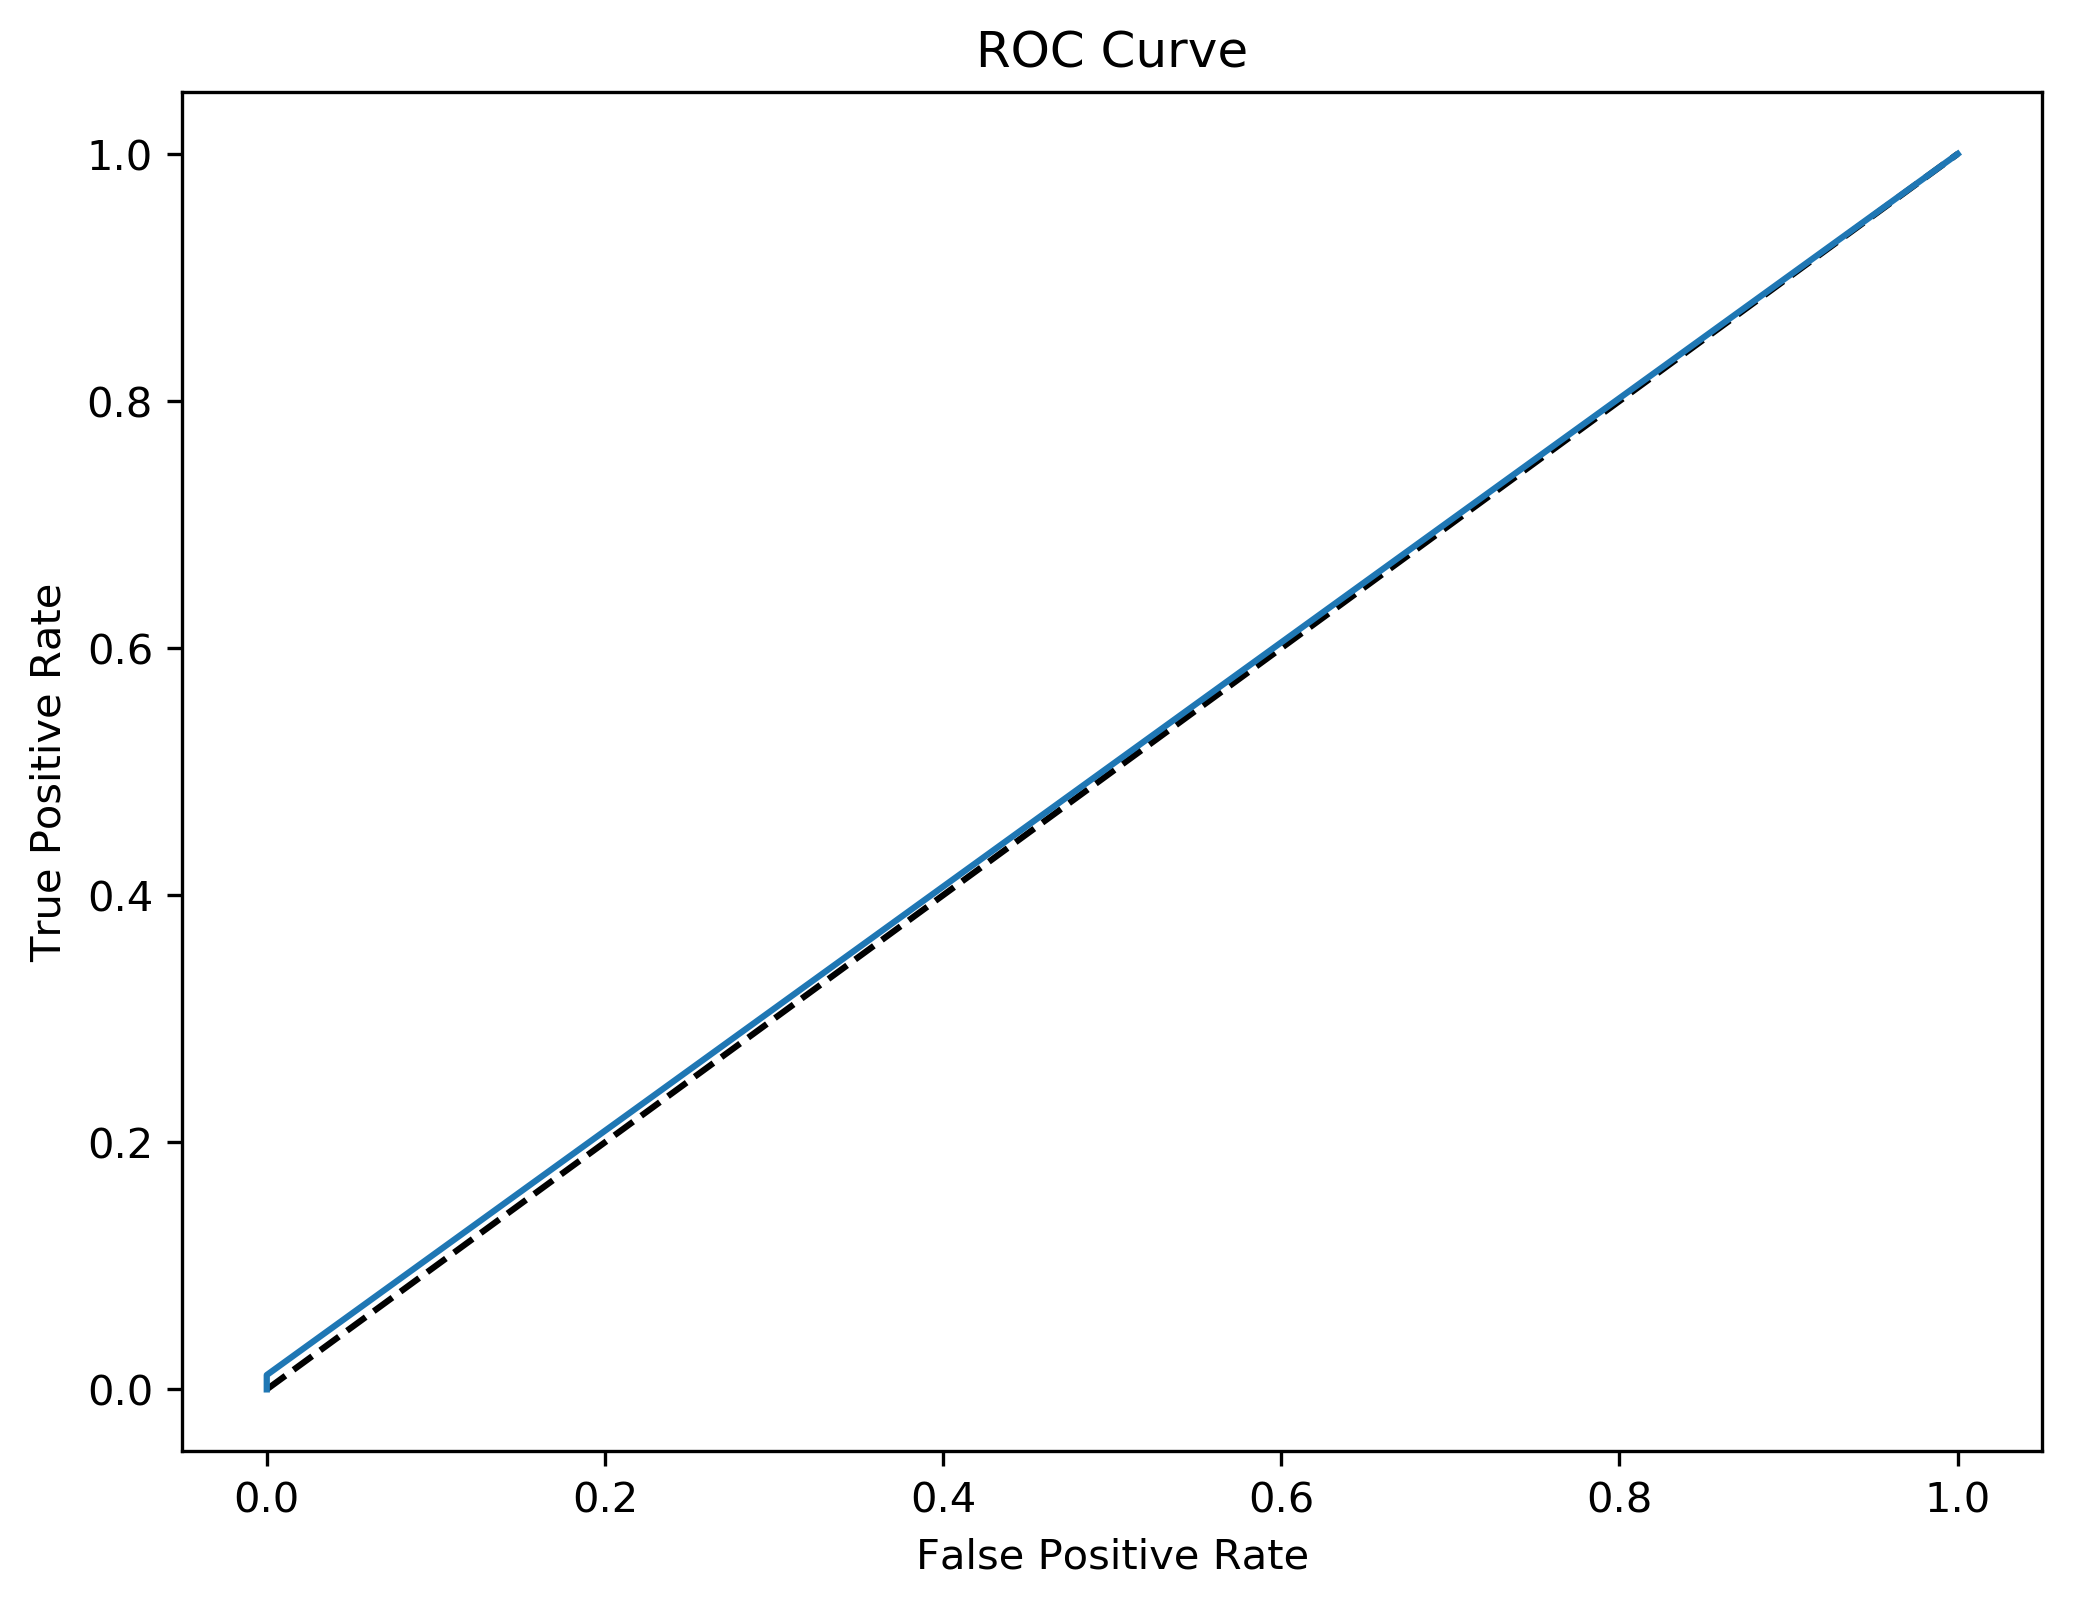

In [143]:
import datetime
starttime = datetime.datetime.now()
mm = MN(44,22,5,1,activation='sigmoid')
mm.train(X_std,y_train,0.001,iteration = 3000)
endtime = datetime.datetime.now()
print((endtime - starttime))
mm.predict(test_x,test_y)

## Torch

In [ ]:
import torch
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [ ]:
import torch.nn.functional as F

class Net(torch.nn.Module):     # 继承 torch 的 Module
    def __init__(self, n_feature, n_hidden, n_output): # 45in 
        super(Net, self).__init__()     # 继承 __init__ 功能
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 隐藏层线性输出
        self.out = torch.nn.Linear(n_hidden, n_output)       # 输出层线性输出

    def forward(self, x):
        # 正向传播输入值, 神经网络分析出输出值
        x = F.relu(self.hidden(x))      # 激励函数(隐藏层的线性值)
        x = self.out(x)                 # 输出值, 但是这个不是预测值, 预测值还需要再另外计算
        return x

net = Net(n_feature=44, n_hidden=1000, n_output=2) # 几个类别就几个 output
print(net)

In [ ]:
import torch.utils.data as Data
tensor_data = torch.from_numpy(X_std)
tensor_data = tensor_data.float()
tensor_target = torch.from_numpy(y_train)

test_x = scaler.fit_transform(test_x)
test_x = torch.from_numpy(test_x)
test_x = test_x.float()


torch_dataset = Data.TensorDataset(tensor_data, tensor_target)
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               #   
)


net2 = torch.nn.Sequential(
    torch.nn.Linear(44, 1),
    torch.nn.Dropout(0.5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(1, 3),
    torch.nn.Dropout(0.5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(3, 2),
)
print(net2)


In [2]:
import torch
# Hyper Parameters
EPOCH = 1500          #
BATCH_SIZE = 80     # whole dataset
LR = 0.001         # learning rate

optimizer = torch.optim.SGD(net2.parameters(), lr=LR)

loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCH):   # 训练所有!整套!数据 50000次
    for step, (batch_x, batch_y) in enumerate(loader):
        output = net2(batch_x)               #  output
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    if epoch % 100 == 0:
        test_output = net2(test_x)                   # (samples, time_step, input_size)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)

NameError: name 'net2' is not defined

In [4]:

#Final fine tune numpy model - with dropout
EPOCH = 3000          # 
BATCH_SIZE = 80     # 20
LR = 0.001         # learning rate

netf = torch.nn.Sequential(
    torch.nn.Linear(44, 22),
    torch.nn.Dropout(0.5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(22, 5),
    torch.nn.Dropout(0.5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 2),
)
optimizer = torch.optim.Adam(netf.parameters(), lr=LR, betas=(0.9, 0.99))
#starttime = datetime.datetime.now()
for epoch in range(EPOCH):   # 
    for i, (batch_x, batch_y) in enumerate(loader):
        output = netf(batch_x)               #  output
        loss = loss_func(output, batch_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
    if epoch % 100 == 0:
        test_output = netf(test_x)                   # (samples, time_step, input_size)
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
#endtime = datetime.datetime.now()
print((endtime - starttime))

def softMax(X):
    result = [np.array([(np.exp(x[0])/(np.exp(x[0])+np.exp(x[1]))), (np.exp(x[1])/(np.exp(x[0])+np.exp(x[1])))]) for x in X ]
    return result

def getScore(X,y):
    test_output = netf(X)
    y_pro = [p[1] for p in softMax(test_output.data.numpy())]
    y_pred = [1 if c > 0.5 else 0 for c in y_pro]

    
    fpr,tpr,thresholds = roc_curve(y, y_pro)
    acc = list(y-y_pred).count(0)/len(y_pred)
        
    print('Acc: {}'.format(acc))
    print(classification_report(y,y_pred))
    print(confusion_matrix(y,y_pred))
    print("AUC: {}".format(roc_auc_score(y, y_pred)))
    sns.set_style()
    plt.figure(figsize=(8,6),dpi = 300)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

getScore(test_x,test_y)
#0:00:05.804908
#Acc: 0.5401069518716578
#AUC: 0.7195736434108527

NameError: name 'loader' is not defined